In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import copy as cp
import h5py
import sys
import corner
import copy
import scipy

from mpl_toolkits.mplot3d import Axes3D
from scipy.special import comb
from astropy import units as u

import analysis
import signals
import estimators
import fitting
import models
import utils

In [3]:
plt.style.use('seaborn-colorblind')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
colors

['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']

# Simulations

In [5]:
rez = 512 # 1024
#box = h5py.File('halos.z8.hdf5', 'r')
box_old = h5py.File('L80_halos_z=6.0155.hdf5', 'r')

In [6]:
box_old.keys()

<KeysViewHDF5 ['mass', 'pos', 'rho']>

In [7]:
#density = np.fromfile('rho.z=07.9589_cic_1024', dtype=np.float64).reshape(rez, rez, rez, order='F')

In [8]:
#density.max()

In [9]:
redshift = 6.0155 #7.9589
masses = np.array(box_old[('mass')])
pos = np.array(box_old[('pos')])
density = np.array(box_old[('rho')])
x, y, z = pos.T
coords = [*pos.T]

#x = np.array(box[('x')])
#y = np.array(box[('y')])
#z = np.array(box[('z')])

In [10]:
runs = 3
n_bins = 20

In [11]:
box_size = 80 # in Mpc
r = np.linspace(0, box_size, rez)
r_vec = np.stack((r, r, r))

In [12]:
mass_voxels, mass_edges = np.histogramdd([x,y,z], bins=rez,
                                                weights=masses)

Text(0, 0.5, '$\\frac{dN}{dLog(M)}$')

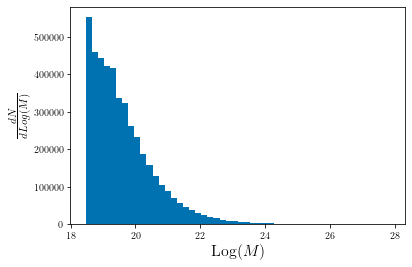

In [13]:
masses_hist = plt.hist(np.log(masses), bins=50)
plt.xlabel(r'Log$(M)$', fontsize=16)
plt.ylabel(r'$\frac{dN}{dLog(M)}$', fontsize=16)

In [14]:
delta = utils.overdensity(density)

/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


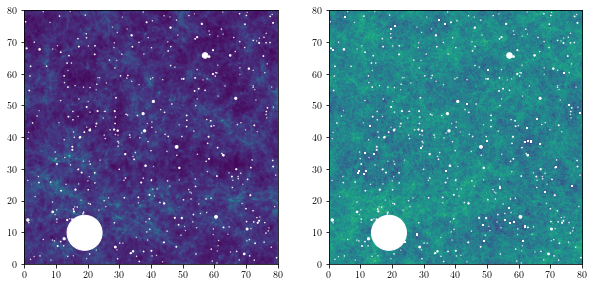

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

extents = [0,box_size,0,box_size]

#density_field = ax[0].imshow(np.log10(density.sum(axis=2)), origin='lower', extent=extents)
delta_field = ax[0].imshow(delta.sum(axis=2), origin='lower', extent=extents)
mass_field = ax[1].imshow(np.log10(mass_voxels.sum(axis=2)), origin='lower', extent=extents)

ax[0].scatter(x[0:-1:10000], y[0:-1:10000], s=1e-9 * masses[0:-1:10000], c='white')
ax[1].scatter(x[0:-1:10000], y[0:-1:10000], s=1e-9 * masses[0:-1:10000], c='white')

#fig.colorbar(density_field, ax=ax)

In [16]:
# k, P_m = analysis.calc_pspec(r_vec, [delta], n_bins=n_bins, bin_scale='log')

In [17]:
#np.savez('matter_pspec_6.0155', k=k, P_m=P_m)

In [18]:
matter_pspec = np.load('matter_pspec_6.0155.npz')

In [19]:
matter_pspec.files

['k', 'P_m']

In [20]:
k = matter_pspec['k']
P_m = matter_pspec['P_m']

### Checking power spectrum code with Powerbox

Let's check our power spectrum code to make sure it does what we expect. We'll compare it to the inimitable Steven Murray's Powerbox code.

In [21]:
from powerbox import get_power

p_k_field, bins_field = get_power(delta, box_size,
                                    bins=k, bin_ave=False,
                                    vol_normalised_power=True)

In [22]:
p_k_field_log, bins_field_log = get_power(delta, box_size, log_bins=True, bin_ave=False,
                                    vol_normalised_power=True)

/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/powerbox/tools.py:106: UserWarning: One or more radial bins had no cells within it.
  warnings.warn("One or more radial bins had no cells within it.")
/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/powerbox/tools.py:160: RuntimeWarning: invalid value encountered in true_divide
  rl = np.bincount(indx, weights=np.real(field.flatten()), minlength=len(sumweights)+2)[1:-1] / sumweights


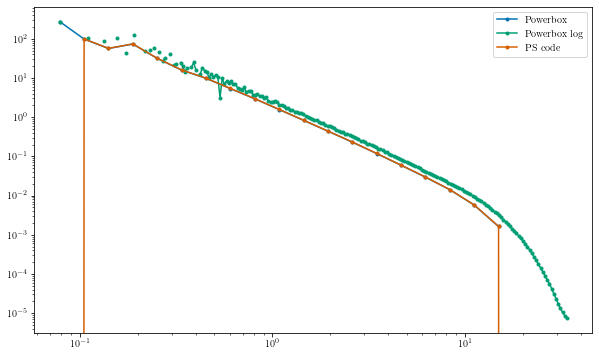

In [23]:
fig = plt.subplots(figsize=(10,6))

plt.plot(bins_field[:-1], p_k_field,label="Powerbox", marker='.')
plt.plot(bins_field_log[:-1], p_k_field_log, label="Powerbox log", marker='.', ls='-')
plt.plot(k, P_m,label="PS code", marker='.')

plt.legend()
plt.xscale('log')
plt.yscale('log')

So our power spectra code is in good agreement with Steven Murray.  A reassuring sign!

### Comparison with CAMB and Powerbox

Now we need to make sure that our spectra our reasonable, compared to known results. Let's compare with the CAMB simulation code.

In [24]:
import sys, platform, os
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/camb


In [25]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);


In [26]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[6.0155], kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, redshifts, pk = results.get_matter_power_spectrum(minkh=bins_field[0], maxkh=bins_field[-5],
                                              npoints=200)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=bins_field[0],
                                                                   maxkh=bins_field[-5],
                                                                   npoints = 200)


In [27]:
#calculate results for these parameters
results = camb.get_results(pars)

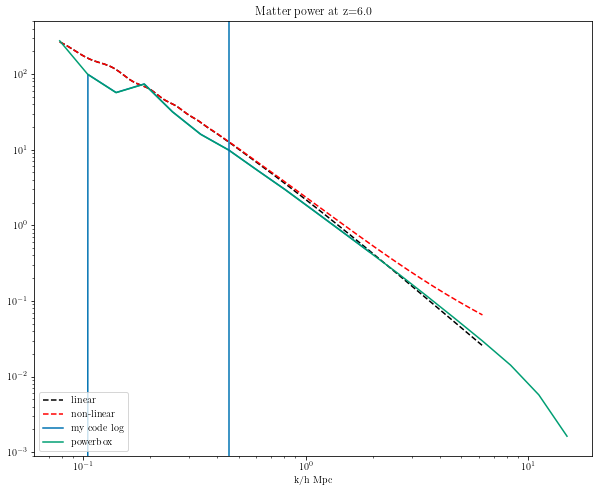

In [28]:
#for i, (redshift, line) in enumerate(zip(redshift,['-','--'])):
fig = plt.figure()

fig.set_figheight(8)
fig.set_figwidth(10)

plt.loglog(kh, pk[0,:], color='k', ls='--')
plt.loglog(kh_nonlin, pk_nonlin[0,:], color='r', ls='--')
    
#plt.loglog(k_log, density_pspec_log)
plt.loglog(k[0:12], P_m[0:12])
plt.loglog(bins_field[:-1], p_k_field)

plt.xlabel('k/h Mpc');
plt.legend(['linear','non-linear', 'my code log', 'powerbox'], loc='lower left');
plt.title('Matter power at z=6.0')

plt.axvline(k[6])

### Simulating the 21cm brightness temperature field

We also want to cross-correlate our intensities with the 21cm field.  In order to simulate it, we use Paul La Plante's 'quick and dirty' simulation code package <\code zreion>.

In [29]:
from zreion import apply_zreion_fast
from astropy.cosmology import Planck15

In [228]:
# parameters
#box = 80.0  # Mpc/h
omegam = Planck15.Om0
omegab = Planck15.Ob0
hubble0 = Planck15.H0

alpha = 0.564
k_0 = 0.185 # Mpc/h
b_0 = 1.0 / 1.686

# global temperature as a function of redshift
def t0(redshift):
    return 38.6 * hubble0.value * (omegab / 0.045) * np.sqrt(0.27 / omegam * (1 + redshift) / 10)

In [31]:
def gen_21cm_fields(delta, box_size= 80.0, zmean=7, alpha=0.11, k0=0.05):
    # compute zreion field
    print("computing zreion...")
    zreion = apply_zreion_fast(delta, zmean, alpha, k0, box_size, deconvolve=False)
    
    return zreion

def get_21cm_fields(redshift, zreion, delta):
    #print("computing t21 at z=", redshift, "...")
    ion_field = np.where(zreion > redshift, 1.0, 0.0)
    t21_field = t0(redshift) * (1 + delta) * (1 - ion_field)
    
    return ion_field, t21_field

In [32]:
#zreion = gen_21cm_fields(delta)

In [33]:
#np.save('zreion', zreion)

In [233]:
t0(redshift)

2216.3834010174064

In [34]:
zreion = np.load('zreion.npy')

In [35]:
ion_field, t21_field = get_21cm_fields(redshift, zreion, delta)

In [36]:
#zreion1 = gen_21cm_fields(delta, alpha = 0.05, k0 = 0.3)
#zreion2 = gen_21cm_fields(delta, alpha = 0.11, k0 = 0.05)
#zreion3 = gen_21cm_fields(delta, alpha = 0.15, k0 = 0.1)
#zreion4 = gen_21cm_fields(delta, alpha = 0.25, k0 = 0.07)
#zreion5 = gen_21cm_fields(delta, alpha = alpha, k0 = k_0)

In [37]:
#redshifts = np.linspace(5,15)

#def create_reion_history(redshifts, zreion, delta):
#    neutral_frac = np.zeros_like(redshifts)
#    for i, z in enumerate(redshifts):
#        ion_field, t21_field = get_21cm_fields(z, zreion, delta)
#        ion_frac = ion_field.sum() / 512**3
#        neutral_frac[i] = 1 - ion_frac
        
#    return neutral_frac

In [38]:
#neutral_frac1 = create_reion_history(redshifts, zreion1, delta)
#neutral_frac2 = create_reion_history(redshifts, zreion2, delta)
#neutral_frac3 = create_reion_history(redshifts, zreion3, delta)
#neutral_frac4 = create_reion_history(redshifts, zreion4, delta)
#neutral_frac5 = create_reion_history(redshifts, zreion5, delta)

In [39]:
#fig = plt.figure(figsize=(10,8))

#plt.plot(redshifts, neutral_frac1, label='1')
#plt.plot(redshifts, neutral_frac2, label='Paul')
#plt.plot(redshifts, neutral_frac3, label='3')
#plt.plot(redshifts, neutral_frac4, label='4')
#plt.plot(redshifts, neutral_frac5, label='Battaglia')

#plt.axhline(.5, color='gray', ls='--')
#plt.axvline(7, color='gray', ls='--')
#plt.axvline(10, color='gray', ls='--')

#plt.xlabel('redshift', fontsize=16)
#plt.ylabel('neutral fraction', fontsize=16)

#plt.legend()

In [40]:
#redshifts = np.linspace(5,15)

#neutral_frac = np.zeros_like(redshifts)

#for i, z in enumerate(redshifts):
#    ion_field, t21_field = get_21cm_fields(z, zreion, delta)
#    ion_frac = ion_field.sum() / 512**3
#    neutral_frac[i] = 1 - ion_frac

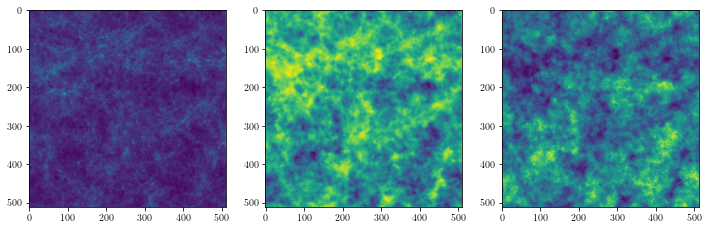

In [41]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1,3, figsize=(12,8))

ax[0].imshow(delta.sum(axis=2))
ax[1].imshow(ion_field.sum(axis=2))
ax[2].imshow(t21_field.sum(axis=2))

### Checking normalisation of luminosity functions 

Next we are going to need to generate some simulated specific intensities from our box our halos. This is done by 'painting' a luminosity onto the halos using a power law prescription,

$$
L(M) = L_0 \left( \frac{M}{M_0} \right)^{\alpha}
$$

Let's plot this relation for our collection our halos,

In [42]:
import astropy.constants as const

In [43]:
H_I_power = 1.3

L = 2.0 / 3.0
M = 1.0
H = 4.0 / 3.0

power_indices = [H_I_power, L, M]

L_solar=3.828e26
L_CII = 10e6
L_OIII = 10e9

luminosities_L = utils.mass2luminosity(masses, power=L)
luminosities_M = utils.mass2luminosity(masses, power=M)
luminosities_H = utils.mass2luminosity(masses, power=H)

intensities_L = utils.specific_intensity(redshift, L=luminosities_L)
intensities_M = utils.specific_intensity(redshift, L=luminosities_M)
intensities_H = utils.specific_intensity(redshift, L=luminosities_H)

Text(0, 0.5, 'luminosities')

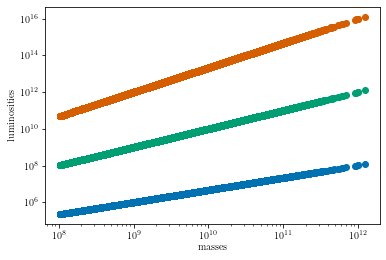

In [44]:
fig, ax = plt.subplots()

ax.scatter(masses, luminosities_L)
ax.scatter(masses, luminosities_M)
ax.scatter(masses, luminosities_H)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('masses')
ax.set_ylabel('luminosities')

In [45]:
np.mean(intensities_L), np.mean(intensities_M), np.mean(intensities_H)

(<Quantity 0.34933263 Jy / sr>,
 <Quantity 386.96156576 Jy / sr>,
 <Quantity 628221.22734607 Jy / sr>)

#### Checking unit conversion

Intensities are often given in units of Janskies.  Let's make sure that we are converting correctly from one to the other, and they are comparable to the Lidz and Beane result (https://arxiv.org/pdf/1806.02796.pdf)

In [46]:
print('Lidz: ', 3.1e2,
      ' My code: ', utils.specific_intensity(9.41))
print('Lidz: ', 7.1e2,
      ' My code: ', utils.specific_intensity(7.37))
print('Lidz: ', 1.1e3,
      'My code: ', utils.specific_intensity(6.43))

Lidz:  310.0  My code:  296.85416094619967 Jy / sr
Lidz:  710.0  My code:  675.7372227764706 Jy / sr
Lidz:  1100.0 My code:  1065.0564106095567 Jy / sr


In [47]:
def gen_spectra(fields): 

    lines_indices = np.zeros((int(comb(runs, 2) + runs), 2))
    pspecs = np.zeros((int(comb(runs, 2) + runs), n_bins))
    pspecs_dim = np.zeros((int(comb(runs, 2) + runs), n_bins))
    
    counter = 0
    for i in range(runs):
        for j in range(i, runs):
            print('Calculating correlation for Lines', i, ' and ', j)
            print('with power indices')
            k, pspec, pspec_dim = analysis.pspec(r_vec,
                            [fields[i], fields[j]],
                            n_bins=n_bins, bin_scale='log')

            pspecs[counter] = pspec
            pspecs_dim[counter] = pspec_dim

            lines_indices[counter,0] = i 
            lines_indices[counter,1] = j

            counter += 1
            
    return k, pspecs, pspecs_dim

In [48]:
indices = utils.lines_indices()
indices

array([[0., 0.],
       [0., 1.],
       [0., 2.],
       [1., 1.],
       [1., 2.],
       [2., 2.]])

In [49]:
# shot_0 = 80**3 * a_0 * I_0.mean()**2 / len(masses) 
# shot_1 = 80**3 * a_1 * I_1.mean()**2 / len(masses) 
# shot_2 = 80**3 * a_2 * I_2.mean()**2 / len(masses)

In [50]:
1.1e3 * 3, 34933.26280430619

(3300.0, 34933.26280430619)

In [161]:
I_fields = np.zeros((runs, rez, rez, rez))
scalings = [.007, 7.5**4, 2.8]

for i, power in enumerate(power_indices):
    print('power =', power)
    intensities = utils.specific_intensity(redshift,
                            L=scalings[i] * utils.mass2luminosity(masses, power=power, mass_0=1.0))

    print('mean intensity = ', intensities.mean())
    print(' ')
    # lumens += np.random.lognormal(mean=0.0, sigma=2.0, size=None)
    I_voxels, I_edges = np.histogramdd([x,y,z], bins=rez, weights=intensities)
    I_fields[i] = I_voxels

power = 1.3
mean intensity =  2057.980657553699 Jy / sr
 
power = 0.6666666666666666
mean intensity =  1105.3102684174994 Jy / sr
 
power = 1.0
mean intensity =  1083.4923841336547 Jy / sr
 


In [52]:
#fig, ax = plt.subplots(figsize=(10,8))

#for i, power in enumerate(power_indices):
#    print('power=', power)
#    lumens = np.sqrt(scalings[i]) * utils.mass2luminosity(masses, power=power, mass_0=1.0)
#    print('mean= ', lumens.mean())
#    n, bins, _ = ax.hist(np.log(lumens.value), 100, alpha = 0.5, lw=3, log=True, label=r'$\alpha=$' + str(power))
    
#ax.set_xlabel(r'log[L]', fontsize=16)
#ax.set_ylabel(r'log[N(L)]', fontsize=16)

#fig.legend()

    
    # print('shot noise for index, alpha=', power, ': is ', integral)
    

In [53]:
def set_I_mean(Lidz_pspec_log, P_x):
    return np.sqrt(Lidz_pspec_log / P_x)

The shot noise can be roughly approximated as such. Since the shot noise is due to number of sources, we expect the shot noise to increase with decreasing number density.  If we assume it scales inversely, then this is roughly,
$$
\sigma_{\text{shot}} \propto \frac{1}{\bar{n}} = \frac{V}{N}
$$
The dimensions of the power spectrum are,
$$
[\text{field}^2][V]
$$
To be consistent dimensionally, we multiply by the mean of the field (in our case, $T$),
$$
\sigma_{\text{shot}} \sim \frac{{<\tilde{T}^2>} V}{N}
$$

In [54]:
#shot_0, shot_1, shot_2

## Generate spectra

Now that we have our 21cm brightness temperature field, we can go ahead and calculate our spectra.

In [55]:
# indices

### Superfake data

In [56]:
#spectra_sf = cp.deepcopy(spectra_fs)

# b_i = np.sqrt(spectra_sf[1][0] / P_m)
# b_j = np.sqrt(spectra_sf[1][3] / P_m)
# b_k = np.sqrt(spectra_sf[1][5] / P_m) 

# biases = [b_i, b_j, b_k]

# for i in range(len(indices)):
#    print(indices[i][0], indices[i][1])
#    spectra_sf[1][i] = biases[int(indices[i][0])] * biases[int(indices[i][1])] * P_m

### Power law data

In [57]:
# power law
#spectra_pl = analysis.gen_spectra(r_vec, I_fields)

### Brightness temperature data

In [58]:
#I_fields_bt = cp.deepcopy(I_fields)
#I_fields_bt[0] = t21_field

# full simulation
#spectra_bt = analysis.gen_spectra(r_vec, I_fields_bt)

### Datasets

In [59]:
#np.savez('pspecs_sf', P_21cm_21cm=spectra_sf[1][0], P_21cm_CII=spectra_sf[1][1],
#                    P_21cm_OIII=spectra_sf[1][2], P_CII_CII=spectra_sf[1][3],
#                    P_CII_OIII=spectra_sf[1][4], P_OIII_OIII=spectra_sf[1][5])

#np.savez('pspecs_pl', P_21cm_21cm=spectra_pl[1][0], P_21cm_CII=spectra_pl[1][1],
#                    P_21cm_OIII=spectra_pl[1][2], P_CII_CII=spectra_pl[1][3],
#                    P_CII_OIII=spectra_pl[1][4], P_OIII_OIII=spectra_pl[1][5])

#np.savez('pspecs_bt', P_21cm_21cm=spectra_bt[1][0], P_21cm_CII=spectra_bt[1][1],
#                    P_21cm_OIII=spectra_bt[1][2], P_CII_CII=spectra_bt[1][3],
#                    P_CII_OIII=spectra_bt[1][4], P_OIII_OIII=spectra_bt[1][5])

In [60]:
pspecs_sf = np.load('pspecs_sf.npz')
pspecs_pl = np.load('pspecs_pl.npz')
pspecs_bt = np.load('pspecs_bt.npz')
pspecs_bt.files

['P_21cm_21cm',
 'P_21cm_CII',
 'P_21cm_OIII',
 'P_CII_CII',
 'P_CII_OIII',
 'P_OIII_OIII']

In [140]:
spectra_sf = (k, [pspecs_sf['P_21cm_21cm'], pspecs_sf['P_21cm_CII'],
               pspecs_sf['P_21cm_OIII'], pspecs_sf['P_CII_CII'],
               pspecs_sf['P_CII_OIII'], pspecs_sf['P_OIII_OIII']])

spectra_pl = (k, [pspecs_pl['P_21cm_21cm'], pspecs_pl['P_21cm_CII'],
               pspecs_pl['P_21cm_OIII'], pspecs_pl['P_CII_CII'],
               pspecs_pl['P_CII_OIII'], pspecs_pl['P_OIII_OIII']])

spectra_bt = (k, [pspecs_bt['P_21cm_21cm'], pspecs_bt['P_21cm_CII'],
               pspecs_bt['P_21cm_OIII'], pspecs_bt['P_CII_CII'],
               pspecs_bt['P_CII_OIII'], pspecs_bt['P_OIII_OIII']])

In [62]:
spectra_bt[1][0] / spectra_pl[1][0]

/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([           nan, 1.18943748e+01, 6.77878578e+00, 9.33372960e+00,
       7.02728728e+00, 5.29349457e+00, 4.24033845e+00, 3.23214453e+00,
       2.17437793e+00, 1.35258246e+00, 7.65470579e-01, 3.74288109e-01,
       1.62741044e-01, 7.74099147e-02, 3.72030898e-02, 1.39411712e-02,
       4.91938349e-03, 1.81518280e-03, 6.50557636e-04,            nan])

In [63]:
def dimless(k, P):
    return k**3 / (2 * np.pi**2) * P

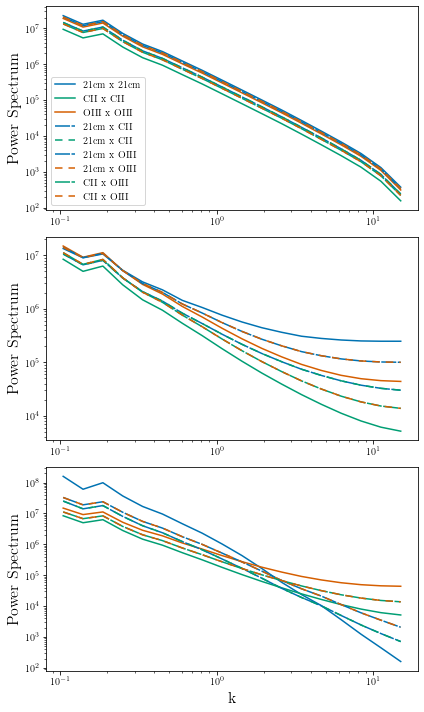

In [64]:
fig, ax = plt.subplots(3,1)

fig.set_figheight(10)
fig.set_figwidth(6)

autos = [0,3,5]
cross = [1,2,4]

line_labels = ['21cm', 'CII', 'OIII']

for i, ind in enumerate(autos):
    ax[0].loglog(k[1:-1], spectra_sf[1][ind][1:-1], marker='None',
            label=r'{} x {} '.format(line_labels[int(indices[ind][0])],
                                                       line_labels[int(indices[ind][1])]), color=colors[i])
    
    ax[1].loglog(k[1:-1], spectra_pl[1][ind][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[ind][0])],
                                                   line_labels[int(indices[ind][1])]))

    ax[2].loglog(k[1:-1], spectra_bt[1][ind][1:-1], marker='None',
    label=r'{} x {} '.format(line_labels[int(indices[ind][0])],
                                               line_labels[int(indices[ind][1])]))
    
for i, ind in enumerate(cross):
    line1 = int(indices[ind][0])
    line2 = int(indices[ind][1])
    ax[0].loglog(k[1:-1], spectra_sf[1][ind][1:-1], marker='None', 
                 label=r'{} x {} '.format(line_labels[line1], line_labels[line2]), ls='--', 
                                                                 dashes=(10, 1), color=colors[line1])
    
    ax[0].loglog(k[1:-1], spectra_sf[1][ind][1:-1], marker='None', 
                 label=r'{} x {} '.format(line_labels[line1], line_labels[line2]), ls='--',
                 dashes=(5, 4), color=colors[line2])
    
    ax[1].loglog(k[1:-1], spectra_pl[1][ind][1:-1], marker='None', 
                 label=r'{} x {} '.format(line_labels[line1], line_labels[line2]), ls='--', 
                                                                 dashes=(10, 1), color=colors[line1])
    
    ax[1].loglog(k[1:-1], spectra_pl[1][ind][1:-1], marker='None', 
                 label=r'{} x {} '.format(line_labels[line1], line_labels[line2]), ls='--',
                 dashes=(5, 4), color=colors[line2])
    
    ax[2].loglog(k[1:-1], spectra_bt[1][ind][1:-1], marker='None', 
                 label=r'{} x {} '.format(line_labels[line1], line_labels[line2]), ls='--', 
                                                                 dashes=(10, 1), color=colors[line1])
    
    ax[2].loglog(k[1:-1], spectra_bt[1][ind][1:-1], marker='None', 
                 label=r'{} x {} '.format(line_labels[line1], line_labels[line2]), ls='--',
                 dashes=(5, 4), color=colors[line2])
#plt.loglog(k[1:-1], spectra[label[1:-1], marker='None',
#        label=r'{} x {} '.format(line_labels[int(indices[3][0])],
#                                                       line_labels[int(indices[3][1])]))

#plt.loglog(k[1:-1], spectra[1][5][1:-1], marker='None',
#        label=r'{} x {} '.format(line_labels[int(indices[5][0])],
#                                                       line_labels[int(indices[5][1])]))

#ax[0].set_xlabel('k',fontsize=16)
#ax[1].set_xlabel('k',fontsize=16)
ax[2].set_xlabel('k',fontsize=16)

ax[0].set_ylabel('Power Spectrum', fontsize=16)
ax[1].set_ylabel('Power Spectrum', fontsize=16)
ax[2].set_ylabel('Power Spectrum', fontsize=16)

ax[0].legend(fontsize=10)

fig.tight_layout()
fig.savefig('pspecs.pdf')

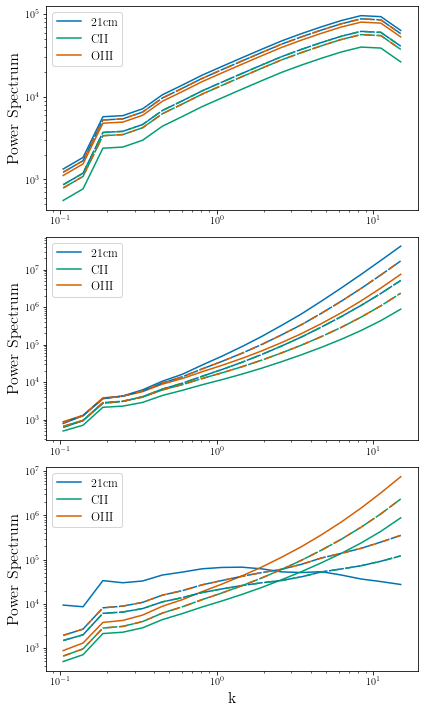

In [148]:
fig, ax = plt.subplots(3,1)

fig.set_figheight(10)
fig.set_figwidth(6)

autos = [0,3,5]
cross = [1,2,4]

lines = [[]for i in range(3)]
line_labels = ['21cm', 'CII', 'OIII']


for i, ind in enumerate(autos):
    lines[i], = ax[0].loglog(k[1:-1], dimless(k[1:-1], spectra_sf[1][ind][1:-1]), marker='None', color=colors[i])
    
    ax[1].loglog(k[1:-1], dimless(k[1:-1], spectra_pl[1][ind][1:-1]), marker='None')

    ax[2].loglog(k[1:-1], dimless(k[1:-1], spectra_bt[1][ind][1:-1]), marker='None')
    
for i, ind in enumerate(cross):
    line1 = int(indices[ind][0])
    line2 = int(indices[ind][1])
    ax[0].loglog(k[1:-1], dimless(k[1:-1], spectra_sf[1][ind][1:-1]), marker='None', ls='--', 
                                                                 dashes=(10, 1), color=colors[line1])
    
    ax[0].loglog(k[1:-1], dimless(k[1:-1], spectra_sf[1][ind][1:-1]), marker='None', ls='--',
                 dashes=(5, 4), color=colors[line2])
    
    ax[1].loglog(k[1:-1], dimless(k[1:-1], spectra_pl[1][ind][1:-1]), marker='None', ls='--', 
                                                                 dashes=(10, 1), color=colors[line1])
    
    ax[1].loglog(k[1:-1], dimless(k[1:-1], spectra_pl[1][ind][1:-1]), marker='None', ls='--',
                 dashes=(5, 4), color=colors[line2])
    
    ax[2].loglog(k[1:-1], dimless(k[1:-1], spectra_bt[1][ind][1:-1]), marker='None', ls='--', 
                                                                 dashes=(10, 1), color=colors[line1])
    
    ax[2].loglog(k[1:-1], dimless(k[1:-1], spectra_bt[1][ind][1:-1]), marker='None', ls='--',
                 dashes=(5, 4), color=colors[line2])
#plt.loglog(k[1:-1], spectra[label[1:-1], marker='None',
#        label=r'{} x {} '.format(line_labels[int(indices[3][0])],
#                                                       line_labels[int(indices[3][1])]))

#plt.loglog(k[1:-1], spectra[1][5][1:-1], marker='None',
#        label=r'{} x {} '.format(line_labels[int(indices[5][0])],
#                                                       line_labels[int(indices[5][1])]))

#ax[0].set_xlabel('k',fontsize=16)
#ax[1].set_xlabel('k',fontsize=16)
ax[2].set_xlabel('k',fontsize=16)

ax[0].set_ylabel('Power Spectrum', fontsize=16)
ax[1].set_ylabel('Power Spectrum', fontsize=16)
ax[2].set_ylabel('Power Spectrum', fontsize=16)

ax[0].legend(lines, line_labels, fontsize=12)
ax[1].legend(lines, line_labels, fontsize=12)
ax[2].legend(lines, line_labels, fontsize=12)

fig.tight_layout()
fig.savefig('pspecs.pdf')

In [144]:
lines

[[<matplotlib.lines.Line2D at 0x7fd145e34490>]]

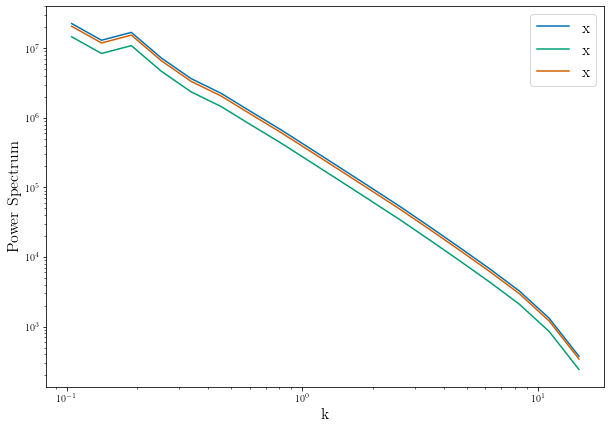

In [66]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = ['P_21cm_21cm', 'P_21cm_CII', 'P_21cm_OIII']

for label in line_labels:
#ax.axvline(k[9], color='black', ls='--', alpha=.2)

#plt.loglog(k, Lidz_pspec_log, label='Lidz log')
    #legend_label = r*label

    plt.loglog(k[1:-1], pspecs_sf[label][1:-1], marker='None',
            label=r'x')

#plt.loglog(k[1:-1], spectra[label[1:-1], marker='None',
#        label=r'{} x {} '.format(line_labels[int(indices[3][0])],
#                                                       line_labels[int(indices[3][1])]))

#plt.loglog(k[1:-1], spectra[1][5][1:-1], marker='None',
#        label=r'{} x {} '.format(line_labels[int(indices[5][0])],
#                                                       line_labels[int(indices[5][1])]))


plt.xlabel('k',fontsize=16)
plt.ylabel('Power Spectrum', fontsize=16)

plt.legend(fontsize=16)

Let's plot the power spectrum, $P(k)$,

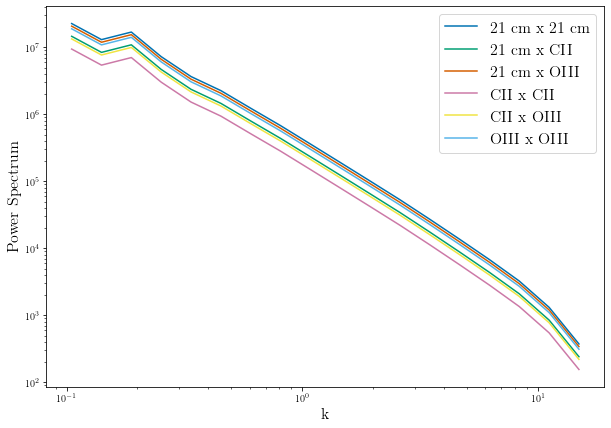

In [67]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = [r'21 cm', r'CII', r'OIII']

#ax.axvline(k_log[9], color='black', ls='--', alpha=.2)

#plt.loglog(k_log, Lidz_pspec_log, label='Lidz log')

for i in range(len(spectra_sf[1])):
    plt.loglog(k[1:-1], spectra_sf[1][i][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[i][0])],
                                                       line_labels[int(indices[i][1])]))

plt.xlabel('k',fontsize=16)
plt.ylabel('Power Spectrum', fontsize=16)

plt.legend(fontsize=16)

and the dimensionless power spectrum, $\Delta(k)$,

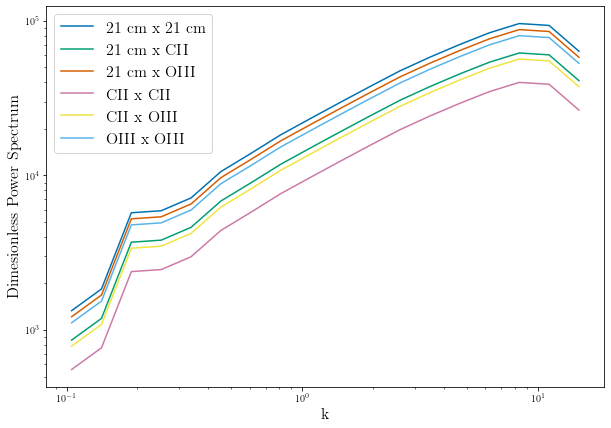

In [68]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = [r'21 cm', r'CII', r'OIII']

#ax.axvline(k_log[9], color='black', ls='--', alpha=.2)

#plt.loglog(k_log, Lidz_pspec_log, label='Lidz log')

for i in range(len(spectra_sf[1])):
    plt.loglog(k[1:-1], (k[1:-1]**3 / (2 * np.pi**2)) * spectra_sf[1][i][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[i][0])],
                                                       line_labels[int(indices[i][1])]))

plt.xlabel('k',fontsize=16)
plt.ylabel('Dimesionless Power Spectrum', fontsize=16)


plt.legend(fontsize=16)

### Comparing amplitudes with Lidz et al.

We want to make sure that our spectra are reasonable.

#### Autocorrelations

In [69]:
P_21cm_21cm = spectra_bt[1][0] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_CII_CII = spectra_bt[1][3] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_OIII_OIII = spectra_bt[1][5] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)

#### Crosscorrelations 

In [70]:
P_21cm_CII = spectra_bt[1][1] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_21cm_OIII = spectra_bt[1][2] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)
P_CII_OIII = spectra_bt[1][4] * u.Mpc**3 * u.Jy**2 * u.steradian**(-2)

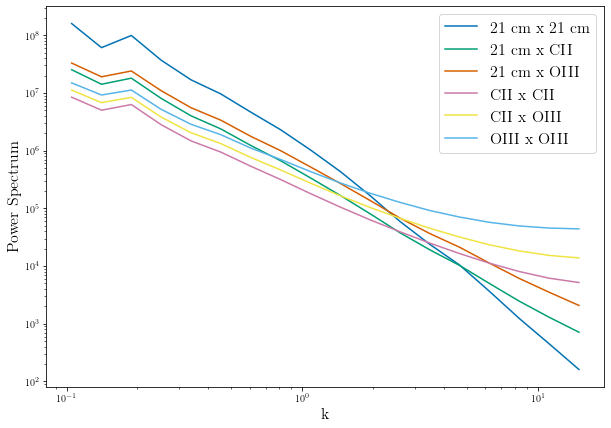

In [71]:
fig, ax = plt.subplots()

fig.set_figheight(7)
fig.set_figwidth(10)

line_labels = [r'21 cm', r'CII', r'OIII']

#ax.axvline(k_log[9], color='black', ls='--', alpha=.2)

#plt.loglog(k_log, Lidz_pspec_log, label='Lidz log')

for i in range(len(spectra_bt[1])):
    plt.loglog(k[1:-1], spectra_bt[1][i][1:-1], marker='None',
        label=r'{} x {} '.format(line_labels[int(indices[i][0])],
                                                       line_labels[int(indices[i][1])]))

plt.xlabel('k',fontsize=16)
plt.ylabel('Power Spectrum', fontsize=16)

plt.legend(fontsize=16)

# Surveys

test with different values of the power index, alpha

In [72]:
def error_bars(P_x, P_line1, P_line2, P_N, W_k, N_modes):
    sigma = (1 / np.sqrt(N_modes)) * np.sqrt(P_x**2 
                                            + P_line1 * (P_line2 + P_N / W_k**2))
    return sigma

def var_x(P_i, W_i, P_j, W_j, P_Ni, P_Nj, P_x, N_modes):
    W_x = np.sqrt(W_i * W_j)
    
    return ((P_i * W_i + P_Ni) * (P_j * W_j + P_Nj) + P_x**2 * W_x**2) / (2 * N_modes)
    
def var_auto(P_i, W_i, P_N, N_modes):
    return (P_i * W_i + P_N)**2 / N_modes

def calc_N_modes(k, V_surv, align='center'):
    
    k_vals = np.zeros(len(k) - 1)    
    delta_k = k[1:] - k[:-1] 

    if align is 'left':
        k_vals = k[:-1]

    if align is 'center':
        k_vals = (k[1:] + k[:-1]) / 2 

    if align is 'right':
        k_vals = k[1:]

    N_modes = k_vals**2 * delta_k * V_surv.to_value() / (4 * np.pi**2)

    return N_modes

def calc_P_N(sigma_pix, V_vox, t_pix):
    P_N = sigma_pix**2 * V_vox / t_pix
    
    return P_N

def calc_t_pix(N_det, t_obs, Omega_surv, sigma_beam):
    Omega_pix = 2 * np.pi * sigma_beam**2
    
    t_pix = N_det * t_obs / (Omega_surv / Omega_pix) 
    
    return t_pix.to(u.s, equivalencies=u.dimensionless_angles())

def calc_L_perp(redshift, Omega):
    # This assumes a square survey   
    return np.sqrt(Planck15.comoving_distance(redshift)**2 \
            * Omega).to(u.Mpc, equivalencies=u.dimensionless_angles()) * Planck15.h

def calc_L_para(redshift, nu_rest, delta_nu):
    return ((const.c / Planck15.H(redshift)) * delta_nu * (1 + redshift)**2 / \
            nu_rest).to(u.Mpc) * Planck15.h

def calc_V(redshift, width_perp, width_para, nu_rest):
    L_perp = calc_L_perp(redshift, width_perp)
    L_para = calc_L_para(redshift, nu_rest, width_para)
    
    return L_perp**2 * L_para

def calc_V_vox(redshift, sigma_beam, delta_nu, nu_rest):
    Omega_beam = sigma_beam**2
    V_vox = calc_V(redshift, Omega_beam, delta_nu, nu_rest)
    
    return V_vox

def calc_V_survey(redshift, Omega_surv, B_nu, nu_rest):
    V_survey = calc_V(redshift, Omega_surv, B_nu, nu_rest)
    
    return V_survey

def calc_V_surv_generic(redshift,lambda_rest, Omega_surv, B_nu):
    A_s = Omega_surv  
    B_nu = B_nu
    r = Planck15.comoving_distance(redshift)
    y = (lambda_rest * (1 + redshift)**2) / Planck15.H(redshift)

    V = r**2 * y * A_s * B_nu * Planck15.h**3
    
    return V.to(u.Mpc**3, equivalencies=u.dimensionless_angles())

def calc_V_surv_ij(redshift, lambda_i, Omega_surv_j, B_nu_j):
    # units in nanometers, GHz
    A = 3.3e7 * u.Mpc**3 # just a random prefactor (Mpc / h)^3
    V_surv_ij = A * (lambda_i / (158 * u.micron)) * np.sqrt((1 + redshift) / 8) \
                    * (Omega_surv_j / (16 * u.degree**2)) * (B_nu_j / (20 * u.GHz))

    return V_surv_ij.decompose().to(u.Mpc**3)

### Checking the resolution of the instrument

The maximum resolvable $k$ of the instrument is set by the size of the survey volume. This is roughly,
$$
V \approx R^2(z)\Omega \left[ \frac{c}{H(z)} \frac{B_{\nu} (1+z)^2}{\nu_{\text{rest}}} \right]
$$
Where the term $\sqrt{R(z)^2 \Omega}$ sets the minimum $k_{\perp}$ and $\left[ \frac{c}{H(z)} \frac{B_{\nu} (1+z)^2}{\nu_{\text{rest}}} \right]$ sets the minimum $k_{\parallel}$.

Then the maximum resolution is,
$$k_{\text{max}} = \sqrt{k_{\perp, \text{max}}^2 + k_{\parallel, \text{max}}^2} \\
= \sqrt{\left( \frac{4 \pi}{\sqrt{R(z)^2 \Omega}} \right)^2 + \left(\frac{2 \pi}{\left[ \frac{c}{H(z)} \frac{B_{\nu} (1+z)^2}{\nu_{\text{rest}}} \right]}\right)^2 }
$$

### Survey specifications

We now want to construct three surveys that have the same coverage in 2D k-space, such that we can perform cross correlations. We want three different lines, corresponding to 21 cm, CII, and OIII.

In [202]:
def calc_L_perp(redshift, Omega):
    # This assumes a square survey   
    R_z = Planck15.comoving_distance(redshift)
    return np.sqrt(R_z**2 * Omega).to(u.Mpc, equivalencies=u.dimensionless_angles()) * Planck15.h

def calc_L_para(redshift, nu_rest, delta_nu):
    return ((const.c / Planck15.H(redshift)) * delta_nu * (1 + redshift)**2 / \
            nu_rest).to(u.Mpc) * Planck15.h

def set_L_perp(k_perp_min, redshift):
    R_z = Planck15.comoving_distance(redshift) * Planck15.h
    Omega_surv = (2 * (2 * np.pi)**2 / (k_perp_min * R_z**2)) * u.radian**2

    return Omega_surv.to(u.degree**2)

def set_L_para(k_para_min, redshift, nu_rest):
    B_nu = (2 * np.pi * Planck15.H(redshift) * nu_rest) / \
            (const.c * k_para_min * (1 + redshift)**2) * Planck15.h
    
    return B_nu

In [192]:
k_units = k * u.Mpc**(-1)

# max and min k values are partially determined by the simulation box size
k_perp_min_box = 2 * (2 * np.pi)**2 / (box_size * u.Mpc)**2
k_para_min_box = (2 * np.pi) / (box_size * u.Mpc)

k_perp_max_box = 2 * (2 * np.pi) / ((box_size * u.Mpc) / 512)**2
k_para_max_box = (2 * np.pi) / ((box_size * u.Mpc) / 512)

In [194]:
nu_21cm = 1420.4 * u.MHz
nu_21cm_obs = utils.calc_nu_obs(nu_21cm, redshift)

lambda_21cm = utils.nu_to_wavelength(nu_21cm)

In [195]:
nu_CII = 1.9 * u.THz
nu_CII_obs = utils.calc_nu_obs(nu_CII, redshift)

lambda_CII = utils.nu_to_wavelength(nu_CII).to(u.micron) # micrometers

In [196]:
lambda_OIII = 88 * u.micron ## micrometers

nu_OIII = utils.wavelength_to_nu(lambda_OIII)
nu_OIII_obs = utils.calc_nu_obs(nu_OIII, redshift)

In [219]:
sigma_beam = 1.22 * lambda_CII / (3 * u.m)

Omega_surv_21cm = set_L_perp(k_perp_min_box, redshift)
Omega_surv_CII = set_L_perp(k_perp_min_box, redshift)
Omega_surv_OIII = set_L_perp(k_perp_min_box, redshift)

B_21cm = set_L_para(k_para_min_box, redshift, nu_21cm)
B_CII = set_L_para(k_para_min_box, redshift, nu_CII)
B_OIII = set_L_para(k_para_min_box, redshift, nu_OIII)

In [198]:
sigma_perp_21cm = utils.calc_sigma_perp(redshift, sigma_beam)
sigma_perp_CII = utils.calc_sigma_perp(redshift, sigma_beam)
sigma_perp_OIII = utils.calc_sigma_perp(redshift, sigma_beam)

In [199]:
delta_nu_CII = 10 * u.MHz
sigma_para_CII = utils.calc_sigma_para(redshift, nu_CII_obs, delta_nu_CII)

delta_nu_21cm = utils.set_sigma_para(sigma_para_CII, redshift, nu_21cm_obs)
sigma_para_21cm = utils.calc_sigma_para(redshift, nu_21cm_obs, delta_nu_21cm)

delta_nu_OIII = utils.set_sigma_para(sigma_para_CII, redshift, nu_OIII_obs)
sigma_para_OIII = utils.calc_sigma_para(redshift, nu_OIII_obs, delta_nu_OIII)

In [200]:
print(delta_nu_21cm.to(u.kHz))
print(delta_nu_CII.to(u.MHz))
print(delta_nu_OIII.to(u.MHz))

7.4757894736842125 kHz
10.0 MHz
17.930170933014356 MHz


In [203]:
L_perp_21cm = calc_L_perp(redshift, Omega_surv_21cm)
L_para_21cm = calc_L_para(redshift, nu_21cm, B_21cm)

L_perp_CII = calc_L_perp(redshift, Omega_surv_CII)
L_para_CII = calc_L_para(redshift, nu_CII, B_CII)

L_perp_OIII = calc_L_perp(redshift, Omega_surv_OIII)
L_para_OIII = calc_L_para(redshift, nu_OIII, B_OIII)

In [213]:
k_perp_min_21cm = 2 * (2 * np.pi)**2 / L_perp_21cm**2
k_perp_min_CII =  2 * (2 * np.pi)**2 / L_perp_CII**2
k_perp_min_OIII = 2 * (2 * np.pi)**2 / L_perp_OIII**2

k_para_min_21cm = (2 * np.pi) / L_para_21cm
k_para_min_CII = (2 * np.pi) / L_para_CII
k_para_min_OIII = (2 * np.pi) / L_para_OIII

k_perp_max_21cm = 1 / sigma_perp_21cm
k_perp_max_CII = 1 / sigma_perp_CII
k_perp_max_OIII = 1 / sigma_perp_OIII

k_para_max_21cm = 1 / sigma_para_21cm
k_para_max_CII = 1 / sigma_para_CII
k_para_max_OIII = 1 / sigma_para_OIII

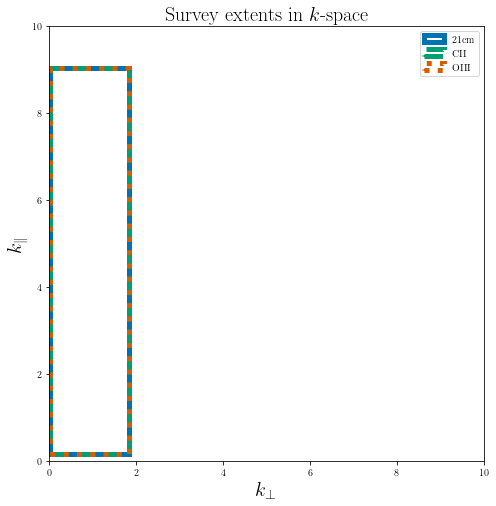

In [214]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1,1, figsize=(8, 8))

# Create a Rectangle patch
rect_21cm = patches.Rectangle((k_perp_min_21cm.value, k_para_min_21cm.value),
                                (k_perp_max_21cm.value - k_perp_min_21cm.value),
                                (k_para_max_21cm.value - k_para_min_21cm.value),
                              linewidth=5, edgecolor=colors[0], facecolor='none')

rect_CII = patches.Rectangle((k_perp_min_CII.value, k_para_min_CII.value),
                                (k_perp_max_CII.value - k_perp_min_CII.value),
                                (k_para_max_CII.value - k_para_min_CII.value),
                              linewidth=5, ls='--', edgecolor=colors[1], facecolor='none')

rect_OIII = patches.Rectangle((k_perp_min_OIII.value, k_para_min_OIII.value),
                                (k_perp_max_OIII.value - k_perp_min_OIII.value),
                                (k_para_max_OIII.value - k_para_min_OIII.value),
                              linewidth=5, ls=':', edgecolor=colors[2], facecolor='none')


# Add the patch to the Axes
ax.add_patch(rect_21cm)
ax.add_artist(rect_CII)
ax.add_artist(rect_OIII)

setup = ax.set(xlim=(0, 10), ylim=(0, 10), aspect=1)
x_l = ax.set_xlabel(r'$k_{\perp}$', fontsize=20)
y_l = ax.set_ylabel(r'$k_{\parallel}$', fontsize=20)

title = ax.set_title('Survey extents in $k$-space', fontsize=20)
leg = ax.legend(['21cm', 'CII', 'OIII'])

### Weighting function for smoothing power spectrum

Now we want to consider the fact that an instrument does have equal sensitivity at all values of $k$.

In [85]:
W_k_21cm = utils.calc_W_k(k_units, sigma_perp_21cm, sigma_para_21cm)
W_k_21cm

array([9.98769151e-01, 9.97795674e-01, 9.96054067e-01, 9.92942176e-01,
       9.87394479e-01, 9.77544466e-01, 9.60182238e-01, 9.29972950e-01,
       8.78610426e-01, 7.94781363e-01, 6.67424978e-01, 4.96351377e-01,
       3.08736699e-01, 1.56812547e-01, 7.03141272e-02, 2.99559920e-02,
       1.11837304e-02, 3.13905796e-03, 5.19471561e-04, 3.31033146e-05])

In [86]:
W_k_CII = utils.calc_W_k(k_units, sigma_perp_CII, sigma_para_CII)
W_k_CII

array([9.98769151e-01, 9.97795674e-01, 9.96054067e-01, 9.92942176e-01,
       9.87394479e-01, 9.77544466e-01, 9.60182238e-01, 9.29972950e-01,
       8.78610426e-01, 7.94781363e-01, 6.67424978e-01, 4.96351377e-01,
       3.08736699e-01, 1.56812547e-01, 7.03141272e-02, 2.99559920e-02,
       1.11837304e-02, 3.13905796e-03, 5.19471561e-04, 3.31033146e-05])

In [87]:
W_k_OIII = utils.calc_W_k(k_units, sigma_perp_OIII, sigma_para_OIII)
W_k_OIII

array([9.98769151e-01, 9.97795674e-01, 9.96054067e-01, 9.92942176e-01,
       9.87394479e-01, 9.77544466e-01, 9.60182238e-01, 9.29972950e-01,
       8.78610426e-01, 7.94781363e-01, 6.67424978e-01, 4.96351377e-01,
       3.08736699e-01, 1.56812547e-01, 7.03141272e-02, 2.99559920e-02,
       1.11837304e-02, 3.13905796e-03, 5.19471561e-04, 3.31033146e-05])

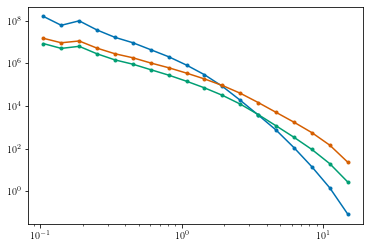

In [88]:
#plt.plot(k, W_k_CCATp, color='red')
plt.loglog(k[1:-1], pspecs_bt['P_21cm_21cm'][1:-1] * W_k_21cm[1:-1],
            color=colors[0], marker='.')

plt.loglog(k[1:-1], pspecs_bt['P_CII_CII'][1:-1] * W_k_CII[1:-1],
            color=colors[1], marker='.')

plt.loglog(k[1:-1], pspecs_bt['P_OIII_OIII'][1:-1] * W_k_OIII[1:-1],
            color=colors[2], marker='.')


#plt.axvline(1 / sigma_para_CCATp.to_value(), color='red', ls='--', alpha=.2)
# plt.axvline(1 / sigma_perp_FYST.to_value(), color='b')

### Current and future surveys

In [89]:
specs_CCATp = {'sigma_pix': 0.86 * (u.MJy * u.s**(1/2) / u.steradian),
               'N_det': 20 * u.dimensionless_unscaled,
               'theta_FWMH': 46.0 * u.arcsec,
               'nu_obs_min': 200.0 * u.GHz,
               'nu_obs_max': 300.0 * u.GHz,
               'delta_nu': 2.5 * u.GHz,
               't_obs': 3400 * u.hr,
               'Omega_surv': 1.7 * u.degree**2,
               'AGN Source': 'COSMOS'}

specs_HERA = {'sigma_pix': None,
               'N_det': None,
               'theta_FWMH': None,
               'nu_obs_min': 100.0 * u.GHz,
               'nu_obs_max': 200.0 * u.GHz,
               'delta_nu': 97.8 * u.kHz,
               't_obs': None,
               'Omega_surv': 1440 * u.degree**2,
               'AGN Source': None}

specs_StageII = {'sigma_pix': 0.21 * (u.MJy * u.s**(1/2) / u.steradian),
               'N_det': 16**4 * u.dimensionless_unscaled,
               'theta_FWMH': 30.1 * u.arcsec,
               'nu_obs_min': 200.0 * u.GHz,
               'nu_obs_max': 300.0 * u.GHz,
               'delta_nu': 0.4 * u.GHz,
               't_obs': 2000 * u.hr,
               'Omega_surv': 100.0 * u.degree**2,
               'AGN Source': 'DESI'}

specs_EXCLAIM = {'sigma_pix': 0.2 * (u.MJy * u.s**(1/2) / u.steradian),
               'N_det': 30 * u.dimensionless_unscaled,
               'theta_FWMH': None,
               'sigma_beam': utils.calc_sigma_beam(6, lambda_OIII, 3.0 * u.m),
               'B_nu': 40.0 * u.GHz,
               'nu_obs_min': 420.0 * u.GHz,
               'nu_obs_max': 540.0 * u.GHz,
               'delta_nu': 1000 * u.MHz,
               't_obs': 8.0 * u.hr,
               'Omega_surv': 100.0 * u.degree**2,
               'AGN Source': 'DESI'}


### Errors

Now we need to make sure our we have realistic estimated errors on our measurements.

In [90]:
V_survey_21cm = calc_V_survey(redshift, Omega_surv_21cm, B_21cm, nu_21cm)
V_survey_CII = calc_V_survey(redshift, Omega_surv_CII, B_CII, nu_CII)
V_survey_OIII = calc_V_survey(redshift, Omega_surv_OIII, B_21cm, nu_OIII)

V_vox_21cm = calc_V_vox(redshift, sigma_beam, delta_nu_21cm, nu_21cm)
V_vox_CII = calc_V_vox(redshift, sigma_beam, delta_nu_CII, nu_CII)
V_vox_OIII = calc_V_vox(redshift, sigma_beam, delta_nu_OIII, nu_OIII)

#### N modes check

In [91]:
N_modes = calc_N_modes(k, V_survey_21cm, align='left')
N_modes

array([9.76323026e-01, 2.34192812e+00, 5.61763592e+00, 1.34751503e+01,
       3.23231477e+01, 7.75342651e+01, 1.85983195e+02, 4.46122094e+02,
       1.07012315e+03, 2.56692860e+03, 6.15734966e+03, 1.47697738e+04,
       3.54285905e+04, 8.49833609e+04, 2.03851509e+05, 4.88983224e+05,
       1.17293511e+06, 2.81354598e+06, 6.74891635e+06])

In [92]:
V_survey_21cm / V_vox_21cm

<Quantity 23302456.36714852>

In [93]:
V_survey_CII / V_vox_CII 

<Quantity 23302456.36714853>

In [94]:
# Need to update with HERA
t_pix_21cm = calc_t_pix(specs_CCATp['N_det'], specs_CCATp['t_obs'],
                                                   Omega_surv_CII, sigma_beam)

t_pix_CII = calc_t_pix(specs_StageII['N_det'], specs_StageII['t_obs'],
                                                   Omega_surv_CII, sigma_beam)
t_pix_OIII = calc_t_pix(specs_EXCLAIM['N_det'], specs_EXCLAIM['t_obs'],
                                                   Omega_surv_OIII, sigma_beam)

P_N_21cm = calc_P_N(specs_StageII['sigma_pix'], V_vox_21cm, t_pix_21cm)
P_N_CII = calc_P_N(specs_StageII['sigma_pix'], V_vox_CII, t_pix_CII)
P_N_OIII = calc_P_N(specs_EXCLAIM['sigma_pix'], V_vox_OIII, t_pix_OIII)

N_modes = calc_N_modes(k, V_survey_21cm, align='left')

#sigma_21cm_CII = error_bars(P_21cm_CII[:-1], P_21cm_21cm[:-1], P_CII_CII[:-1],
#                                                P_N_21cm, W_k_21cm[:-1], N_modes) 

var_21cm_21cm = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_21cm_21cm[:-1], W_k_21cm[:-1],
                     P_N_21cm, P_N_21cm, P_21cm_21cm[:-1], N_modes)
var_CII_CII = var_x(P_CII_CII[:-1], W_k_CII[:-1], P_CII_CII[:-1], W_k_CII[:-1],
                     P_N_CII, P_N_CII, P_CII_CII[:-1], N_modes)
var_OIII_OIII = var_x(P_OIII_OIII[:-1], W_k_OIII[:-1], P_OIII_OIII[:-1], W_k_OIII[:-1],
                     P_N_OIII, P_N_OIII, P_OIII_OIII[:-1], N_modes)

var_21cm_CII = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_CII_CII[:-1], W_k_CII[:-1],
                     P_N_21cm, P_N_CII, P_21cm_CII[:-1], N_modes)
var_21cm_OIII = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_OIII_OIII[:-1], W_k_OIII[:-1],
                     P_N_21cm, P_N_OIII, P_21cm_OIII[:-1], N_modes)
var_CII_OIII = var_x(P_CII_CII[:-1], W_k_CII[:-1], P_OIII_OIII[:-1], W_k_OIII[:-1],
                     P_N_CII, P_N_OIII, P_CII_OIII[:-1], N_modes)

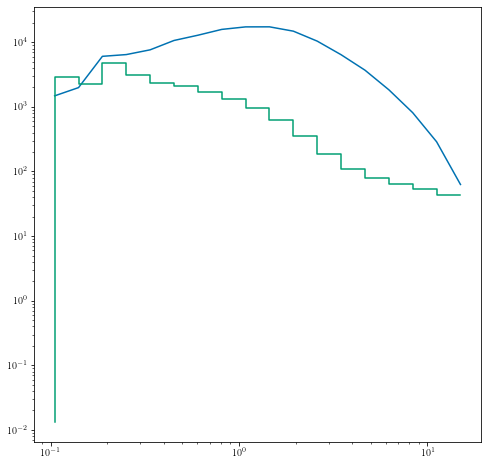

In [95]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * W_k_CII[1:-1])
           / (2 * np.pi**2))
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_CII[:-1])) / (2 * np.pi**2), 
                              drawstyle='steps')

# plt.ylim(1e2, 1e4)

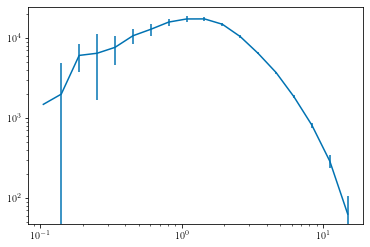

In [96]:
plt.errorbar(k[1:-1], k[1:-1]**3 * P_21cm_CII.value[1:-1] * W_k_21cm[1:-1] / (2 * np.pi**2),
                                         yerr=k[1:-1]**3 * np.sqrt(var_21cm_CII[:-1]).value / (2 * np.pi**2))

plt.xscale('log')
plt.yscale('log')

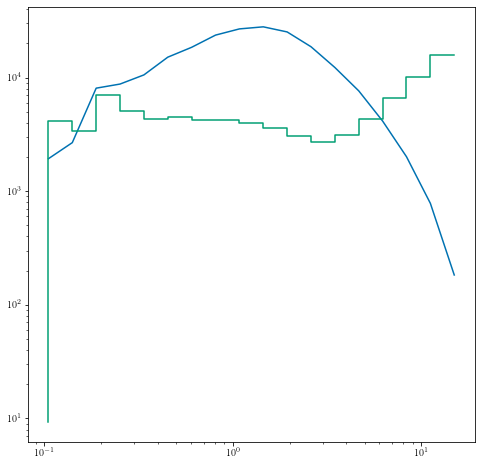

In [97]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_OIII[1:-1] * W_k_OIII[1:-1]).value / (2 * np.pi**2))
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_OIII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps')



### Comparing noise forecasts with Padmanabhan et al.

In [98]:
# this is just checking sigma / t_pix^(1/2) with Chung et al. (2020) for CCATp

t_pix_CCATp = calc_t_pix(specs_CCATp['N_det'], specs_CCATp['t_obs'],
                                        specs_CCATp['Omega_surv'],
                                        utils.FWHM_to_sigma(specs_CCATp['theta_FWMH']))


sig_t_pix_Chung = 6.2e3 * u.Jy / u.steradian
sig_t_pix_CCATp = specs_CCATp['sigma_pix'] / np.sqrt(t_pix_CCATp)


#### Hera specifications

In [100]:
#sigma_beam_HERA = utils.FWHM_to_sigma(specs_HERA['theta_FWMH'])
#V_surv_HERA = calc_V_survey(redshift, specs_HERA['Omega_surv'],
#                               specs_HERA['nu_obs_max'] - specs_HERA['nu_obs_min'],
#                                nu_CII)
#V_vox_HERA = calc_V_vox(redshift, sigma_beam_HERA, specs_HERA['delta_nu'], nu_CII)
#t_pix_HERA = calc_t_pix(specs_HERA['N_det'], specs_HERA['t_obs'],
#                                        specs_HERA['Omega_surv'],
#                                        sigma_beam_HERA)

#N_modes_HERA = calc_N_modes(k, V_surv_HERA, align='left')

#sigma_perp_HERA = utils.calc_sigma_perp(redshift, sigma_beam_HERA)
#sigma_para_HERA = utils.calc_sigma_para(redshift, nu_CII_obs, specs_HERA['delta_nu'])

#P_N_HERA = calc_P_N(specs_HERA['sigma_pix'], V_vox_HERA, t_pix_HERA)
#W_k_HERA = utils.calc_W_k(k_units, sigma_perp_HERA, sigma_para_HERA)

#var_auto_HERA = var_auto(P_CII_CII[:-1], W_k_HERA[:-1], P_N_HERA, N_modes_HERA)
#var_x_HERA = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_CII_CII[:-1], W_k_HERA[:-1], P_N_21cm,
#                     P_N_HERA, P_21cm_CII[:-1], N_modes_HERA)

#### CCAT-p specifications

In [101]:
sigma_beam_CCATp = utils.FWHM_to_sigma(specs_CCATp['theta_FWMH'])
V_surv_CCATp = calc_V_survey(redshift, specs_CCATp['Omega_surv'],
                               specs_CCATp['nu_obs_max'] - specs_CCATp['nu_obs_min'],
                                nu_CII)
V_vox_CCATp = calc_V_vox(redshift, sigma_beam_CCATp, specs_CCATp['delta_nu'], nu_CII)
t_pix_CCATp = calc_t_pix(specs_CCATp['N_det'], specs_CCATp['t_obs'],
                                        specs_CCATp['Omega_surv'],
                                        sigma_beam_CCATp)

N_modes_CCATp = calc_N_modes(k, V_surv_CCATp, align='left')

sigma_perp_CCATp = utils.calc_sigma_perp(redshift, sigma_beam_CCATp)
sigma_para_CCATp = utils.calc_sigma_para(redshift, nu_CII_obs, specs_CCATp['delta_nu'])

P_N_CCATp = calc_P_N(specs_CCATp['sigma_pix'], V_vox_CCATp, t_pix_CCATp)
W_k_CCATp = utils.calc_W_k(k_units, sigma_perp_CCATp, sigma_para_CCATp)

var_auto_CCATp = var_auto(P_CII_CII[:-1], W_k_CCATp[:-1], P_N_CCATp, N_modes_CCATp)
var_x_CCATp = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_CII_CII[:-1], W_k_CCATp[:-1], P_N_21cm,
                     P_N_CCATp, P_21cm_CII[:-1], N_modes_CCATp)

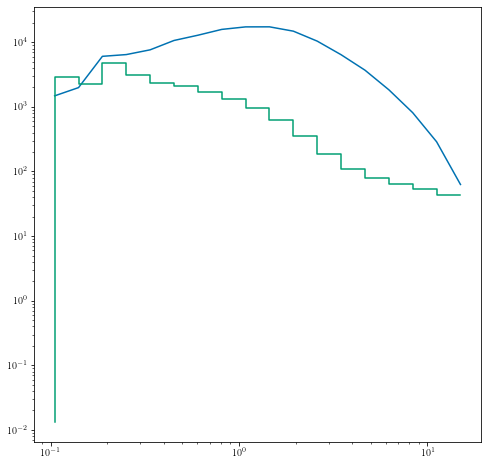

In [102]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * W_k_CII[1:-1]).value / (2 * np.pi**2))
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_CII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps')

#### FYST (or Stage II) specifications

In [103]:
sigma_beam_StageII = utils.FWHM_to_sigma(specs_StageII['theta_FWMH'])
V_surv_StageII = calc_V_survey(redshift, specs_StageII['Omega_surv'],
                               specs_StageII['nu_obs_max'] - specs_StageII['nu_obs_min'],
                                nu_CII)
V_vox_StageII = calc_V_vox(redshift, sigma_beam_StageII, specs_StageII['delta_nu'], nu_CII)
t_pix_StageII = calc_t_pix(specs_StageII['N_det'], specs_StageII['t_obs'],
                                        specs_StageII['Omega_surv'],
                                        sigma_beam_StageII)

N_modes_StageII = calc_N_modes(k, V_surv_StageII, align='left')

sigma_perp_StageII = utils.calc_sigma_perp(redshift, sigma_beam_StageII)
sigma_para_StageII = utils.calc_sigma_para(redshift, nu_CII_obs, specs_StageII['delta_nu'])

P_N_StageII = calc_P_N(specs_StageII['sigma_pix'], V_vox_StageII, t_pix_StageII)
W_k_StageII = utils.calc_W_k(k_units, sigma_perp_StageII, sigma_para_StageII)

var_auto_StageII = var_auto(P_CII_CII[:-1], W_k_StageII[:-1], P_N_StageII, N_modes_StageII)
var_x_StageII = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_CII_CII[:-1], W_k_StageII[:-1],
                      P_N_21cm, P_N_StageII, P_21cm_CII[:-1], N_modes_StageII)

In [104]:
V_surv_StageII / V_vox_StageII

<Quantity 1.9830217e+09>

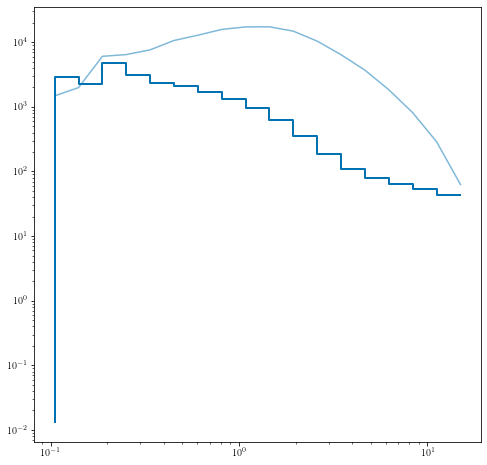

In [105]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * np.sqrt(W_k_CII[1:-1] 
                                                             * W_k_21cm[1:-1])).value / (2 * np.pi**2),
                                          color=colors[0], alpha=.5, label='idealized survey')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_CII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[0], lw=2)

(1, 1000000)

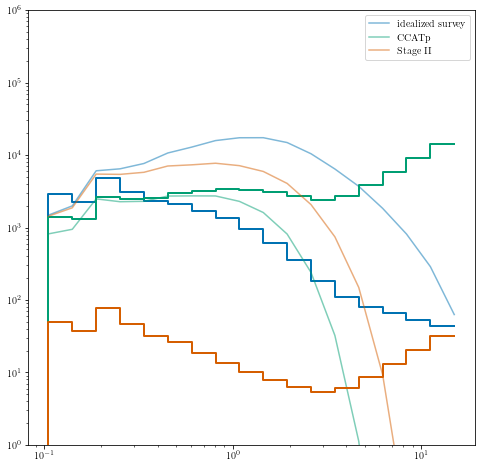

In [106]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * np.sqrt(W_k_CII[1:-1] 
                                                             * W_k_21cm[1:-1])).value / (2 * np.pi**2),
                                          color=colors[0], alpha=.5, label='idealized survey')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_CII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[0], lw=2)

plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * np.sqrt(W_k_CCATp[1:-1] 
                                                             * W_k_21cm[1:-1])).value / (2 * np.pi**2),
                                          color=colors[1], alpha=.5, label='CCATp')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_x_CCATp[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[1], lw=2)

plt.loglog(k[1:-1], (k[1:-1]**3 * P_21cm_CII[1:-1] * np.sqrt(W_k_StageII[1:-1] 
                                                             * W_k_21cm[1:-1])).value / (2 * np.pi**2),
                                          color=colors[2], alpha=.5, label='Stage II')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_x_StageII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[2], lw=2)

plt.legend()
plt.ylim(10**0, 10**6)

Text(0, 0.5, '$\\Delta^2 (k) \\times W(k) \\, [$ Jy/sr $]^2$')

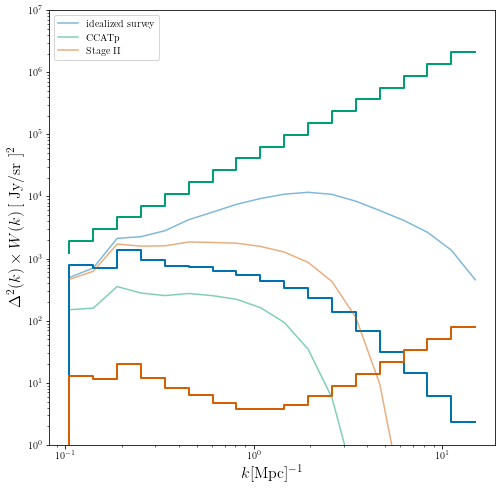

In [107]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_CII_CII[1:-1] * W_k_CII[1:-1]).value / (2 * np.pi**2),
                                          color=colors[0], alpha=.5, label='idealized survey')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_CII_CII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[0], lw=2)

plt.loglog(k[1:-1], (k[1:-1]**3 * P_CII_CII[1:-1] * W_k_CCATp[1:-1]).value / (2 * np.pi**2),
                                          color=colors[1], alpha=.5, label='CCATp')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_auto_CCATp[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[1], lw=2)

plt.loglog(k[1:-1], (k[1:-1]**3 * P_CII_CII[1:-1] * W_k_StageII[1:-1]).value / (2 * np.pi**2),
                                          color=colors[2], alpha=.5, label='Stage II')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_auto_StageII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[2], lw=2)

plt.legend()
plt.ylim(10**0, 10**7)
plt.xlabel(r'$k [$Mpc$]^{-1}$', fontsize=16)
plt.ylabel(r'$\Delta^2 (k) \times W(k) \, [$ Jy/sr $]^2$', fontsize=16)

#### EXCLAIM specifications

In [108]:
V_surv_EXCLAIM = calc_V_survey(redshift, specs_EXCLAIM['Omega_surv'],
                               specs_EXCLAIM['B_nu'],
                                nu_OIII)
V_vox_EXCLAIM = calc_V_vox(redshift, specs_EXCLAIM['sigma_beam'], specs_EXCLAIM['delta_nu'], nu_OIII)
t_pix_EXCLAIM = calc_t_pix(specs_EXCLAIM['N_det'], specs_EXCLAIM['t_obs'],
                                        specs_EXCLAIM['Omega_surv'],
                                        specs_EXCLAIM['sigma_beam'])
N_modes_EXCLAIM = calc_N_modes(k, V_surv_EXCLAIM, align='left')

sigma_perp_EXCLAIM = utils.calc_sigma_perp(redshift, specs_EXCLAIM['sigma_beam'])
sigma_para_EXCLAIM = utils.calc_sigma_para(redshift, nu_OIII_obs, specs_EXCLAIM['delta_nu'])

P_N_EXCLAIM = calc_P_N(specs_EXCLAIM['sigma_pix'], V_vox_EXCLAIM, t_pix_EXCLAIM)
W_k_EXCLAIM = utils.calc_W_k(k_units, sigma_perp_EXCLAIM, sigma_para_EXCLAIM)

var_auto_EXCLAIM = var_auto(P_OIII_OIII[:-1], W_k_EXCLAIM[:-1], P_N_EXCLAIM, N_modes_EXCLAIM)
var_x_EXCLAIM = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_OIII_OIII[:-1], W_k_EXCLAIM[:-1], P_N_21cm,
                     P_N_EXCLAIM, P_21cm_OIII[:-1], N_modes_EXCLAIM)

In [109]:
N_modes_EXCLAIM

array([6.91529593e+02, 1.65878767e+03, 3.97897148e+03, 9.54444885e+03,
       2.28944853e+04, 5.49175194e+04, 1.31731895e+05, 3.15988276e+05,
       7.57968221e+05, 1.81815551e+06, 4.36125072e+06, 1.04614307e+07,
       2.50940704e+07, 6.01937139e+07, 1.44388022e+08, 3.46346814e+08,
       8.30789933e+08, 1.99283460e+09, 4.78025740e+09])

Text(0, 0.5, '$\\Delta^2 (k) \\times W(k) \\, [$ Jy/sr $]^2$')

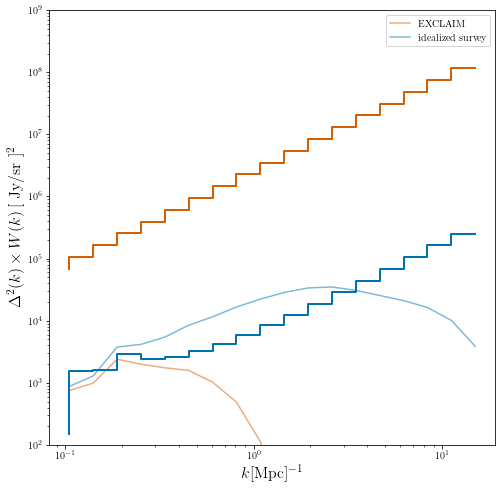

In [110]:
plt.figure(figsize=(8,8))
plt.loglog(k[1:-1], (k[1:-1]**3 * P_OIII_OIII[1:-1] * W_k_EXCLAIM[1:-1]).value / (2 * np.pi**2),
                                      color=colors[2], alpha=0.5, label='EXCLAIM')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_auto_EXCLAIM[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[2], lw=2)

plt.loglog(k[1:-1], (k[1:-1]**3 * P_OIII_OIII[1:-1] * W_k_OIII[1:-1]).value / (2 * np.pi**2),
                                      color=colors[0], alpha=0.5, label='idealized survey')
plt.loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_OIII_OIII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[0], lw=2)

plt.legend()
plt.ylim(1e2, 1e9)
plt.xlabel(r'$k [$Mpc$]^{-1}$', fontsize=16)
plt.ylabel(r'$\Delta^2 (k) \times W(k) \, [$ Jy/sr $]^2$', fontsize=16)

### Current and upcoming surveys

In [111]:
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatch
from matplotlib.patches import FancyBboxPatch

In [112]:
sigma_beam_CCATp = utils.FWHM_to_sigma(specs_CCATp['theta_FWMH']) # FWHM_to_sigma(46) #arcsec
sigma_perp_CCATp = utils.calc_sigma_perp(redshift, sigma_beam_CCATp)
sigma_para_CCATp = utils.calc_sigma_para(redshift, nu_CII_obs, specs_CCATp['delta_nu'])

In [113]:
def add_fancy_patch_around(ax, bb, **kwargs):
    fancy = FancyBboxPatch((bb.xmin, bb.ymin), bb.width, bb.height,
                           **kwargs)
    ax.add_patch(fancy)
    return fancy

def draw_control_points_for_patches(ax):
    for patch in ax.patches:
        patch.axes.plot(*patch.get_path().vertices.T, ".",
                        c=patch.get_edgecolor())
        
def plot_box(ax, k_perp_min, k_perp_max, k_para_min, k_para_max, color):
    # Bbox object around which the fancy box will be drawn.
    bb = mtransforms.Bbox([[k_perp_min, k_para_min], [k_perp_max, k_para_max]])


    # a fancy box with round corners. pad=0.1
    fancy = add_fancy_patch_around(ax, bb, boxstyle="round,pad=0.0",
                                alpha=.2, color=color)

In [114]:
sigma_beam_FYST = 1.22 * lambda_CII / (3 * u.m)

sigma_perp_FYST = utils.calc_sigma_perp(redshift, sigma_beam_FYST.decompose())
sigma_perp_HERA = utils.calc_sigma_perp(redshift, sigma_beam_FYST.decompose())
sigma_perp_CCATp = utils.calc_sigma_perp(redshift, utils.FWHM_to_sigma(specs_CCATp['theta_FWMH']))
sigma_perp_StageII = utils.calc_sigma_perp(redshift, utils.FWHM_to_sigma(specs_StageII['theta_FWMH']))
sigma_perp_EXCLAIM_1 = utils.calc_sigma_perp(redshift, specs_EXCLAIM['sigma_beam'])

sigma_para_FYST = utils.calc_sigma_para(redshift, nu_CII_obs, 300 * u.MHz)
sigma_para_HERA = utils.calc_sigma_para(redshift, nu_21cm_obs, specs_HERA['delta_nu'])
sigma_para_CCATp = utils.calc_sigma_para(redshift, nu_CII_obs, specs_CCATp['delta_nu'])
sigma_para_StageII = utils.calc_sigma_para(redshift, nu_CII_obs, specs_StageII['delta_nu'])
sigma_perp_EXCLAIM_1 = utils.calc_sigma_perp(redshift, specs_EXCLAIM['sigma_beam'])

In [115]:
L_perp_CCATp = (np.sqrt(Planck15.comoving_distance(redshift)**2 \
            * specs_CCATp['Omega_surv'])).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_CCATp = ((const.c / Planck15.H(redshift)) * (100 * u.GHz) \
          * (1 + redshift)**2 / nu_CII).to(u.Mpc)

L_perp_StageII = (np.sqrt(Planck15.comoving_distance(redshift)**2 \
            * specs_StageII['Omega_surv'])).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_StageII = ((const.c / Planck15.H(redshift)) * (100 * u.GHz) \
          * (1 + redshift)**2 / nu_CII).to(u.Mpc)

L_perp_HERA = (np.sqrt(Planck15.comoving_distance(redshift)**2 \
            * specs_HERA['Omega_surv'])).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_HERA = ((const.c / Planck15.H(redshift)) * (100 * u.MHz) \
          * (1 + redshift)**2 / nu_21cm).to(u.Mpc)

L_perp_EXCLAIM_1 = (np.sqrt(Planck15.comoving_distance(redshift)**2 \
            * (100 * u.degree**2))).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_EXCLAIM_1 = ((const.c / Planck15.H(redshift)) * (100 * u.GHz) \
          * (1 + redshift)**2 / nu_OIII).to(u.Mpc)

In [116]:
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']

In [117]:
L_perp_CCATp = (np.sqrt(Planck15.comoving_distance(redshift)**2 \
            * specs_CCATp['Omega_surv'])).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_CCATp = ((const.c / Planck15.H(redshift)) * (100 * u.GHz) \
          * (1 + redshift)**2 / nu_CII).to(u.Mpc)

L_perp_FYST = (np.sqrt(Planck15.comoving_distance(redshift)**2 \
            * (100 * u.degree**2))).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_FYST = ((const.c / Planck15.H(redshift)) * (100 * u.GHz) \
          * (1 + redshift)**2 / nu_CII).to(u.Mpc)

L_perp_FYST_2 = (np.sqrt(Planck15.comoving_distance(redshift)**2 \
            * (100 * u.degree**2))).to(u.Mpc, equivalencies=u.dimensionless_angles())
L_para_FYST_2 = ((const.c / Planck15.H(redshift)) * (100 * u.GHz) \
          * (1 + redshift)**2 / nu_CII).to(u.Mpc)

print(L_perp_CCATp, L_para_CCATp)
print(L_perp_FYST, L_para_FYST)
print(L_perp_FYST_2, L_para_FYST_2)

192.10383492771152 Mpc 1105.4606717141364 Mpc
1473.3691561286937 Mpc 1105.4606717141364 Mpc
1473.3691561286937 Mpc 1105.4606717141364 Mpc


In [118]:
print('CCATp:')
print(L_perp_CCATp, L_para_CCATp)

print('StageII:')
print(L_perp_StageII, L_para_StageII)

print('HERA:')
print(L_perp_HERA, L_para_HERA)

print('Box:')
print(box_size * u.Mpc, box_size * u.Mpc)

CCATp:
192.10383492771152 Mpc 1105.4606717141364 Mpc
StageII:
1473.3691561286937 Mpc 1105.4606717141364 Mpc
HERA:
5591.0428411282855 Mpc 1478.7209773703598 Mpc
Box:
80.0 Mpc 80.0 Mpc


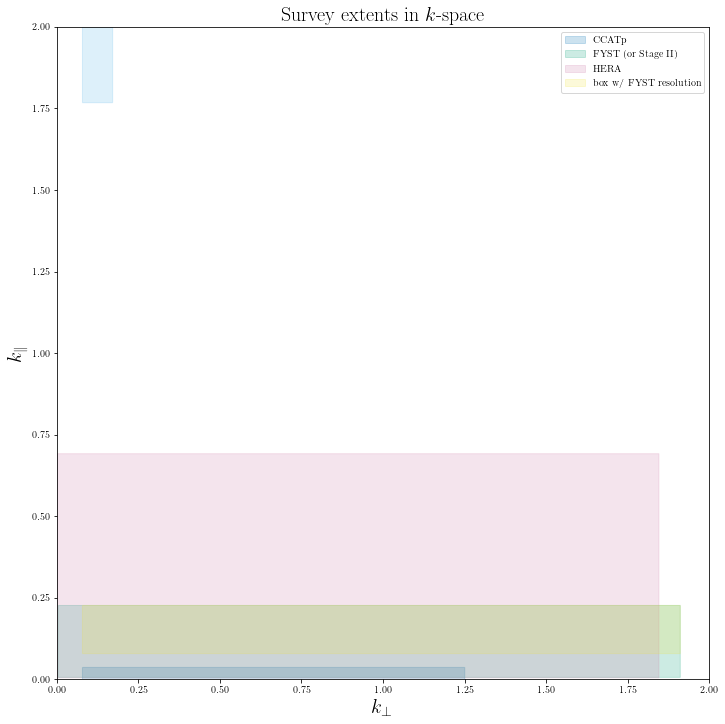

In [119]:
fig, ax = plt.subplots(1,1, figsize=(12, 12))

k_perp_min_CCATp = (2 * np.pi) / L_perp_21cm
k_perp_min_StageII = (2 * np.pi) / L_perp_StageII
k_perp_min_HERA = (2 * np.pi) / L_perp_HERA
k_perp_min_EXCLAIM_1 = (2 * np.pi) / L_perp_EXCLAIM_1
#k_perp_min_EXCLAIM_2 = (2 * np.pi) / L_perp_21cm

k_para_min_CCATp = (2 * np.pi) / L_para_21cm
k_para_min_StageII = (2 * np.pi) / L_para_StageII
k_para_min_HERA = (2 * np.pi) / L_para_HERA
k_para_min_EXCLAIM_1 = (2 * np.pi) / L_para_EXCLAIM_1
#k_para_min_EXCLAIM_2 = (2 * np.pi) / L_para_EXCLAIM_2

k_perp_max_CCATp = 1 / sigma_perp_CCATp
k_perp_max_StageII = 1 / sigma_perp_StageII
k_perp_max_HERA = 1 / sigma_perp_HERA
#k_perp_max_EXCLAIM_1 = 1 / sigma_perp_EXCLAIM_1
#k_perp_max_EXCLAIM_2 = 1 / sigma_perp_EXCLAIM_2

k_para_max_CCATp = 1 / sigma_para_CCATp
k_para_max_StageII = 1 / sigma_para_StageII
k_para_max_HERA = 1 / sigma_para_HERA
#k_perp_max_EXCLAIM_1 = 1 / sigma_para_EXCLAIM_1
#k_perp_max_EXCLAIM_2 = 1 / sigma_para_EXCLAIM_2

plot_box(ax, k_perp_min_CCATp.value, k_perp_max_CCATp.value,
                             k_para_min_CCATp.value, k_para_max_CCATp.value, colors[0])
plot_box(ax, k_perp_min_StageII.value, k_perp_max_StageII.value, 
                             k_para_min_StageII.value, k_para_max_StageII.value, colors[1])
#plot_box(ax, k_perp_min_box.value, k_perp_max_box.value, k_para_min_box.value,
#                             k_para_max_box.value, colors[2])
plot_box(ax, k_perp_min_HERA.value, k_perp_max_HERA.value,
                             k_para_min_HERA.value, k_para_max_HERA.value, colors[3])
plot_box(ax, k_perp_min_box.value, k_perp_max_StageII.value, k_para_min_box.value,
                     k_para_max_StageII.value, colors[4])

plot_box(ax, k_perp_min_OIII.value, k_para_min_OIII.value,
                                (k_perp_max_OIII - k_perp_min_OIII).value,
                                (k_para_max_OIII - k_para_min_OIII).value, colors[5])



setup = ax.set(xlim=(0, 2), ylim=(0, 2), aspect=1)
x_l = ax.set_xlabel(r'$k_{\perp}$', fontsize=20)
y_l = ax.set_ylabel(r'$k_{\parallel}$', fontsize=20)

title = ax.set_title('Survey extents in $k$-space', fontsize=20)
leg = ax.legend(['CCATp', 'FYST (or Stage II)', 'HERA', 'box w/ FYST resolution'])

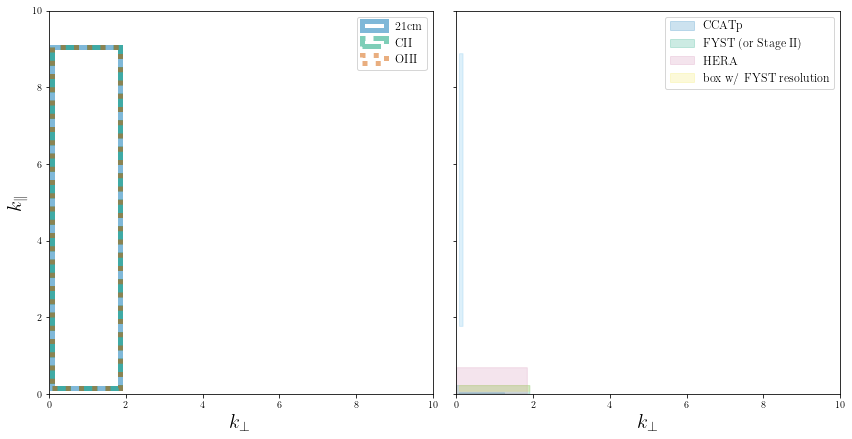

In [120]:
fig, ax = plt.subplots(1,2, figsize=(12, 6), sharey=True)

import matplotlib.patches as patches

# Create a Rectangle patch
rect_21cm = patches.Rectangle((k_perp_min_21cm.value, k_para_min_21cm.value),
                                (k_perp_max_21cm - k_perp_min_21cm).value,
                                (k_para_max_21cm - k_para_min_21cm).value,
                              linewidth=5, edgecolor=colors[0], facecolor='none',
                             alpha=.5)

rect_CII = patches.Rectangle((k_perp_min_CII.value, k_para_min_CII.value),
                                (k_perp_max_CII - k_perp_min_CII).value,
                                (k_para_max_CII - k_para_min_CII).value,
                              linewidth=5, ls='--', edgecolor=colors[1], facecolor='none',
                            alpha=.5)

rect_OIII = patches.Rectangle((k_perp_min_OIII.value, k_para_min_OIII.value),
                                (k_perp_max_OIII - k_perp_min_OIII).value,
                                (k_para_max_OIII - k_para_min_OIII).value,
                              linewidth=5, ls=':', edgecolor=colors[2], facecolor='none',
                             alpha=.5)


# Add the patch to the Axes
ax[0].add_patch(rect_21cm)
ax[0].add_artist(rect_CII)
ax[0].add_artist(rect_OIII)

setup = ax[0].set(xlim=(0, 10), ylim=(0, 10), aspect=1)
x_l = ax[0].set_xlabel(r'$k_{\perp}$', fontsize=20)
y_l = ax[0].set_ylabel(r'$k_{\parallel}$', fontsize=20)

leg = ax[0].legend(['21cm', 'CII', 'OIII'], fontsize=12)

k_perp_min_CCATp = (2 * np.pi) / L_perp_21cm
k_perp_min_StageII = (2 * np.pi) / L_perp_StageII
k_perp_min_HERA = (2 * np.pi) / L_perp_HERA
k_perp_min_EXCLAIM_1 = (2 * np.pi) / L_perp_EXCLAIM_1
#k_perp_min_EXCLAIM_2 = (2 * np.pi) / L_perp_21cm

k_para_min_CCATp = (2 * np.pi) / L_para_21cm
k_para_min_StageII = (2 * np.pi) / L_para_StageII
k_para_min_HERA = (2 * np.pi) / L_para_HERA
k_para_min_EXCLAIM_1 = (2 * np.pi) / L_para_EXCLAIM_1
#k_para_min_EXCLAIM_2 = (2 * np.pi) / L_para_EXCLAIM_2

k_perp_max_CCATp = 1 / sigma_perp_CCATp
k_perp_max_StageII = 1 / sigma_perp_StageII
k_perp_max_HERA = 1 / sigma_perp_HERA
#k_perp_max_EXCLAIM_1 = 1 / sigma_perp_EXCLAIM_1
#k_perp_max_EXCLAIM_2 = 1 / sigma_perp_EXCLAIM_2

k_para_max_CCATp = 1 / sigma_para_CCATp
k_para_max_StageII = 1 / sigma_para_StageII
k_para_max_HERA = 1 / sigma_para_HERA
#k_perp_max_EXCLAIM_1 = 1 / sigma_para_EXCLAIM_1
#k_perp_max_EXCLAIM_2 = 1 / sigma_para_EXCLAIM_2

plot_box(ax[1], k_perp_min_CCATp.value, k_perp_max_CCATp.value,
                             k_para_min_CCATp.value, k_para_max_CCATp.value, colors[0])
plot_box(ax[1], k_perp_min_StageII.value, k_perp_max_StageII.value, 
                             k_para_min_StageII.value, k_para_max_StageII.value, colors[1])
#plot_box(ax, k_perp_min_box.value, k_perp_max_box.value, k_para_min_box.value,
#                             k_para_max_box.value, colors[2])
plot_box(ax[1], k_perp_min_HERA.value, k_perp_max_HERA.value,
                             k_para_min_HERA.value, k_para_max_HERA.value, colors[3])
plot_box(ax[1], k_perp_min_box.value, k_perp_max_StageII.value, k_para_min_box.value,
                     k_para_max_StageII.value, colors[4])

plot_box(ax[1], k_perp_min_OIII.value, k_para_min_OIII.value,
                                (k_perp_max_OIII - k_perp_min_OIII).value,
                                (k_para_max_OIII - k_para_min_OIII).value, colors[5])



setup = ax[1].set(xlim=(0, 10), ylim=(0, 10), aspect=1)
x_l = ax[1].set_xlabel(r'$k_{\perp}$', fontsize=20)
x_l = ax[0].set_xlabel(r'$k_{\perp}$', fontsize=20)
y_l = ax[0].set_ylabel(r'$k_{\parallel}$', fontsize=20)

#title = ax.set_title('Survey extents in $k$-space', fontsize=20)
leg = ax[1].legend(['CCATp', 'FYST (or Stage II)', 'HERA', 'box w/ FYST resolution'], fontsize=12)

fig.tight_layout()

fig.savefig('survey_limits.pdf')

In [121]:
np.sqrt(k_perp_max_21cm**2 + k_perp_max_21cm**2), k_para_max_21cm

(<Quantity 2.61080907 1 / Mpc>, <Quantity 9.0460025 1 / Mpc>)

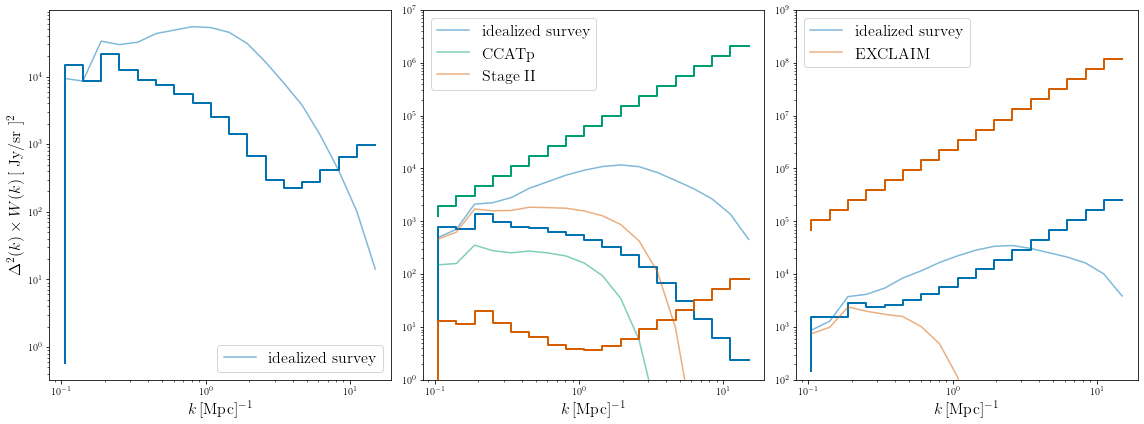

In [227]:
fig, ax = plt.subplots(1,3, figsize=(16, 6), sharex=True, sharey=False)


# 21cm
ax[0].loglog(k[1:-1], (k[1:-1]**3 * P_21cm_21cm[1:-1] * W_k_21cm[1:-1]).value / (2 * np.pi**2),
                                          color=colors[0], alpha=.5, label='idealized survey')
ax[0].loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_21cm_21cm[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[0], lw=2)
ax[0].legend(fontsize=16)
#ax[1].loglog(k[1:-1], (k[1:-1]**3 * P_21cm_21cm[1:-1] * W_k_HERA[1:-1]).value / (2 * np.pi**2),
#                                          color=colors[1], alpha=.5, label='CCATp')
#ax[1].loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_auto_HERA[:-1])).value / (2 * np.pi**2), 
#                              drawstyle='steps', color=colors[1], lw=2)


# CII
ax[1].loglog(k[1:-1], (k[1:-1]**3 * P_CII_CII[1:-1] * W_k_CII[1:-1]).value / (2 * np.pi**2),
                                          color=colors[0], alpha=.5, label='idealized survey')
ax[1].loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_CII_CII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[0], lw=2)

ax[1].loglog(k[1:-1], (k[1:-1]**3 * P_CII_CII[1:-1] * W_k_CCATp[1:-1]).value / (2 * np.pi**2),
                                          color=colors[1], alpha=.5, label='CCATp')
ax[1].loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_auto_CCATp[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[1], lw=2)

ax[1].loglog(k[1:-1], (k[1:-1]**3 * P_CII_CII[1:-1] * W_k_StageII[1:-1]).value / (2 * np.pi**2),
                                          color=colors[2], alpha=.5, label='Stage II')
ax[1].loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_auto_StageII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[2], lw=2)

ax[1].legend(fontsize=16)
ax[1].set_ylim(10**0, 10**7)


# OIII
ax[2].loglog(k[1:-1], (k[1:-1]**3 * P_OIII_OIII[1:-1] * W_k_OIII[1:-1]).value / (2 * np.pi**2),
                                      color=colors[0], alpha=0.5, label='idealized survey')
ax[2].loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_OIII_OIII[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[0], lw=2)

ax[2].loglog(k[1:-1], (k[1:-1]**3 * P_OIII_OIII[1:-1] * W_k_EXCLAIM[1:-1]).value / (2 * np.pi**2),
                                      color=colors[2], alpha=0.5, label='EXCLAIM')
ax[2].loglog(k[1:-1], (k[1:-1]**3 * np.sqrt(var_auto_EXCLAIM[:-1])).value / (2 * np.pi**2), 
                              drawstyle='steps', color=colors[2], lw=2)

ax[2].legend(fontsize=16)
plt.ylim(1e2, 1e9)
[axe.set_xlabel(r'$k \,[$Mpc$]^{-1}$', fontsize=16) for axe in ax] 
ax[0].set_ylabel(r'$\Delta^2 (k) \times W(k) \, [$ Jy/sr $]^2$', fontsize=16)

fig.tight_layout()

fig.savefig('auto_obs.pdf')

In [123]:
(k_perp_min_OIII.value, k_para_min_OIII.value), \
                                (k_perp_max_OIII - k_perp_min_OIII).value, \
                                (k_para_max_OIII - k_para_min_OIII)

((0.07853981633974483, 0.17115890395749955),
 1.7675809845523351,
 <Quantity 8.8748436 1 / Mpc>)

In [124]:
def calc_V_surv_generic_check(redshift, nu_rest, Omega_surv, B_nu):
    A_s = Omega_surv  
    B_nu = B_nu
    r = Planck15.comoving_distance(redshift)
    y = (const.c * (1 + redshift)**2) / (Planck15.H(redshift) * nu_rest)
    
    V = r**2 * y * A_s * B_nu * Planck15.h**3
    
    return V.to(u.Mpc**3, equivalencies=u.dimensionless_angles())

# Fitting

Now that we have our simulated data, and our survey specifications, we can now run our full simulations and recover the best fit parameters.

## Cases 

Let's investigate a series of different scenarios. Let's start idealized and then progress one step at a time.

Let's initialize our simulations with the desired specifications.  Let's set three different noise levels: optimistic, conservative, pessimistic.

In [581]:
k_indices = [6]
p_names = np.asarray(['b_i','b_j', 'b_k', 'P_m'])

frac_op = 1e-10
frac_con = .1
frac_pess = .15

var_21cm_21cm = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_21cm_21cm[:-1], W_k_21cm[:-1],
                     P_N_21cm, P_N_21cm, P_21cm_21cm[:-1], N_modes)
var_CII_CII = var_x(P_CII_CII[:-1], W_k_CII[:-1], P_CII_CII[:-1], W_k_CII[:-1],
                     P_N_CII, P_N_CII, P_CII_CII[:-1], N_modes)
var_OIII_OIII = var_x(P_OIII_OIII[:-1], W_k_OIII[:-1], P_OIII_OIII[:-1], W_k_OIII[:-1],
                     P_N_OIII, P_N_OIII, P_OIII_OIII[:-1], N_modes)

var_21cm_CII = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_CII_CII[:-1], W_k_CII[:-1],
                     P_N_21cm, P_N_CII, P_21cm_CII[:-1], N_modes)
var_21cm_OIII = var_x(P_21cm_21cm[:-1], W_k_21cm[:-1], P_OIII_OIII[:-1], W_k_OIII[:-1],
                     P_N_21cm, P_N_OIII, P_21cm_OIII[:-1], N_modes)

#variances = [var_21cm_21cm, var_21cm_CII, var_21cm_OIII, var_CII_OIII, model_params_sf['b_i'] * .25]

#### Least Square Estimators

We first want to fit our data using our least squares formalism,

We want these results in our original parameterization.  The standard expression for the propagation of uncertainty is given by,

$\sigma_f = \sqrt{\left( \frac{\partial f}{\partial x} \right)^2 \sigma_x^2}$

We have two cases:

1) a parameter that looks like $b = e^{i \eta}$,

then,
$\sigma_b = \sqrt{\left( \frac{\partial f(\eta)}{\partial \eta} \right)^2 \sigma_\eta^2}$

$= \sqrt{\left( \frac{\partial}{\partial \eta} e^{\eta} \right)^2 \sigma_\eta^2}$

$= \sqrt{ \left( e^{\eta} \right)^2 \sigma_\eta^2}$

$\sigma_b = e^{\eta} \eta$

2) fitting $\ln{P_m}$ in lieu of $P_m$,

with $f(x) = e^x$ and $x=\ln{P_m}$, yielding,

$\sigma_{P_m} = \sqrt{\left( \frac{\partial }{\partial(\ln{P_m})}\left[ e^{\ln{P_m}} \right] \right)^2 \sigma_{\ln{P_m}}^2} $

$= \sqrt{\left(e^{\ln{P_m}}\right)^2 \sigma_{\ln{P_m}}^2}$
$= \sqrt{P^2_m \sigma_{\ln{P_m}}^2}$

$\sigma_{P_m} = P_m \sigma_{\ln{P_m}}$

### Superfake data and superfake noise levels

In [586]:
biases_sf = utils.extract_bias(k_indices, spectra_sf[1], P_m)
p_vals_sf = np.asarray([*biases_sf, P_m], dtype=object)

params_sf = dict(zip(p_names, p_vals_sf))
ndim = utils.choose_params(params_sf, k_indices).size

spectra_sf_op, std_sf_op = analysis.noisey_spectra(spectra_sf[1], frac_error=frac_op)
spectra_sf_con, std_sf_con = analysis.noisey_spectra(spectra_sf[1], frac_error=frac_con)
spectra_sf_pess, std_sf_pess = analysis.noisey_spectra(spectra_sf[1], frac_error=frac_pess)

data_sf = utils.fetch_data(k_indices, spectra_sf[1],
                           b_0=params_sf['b_i'])
data_sf_op = utils.fetch_data(k_indices, spectra_sf_op,
                           b_0=params_sf['b_i'])
data_sf_con = utils.fetch_data(k_indices, spectra_sf_con,
                           b_0=params_sf['b_i'])
data_sf_pess = utils.fetch_data(k_indices, spectra_sf_pess,
                           b_0=params_sf['b_i'])

model_auto = models.ScalarBias(k=spectra_sf[0], params=params_sf)
model = models.ScalarBias_crossonly(k=spectra_sf[0], params=params_sf)

#N_op = analysis.estimate_errors(data_sf, frac_error=frac_op)
# N_con = analysis.estimate_errors(data_sf, frac_error=frac_con)
# N_pess = analysis.estimate_errors(data_sf, frac_error=frac_pess)


# CAREFUL! First is var, second is std
N_sf_op, n_sf_op = analysis.get_noise(k_indices, std_sf_op, params_sf['b_i'])
N_sf_con, n_sf_con = analysis.get_noise(k_indices, std_sf_con, params_sf['b_i'])
N_sf_pess, n_sf_pess = analysis.get_noise(k_indices, std_sf_pess, params_sf['b_i'])

#N = analysis.create_noise_matrix(k_indices, variances)

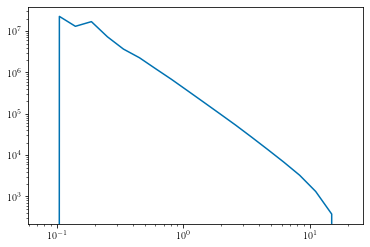

In [587]:
plt.loglog(k, spectra_sf[1][0])

In [545]:
realizations = 3
noises = np.linspace(.005, .25, 10)
noises

array([0.005     , 0.03222222, 0.05944444, 0.08666667, 0.11388889,
       0.14111111, 0.16833333, 0.19555556, 0.22277778, 0.25      ])

In [546]:
Beanes_sf = np.zeros((len(noises), realizations, 2))
MCMCs_sf = np.zeros((len(noises), realizations, 2))

In [547]:
Beanes_pl = np.zeros((len(noises), realizations, 2))
MCMCs_pl = np.zeros((len(noises), realizations, 2))

In [548]:
Beanes_bt = np.zeros((len(noises), realizations, 2))
MCMCs_bt = np.zeros((len(noises), realizations, 2))

In [549]:
P_ij = spectra_sf[1][1][k_indices]
P_jk = spectra_sf[1][4][k_indices]
P_ik = spectra_sf[1][2][k_indices]

P_ii_Beane = (P_ij * P_ik) / P_jk

for i, noise in enumerate(noises):
    print('ON: ', 1)
    for j in range(realizations):
            spectra, std = analysis.noisey_spectra(spectra_sf[1], frac_error=noise)
            data = utils.fetch_data(k_indices, spectra, b_0=params_sf['b_i'])
            N, n = analysis.get_noise(k_indices, std, params_sf['b_i'])

            Beane = fitting.Beane_et_al(spectra, n[0], n[1], n[2], N_modes, k_indices)
            MCMC = fitting.MCMC_results(params_sf, k_indices, data, model, N, nsteps=1e5)
       
    
            P_ii_samples = analysis.add_P(MCMC[0], k_indices, (0,0))
            ind = MCMC[1][0:-1:100].argmax()

            Beanes_sf[i,j] = Beane[0][k_indices], Beane[1][k_indices] 
            MCMCs_sf[i,j] = P_ii_samples[ind][-1], np.std(P_ii_samples[-1])

ON:  1
PARAMS:  {'b_i': 478.231182600188, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}
DATA:  [1457468.11369393 1324842.61093814 2074012.1329184 ]
NOISE:  [5.33518123e+07 4.45417863e+07 1.06985109e+08]
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior width is:  0.25
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized


/Users/lisaleemcb/Documents/Physics/Research/deprism/fitting.py:345: RuntimeWarning: invalid value encountered in true_divide
  P_ii = P_ij * P_ik / P_jk
/Users/lisaleemcb/Documents/Physics/Research/deprism/analysis.py:214: RuntimeWarning: invalid value encountered in true_divide
  - (P_ij * P_ik**2 / P_jk**3) * (P_jj_tot * P_ik + P_ij * P_jk) \
/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


PARAMS:  {'b_i': 478.231182600188, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}
DATA:  [1451699.69523874 1332982.85957247 2062541.22235823]
NOISE:  [5.33518123e+07 4.45417863e+07 1.06985109e+08]
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior width is:  0.25
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized
PARAMS:  {'b_i': 478.231182600188, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
   

ON:  1
PARAMS:  {'b_i': 478.231182600188, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}
DATA:  [1495048.745751   1251168.35720224 1805279.30473792]
NOISE:  [2.76803693e+10 2.31094885e+10 5.55067804e+10]
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior width is:  0.25
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized
PARAMS:  {'b_i': 478.231182600188, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+

PARAMS:  {'b_i': 478.231182600188, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}
DATA:  [ 971535.59290971 1707169.16441451 1752029.58012934]
NOISE:  [8.16111476e+10 6.81346356e+10 1.63652876e+11]
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior width is:  0.25
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized
ON:  1
PARAMS:  {'b_i': 478.231182600188, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+

In [550]:
P_ij = spectra_pl[1][1][k_indices]
P_jk = spectra_pl[1][4][k_indices]
P_ik = spectra_pl[1][2][k_indices]

P_ii_Beane = (P_ij * P_ik) / P_jk

for i, noise in enumerate(noises):
    print('ON: ', i)
    for j in range(realizations):
            spectra, std = analysis.noisey_spectra(spectra_pl[1], frac_error=noise)
            data = utils.fetch_data(k_indices, spectra, b_0=params_pl['b_i'])
            N, n = analysis.get_noise(k_indices, std, params_pl['b_i'])

            Beane = fitting.Beane_et_al(spectra, n[0], n[1], n[2], N_modes, k_indices)
            MCMC = fitting.MCMC_results(params_pl, k_indices, data, model, N, nsteps=1e5)
       
    
            P_ii_samples = analysis.add_P(MCMC[0], k_indices, (0,0))
            ind = MCMC[1][0:-1:100].argmax()

            Beanes_pl[i,j] = Beane[0][k_indices], Beane[1][k_indices] 
            MCMCs_pl[i,j] = P_ii_samples[ind][-1], np.std(P_ii_samples[-1])

ON:  0
PARAMS:  {'b_i': 478.231182600188, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}
DATA:  [1398493.17745246 1316038.77289198 2037006.61776376]
NOISE:  [4.86747374e+07 4.38352146e+07 1.03103227e+08]
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior width is:  0.25
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized


/Users/lisaleemcb/Documents/Physics/Research/deprism/analysis.py:214: RuntimeWarning: invalid value encountered in true_divide
  - (P_ij * P_ik**2 / P_jk**3) * (P_jj_tot * P_ik + P_ij * P_jk) \
/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


PARAMS:  {'b_i': 478.231182600188, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}
DATA:  [1402275.55601247 1326442.30216704 2032371.33734545]
NOISE:  [4.86747374e+07 4.38352146e+07 1.03103227e+08]
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior width is:  0.25
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized
PARAMS:  {'b_i': 478.231182600188, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
   

ON:  4
PARAMS:  {'b_i': 478.231182600188, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}
DATA:  [1467677.18434637 1364492.21330884 1867393.85617041]
NOISE:  [2.52537758e+10 2.27428999e+10 5.34927543e+10]
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior width is:  0.25
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized
PARAMS:  {'b_i': 478.231182600188, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+

PARAMS:  {'b_i': 478.231182600188, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}
DATA:  [1939244.02544332 1412366.82425914 1536167.84008583]
NOISE:  [7.44567242e+10 6.70538078e+10 1.57714842e+11]
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior width is:  0.25
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized
ON:  8
PARAMS:  {'b_i': 478.231182600188, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+

In [551]:
P_ij = spectra_bt[1][1][k_indices]
P_jk = spectra_bt[1][4][k_indices]
P_ik = spectra_bt[1][2][k_indices]

P_ii_Beane = (P_ij * P_ik) / P_jk

for i, noise in enumerate(noises):
    for j in range(realizations):
            spectra, std = analysis.noisey_spectra(spectra_bt[1], frac_error=noise)
            data = utils.fetch_data(k_indices, spectra, b_0=params_bt['b_i'])
            N, n = analysis.get_noise(k_indices, std, params_bt['b_i'])

            Beane = fitting.Beane_et_al(spectra, n[0], n[1], n[2], N_modes, k_indices)
            MCMC = fitting.MCMC_results(params_bt, k_indices, data, model, N, nsteps=1e5)
       
    
            P_ii_samples = analysis.add_P(MCMC[0], k_indices, (0,0))
            ind = MCMC[1][0:-1:100].argmax()

            Beanes_bt[i,j] = Beane[0][k_indices], Beane[1][k_indices] 
            MCMCs_bt[i,j] = P_ii_samples[ind][-1], np.std(P_ii_samples[-1])

PARAMS:  {'b_i': 984.7775777508956, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}
DATA:  [2382385.24716882 1322289.62748552 3372954.9467043 ]
NOISE:  [1.41110371e+08 4.38352146e+07 2.83902066e+08]
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior width is:  0.25
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized


/Users/lisaleemcb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


PARAMS:  {'b_i': 984.7775777508956, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}
DATA:  [2401160.62137753 1332092.30510628 3359428.90280936]
NOISE:  [1.41110371e+08 4.38352146e+07 2.83902066e+08]
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior width is:  0.25
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized
PARAMS:  {'b_i': 984.7775777508956, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
 

PARAMS:  {'b_i': 984.7775777508956, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}
DATA:  [2220023.48967863 1470471.74886902 3207583.2065293 ]
NOISE:  [7.32118931e+10 2.27428999e+10 1.47296103e+11]
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior width is:  0.25
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized
PARAMS:  {'b_i': 984.7775777508956, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
 

PARAMS:  {'b_i': 984.7775777508956, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}
DATA:  [2501941.61372449 1133354.76528274 3230868.65180998]
NOISE:  [2.15853573e+11 6.70538078e+10 4.34279032e+11]
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior width is:  0.25
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized
PARAMS:  {'b_i': 984.7775777508956, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
 

In [277]:
def frac_diff(data, truth):
    data = np.asarray(data)
    truth = np.asarray(truth)
    
    return (data - truth) / truth

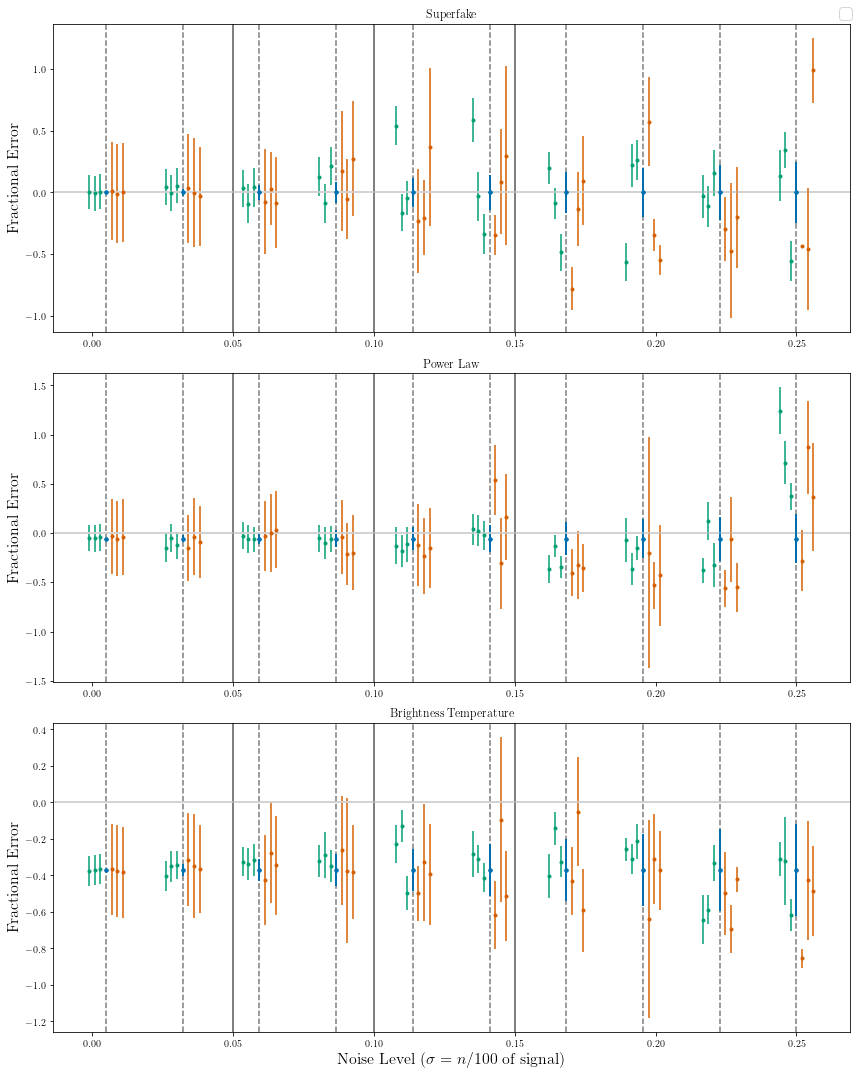

In [556]:
fig, ax = plt.subplots(3,1, figsize=(12,15))

for i in range(len(noises)):
    for j in range(realizations):
        P_ij = spectra_sf[1][1][k_indices]
        P_jk = spectra_sf[1][4][k_indices]
        P_ik = spectra_sf[1][2][k_indices]

        P_ii_Beane = (P_ij * P_ik) / P_jk

        ax[0].axvline(frac_op, color='gray', alpha=.2)
        ax[0].axvline(frac_con, alpha=.2, color='gray')
        ax[0].axvline(frac_pess, alpha=.2, color='gray')

        ax[0].axvline(noises[i], alpha=.2, color='black', ls='--')
        ax[0].axhline(0, alpha=.2, color='lightgray')

        ax[0].errorbar(noises[i], frac_diff(P_ii_Beane, spectra_sf[1][0][k_indices]),
                       yerr=noises[i], color=colors[0], marker='.')

        ax[0].errorbar(noises[i] -.002 - .002 * j, frac_diff(Beanes_sf[i][j][0], 
                                                   spectra_sf[1][0][k_indices]),
                ls='', marker='.',
               yerr=np.sqrt(Beanes_sf[i][j][1]) / spectra_sf[1][0][k_indices],
               color=colors[1])
        ax[0].errorbar(noises[i] + 0.002 + .002 * j, frac_diff(MCMCs_sf[i][j][0], spectra_sf[1][0][k_indices]),
               ls='', marker='.', yerr=MCMCs_sf[i][j][1] / spectra_sf[1][0][k_indices], color=colors[2])
        

for i in range(len(noises)):
    for j in range(realizations):
        P_ij = spectra_pl[1][1][k_indices]
        P_jk = spectra_pl[1][4][k_indices]
        P_ik = spectra_pl[1][2][k_indices]

        P_ii_Beane = (P_ij * P_ik) / P_jk

        ax[1].axvline(frac_op, color='gray', alpha=.2)
        ax[1].axvline(frac_con, alpha=.2, color='gray')
        ax[1].axvline(frac_pess, alpha=.2, color='gray')

        ax[1].axvline(noises[i], alpha=.2, color='black', ls='--')
        ax[1].axhline(0, alpha=.2, color='lightgray')

        ax[1].errorbar(noises[i], frac_diff(P_ii_Beane, spectra_pl[1][0][k_indices]),
                       yerr=noises[i], color=colors[0], marker='.')
        
        ax[1].errorbar(noises[i] -.002 - .002 * j, frac_diff(Beanes_pl[i][j][0], 
                                                   spectra_pl[1][0][k_indices]),
                ls='', marker='.',
               yerr=np.sqrt(Beanes_pl[i][j][1]) / spectra_pl[1][0][k_indices],
               color=colors[1])
        ax[1].errorbar(noises[i] + 0.002 + .002 * j, frac_diff(MCMCs_pl[i][j][0], spectra_pl[1][0][k_indices]),
               ls='', marker='.', yerr=MCMCs_pl[i][j][1] / spectra_pl[1][0][k_indices], color=colors[2])
        

for i in range(len(noises)):
    for j in range(realizations):
        P_ij = spectra_bt[1][1][k_indices]
        P_jk = spectra_bt[1][4][k_indices]
        P_ik = spectra_bt[1][2][k_indices]

        P_ii_Beane = (P_ij * P_ik) / P_jk

        ax[2].axvline(frac_op, color='gray', alpha=.2)
        ax[2].axvline(frac_con, alpha=.2, color='gray')
        ax[2].axvline(frac_pess, alpha=.2, color='gray')

        ax[2].axvline(noises[i], alpha=.2, color='black', ls='--')
        ax[2].axhline(0, alpha=.2, color='lightgray')

        ax[2].errorbar(noises[i], frac_diff(P_ii_Beane, spectra_bt[1][0][k_indices]),
                       yerr=noises[i], color=colors[0], marker='.')
        
        ax[2].errorbar(noises[i] -.002 - .002 * j, frac_diff(Beanes_bt[i][j][0], 
                                                   spectra_bt[1][0][k_indices]),
                ls='', marker='.',
               yerr=np.sqrt(Beanes_bt[i][j][1]) / spectra_bt[1][0][k_indices],
               color=colors[1])
        ax[2].errorbar(noises[i] + 0.002 + .002 * j, frac_diff(MCMCs_bt[i][j][0], spectra_bt[1][0][k_indices]),
               ls='', marker='.', yerr=MCMCs_bt[i][j][1] / spectra_bt[1][0][k_indices], color=colors[2])
        
ax[2].set_xlabel(r'Noise Level ($\sigma = n/100$ of signal)', fontsize=16)
[ax[i].set_ylabel('Fractional Error', fontsize=16) for i in range(3)]

ax[0].set_title('Superfake')
ax[1].set_title('Power Law')
ax[2].set_title('Brightness Temperature')
    
fig.legend(fontsize=16)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,15))

for i in range(len(noises)):
    for j in range(realizations):
        P_ij = spectra_sf[1][1][k_indices]
        P_jk = spectra_sf[1][4][k_indices]
        P_ik = spectra_sf[1][2][k_indices]

        P_ii_Beane = (P_ij * P_ik) / P_jk

        ax[0].axvline(frac_op, color='gray', alpha=.2)
        ax[0].axvline(frac_con, alpha=.2, color='gray')
        ax[0].axvline(frac_pess, alpha=.2, color='gray')

        ax[0].axvline(noises[i], alpha=.2, color='black', ls='--')
        ax[0].axhline(0, alpha=.2, color='lightgray')

        ax[0].errorbar(noises[i], frac_diff(P_ii_Beane, spectra_sf[1][0][k_indices]),
                       yerr=noises[i], color=colors[0], marker='.')

        ax[0].errorbar(noises[i] - .002, frac_diff(Beanes_sf[i][realizations][0], 
                                                   spectra_sf[1][0][k_indices]),
                ls='', marker='.',
               yerr=np.sqrt(Beanes_sf[i][realizations][1][k_indices]) / spectra_sf[1][0][k_indices],
               color=colors[1])
        ax[0].errorbar(noises[i] + .002, frac_diff(MCMCs_pl[i][realizations][0], spectra_sf[1][0][k_indices]),
               ls='', marker='.', yerr=MCMCs_sf[i][realizations][1] / spectra_sf[1][0][k_indices], color=colors[2])

for i in range(len(noises)):
    P_ij = spectra_pl[1][1][k_indices]
    P_jk = spectra_pl[1][4][k_indices]
    P_ik = spectra_pl[1][2][k_indices]

    P_ii_Beane = (P_ij * P_ik) / P_jk
    P_ii_samples = analysis.add_P(MCMCs_pl[i][0], k_indices, (0,0))
    ind = MCMCs_pl[0][1][0:-1:100].argmax()
    
    ax[1].axvline(frac_op, color='gray', alpha=.2)
    ax[1].axvline(frac_con, alpha=.2, color='gray')
    ax[1].axvline(frac_pess, alpha=.2, color='gray')
    
    ax[1].axvline(noises[i], alpha=.2, color='black', ls='--')
    ax[1].axhline(0, alpha=.2, color='lightgray')
    
    ax[1].errorbar(noises[i], frac_diff(P_ii_Beane, spectra_pl[1][0][k_indices]),
                   yerr=noises[i], color=colors[0], marker='.')

    ax[1].errorbar(noises[i] - .002, frac_diff(Beanes_pl[i][realizations][0], spectra_pl[1][0][k_indices]),
           ls='', marker='.', yerr=np.sqrt(Beanes_pl[i][realizations][1]) / Beanes_pl[i][0][k_indices], color=colors[1])
    ax[1].errorbar(noises[i] + .002, frac_diff(MCMCs_pl[i][realizations][0], spectra_pl[1][0][k_indices]),
           ls='', marker='.', yerr=np.std(P_ii_samples[-1]) / spectra_pl[1][0][k_indices], color=colors[2])
    
for i in range(len(noises)):
    P_ij = spectra_bt[1][1][k_indices]
    P_jk = spectra_bt[1][4][k_indices]
    P_ik = spectra_bt[1][2][k_indices]

    P_ii_Beane = (P_ij * P_ik) / P_jk
    P_ii_samples = analysis.add_P(MCMCs_bt[i][0], k_indices, (0,0))
    ind = MCMCs_bt[0][1][0:-1:100].argmax()
    
    ax[2].axvline(frac_op, color='gray', alpha=.2)
    ax[2].axvline(frac_con, alpha=.2, color='gray')
    ax[2].axvline(frac_pess, alpha=.2, color='gray')
    
    ax[2].axvline(noises[i], alpha=.2, color='black', ls='--')
    ax[2].axhline(0, alpha=.2, color='lightgray')
    
    ax[2].errorbar(noises[i], frac_diff(P_ii_Beane, spectra_bt[1][0][k_indices]),
                   yerr=noises[i], color=colors[0], marker='.', label='noiseless Beane' if i == 0 else "")

    ax[2].errorbar(noises[i] - .002, frac_diff(Beanes_bt[i][0][k_indices], spectra_bt[1][0][k_indices]),
           ls='', marker='.', yerr=np.sqrt(Beanes_bt[i][1][k_indices]) / spectra_bt[1][0][k_indices],
                   color=colors[1], label='Beane' if i == 0 else "")
    ax[2].errorbar(noises[i] + .002, frac_diff(P_ii_samples[ind][-1], spectra_bt[1][0][k_indices]),
           ls='', marker='.', yerr=np.std(P_ii_samples[-1]) / spectra_bt[1][0][k_indices], color=colors[2], label='MCMC' if i == 0 else "")

ax[2].set_xlabel(r'Noise Level ($\sigma = n/100$ of signal)', fontsize=16)
[ax[i].set_ylabel('Fractional Error', fontsize=16) for i in range(3)]

ax[0].set_title('Superfake')
ax[1].set_title('Power Law')
ax[2].set_title('Brightness Temperature')
    
fig.legend(fontsize=16)
fig.tight_layout()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

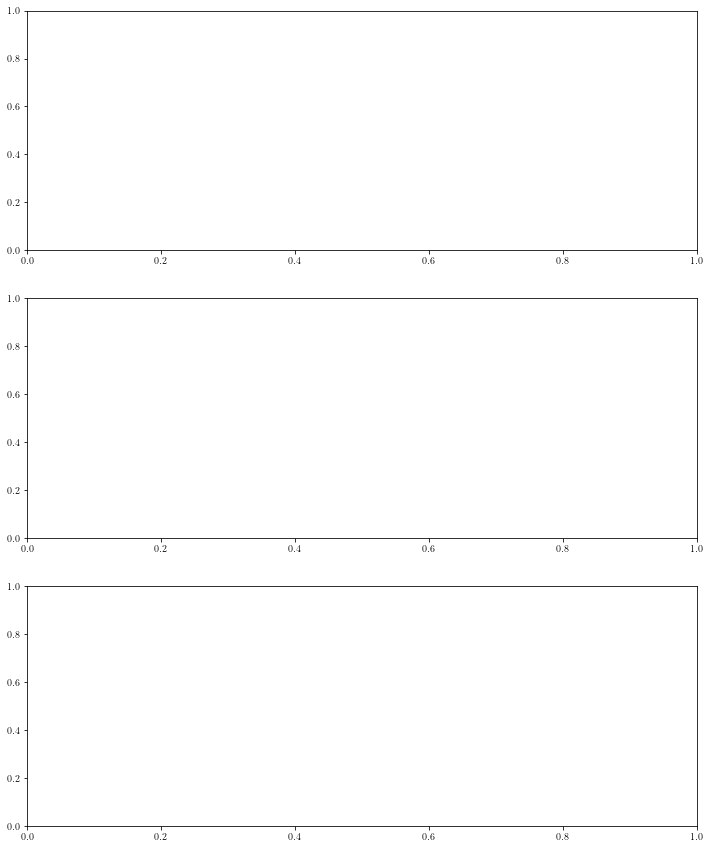

In [487]:
fig, ax = plt.subplots(3,1, figsize=(12,15))

for i in range(len(noises)):
    P_ij = spectra_sf[1][1][k_indices]
    P_jk = spectra_sf[1][4][k_indices]
    P_ik = spectra_sf[1][2][k_indices]

    P_ii_Beane = (P_ij * P_ik) / P_jk
    P_ii_samples = analysis.add_P(MCMCs_sf[i][0], k_indices, (0,0))
    ind = MCMCs_sf[0][1][0:-1:100].argmax()
    
    ax[0].axvline(frac_op, color='gray', alpha=.2)
    ax[0].axvline(frac_con, alpha=.2, color='gray')
    ax[0].axvline(frac_pess, alpha=.2, color='gray')
    
    ax[0].axvline(noises[i], alpha=.2, color='black', ls='--')
    ax[0].axhline(0, alpha=.2, color='lightgray')
    
    ax[0].errorbar(noises[i], frac_diff(P_ii_Beane, spectra_sf[1][0][k_indices]),
                   yerr=noises[i], color=colors[0], marker='.')

    ax[0].errorbar(noises[i] - .002, frac_diff(Beanes_sf[i][0][k_indices], spectra_sf[1][0][k_indices]),
           ls='', marker='.', yerr=np.sqrt(Beanes_sf[i][1][k_indices]) / spectra_sf[1][0][k_indices],
                   color=colors[1])
    ax[0].errorbar(noises[i] + .002, frac_diff(P_ii_samples[ind][-1], spectra_sf[1][0][k_indices]),
           ls='', marker='.', yerr=np.std(P_ii_samples[-1]) / spectra_sf[1][0][k_indices], color=colors[2])
    
for i in range(len(noises)):
    P_ij = spectra_pl[1][1][k_indices]
    P_jk = spectra_pl[1][4][k_indices]
    P_ik = spectra_pl[1][2][k_indices]

    P_ii_Beane = (P_ij * P_ik) / P_jk
    P_ii_samples = analysis.add_P(MCMCs_pl[i][0], k_indices, (0,0))
    ind = MCMCs_pl[0][1][0:-1:100].argmax()
    
    ax[1].axvline(frac_op, color='gray', alpha=.2)
    ax[1].axvline(frac_con, alpha=.2, color='gray')
    ax[1].axvline(frac_pess, alpha=.2, color='gray')
    
    ax[1].axvline(noises[i], alpha=.2, color='black', ls='--')
    ax[1].axhline(0, alpha=.2, color='lightgray')
    
    ax[1].errorbar(noises[i], frac_diff(P_ii_Beane, spectra_pl[1][0][k_indices]),
                   yerr=noises[i], color=colors[0], marker='.')

    ax[1].errorbar(noises[i] - .002, frac_diff(Beanes_pl[i][0][k_indices], spectra_pl[1][0][k_indices]),
           ls='', marker='.', yerr=np.sqrt(Beanes_pl[i][1][k_indices]) / Beanes_pl[i][0][k_indices], color=colors[1])
    ax[1].errorbar(noises[i] + .002, frac_diff(P_ii_samples[ind][-1], spectra_pl[1][0][k_indices]),
           ls='', marker='.', yerr=np.std(P_ii_samples[-1]) / spectra_pl[1][0][k_indices], color=colors[2])
    
for i in range(len(noises)):
    P_ij = spectra_bt[1][1][k_indices]
    P_jk = spectra_bt[1][4][k_indices]
    P_ik = spectra_bt[1][2][k_indices]

    P_ii_Beane = (P_ij * P_ik) / P_jk
    P_ii_samples = analysis.add_P(MCMCs_bt[i][0], k_indices, (0,0))
    ind = MCMCs_bt[0][1][0:-1:100].argmax()
    
    ax[2].axvline(frac_op, color='gray', alpha=.2)
    ax[2].axvline(frac_con, alpha=.2, color='gray')
    ax[2].axvline(frac_pess, alpha=.2, color='gray')
    
    ax[2].axvline(noises[i], alpha=.2, color='black', ls='--')
    ax[2].axhline(0, alpha=.2, color='lightgray')
    
    ax[2].errorbar(noises[i], frac_diff(P_ii_Beane, spectra_bt[1][0][k_indices]),
                   yerr=noises[i], color=colors[0], marker='.', label='noiseless Beane' if i == 0 else "")

    ax[2].errorbar(noises[i] - .002, frac_diff(Beanes_bt[i][0][k_indices], spectra_bt[1][0][k_indices]),
           ls='', marker='.', yerr=np.sqrt(Beanes_bt[i][1][k_indices]) / spectra_bt[1][0][k_indices],
                   color=colors[1], label='Beane' if i == 0 else "")
    ax[2].errorbar(noises[i] + .002, frac_diff(P_ii_samples[ind][-1], spectra_bt[1][0][k_indices]),
           ls='', marker='.', yerr=np.std(P_ii_samples[-1]) / spectra_bt[1][0][k_indices], color=colors[2], label='MCMC' if i == 0 else "")

ax[2].set_xlabel(r'Noise Level ($\sigma = n/100$ of signal)', fontsize=16)
[ax[i].set_ylabel('Fractional Error', fontsize=16) for i in range(3)]

ax[0].set_title('Superfake')
ax[1].set_title('Power Law')
ax[2].set_title('Brightness Temperature')
    
fig.legend(fontsize=16)
fig.tight_layout()

In [439]:
P_ii_Beane / spectra_bt[1][0][k_indices]

array([0.629795])

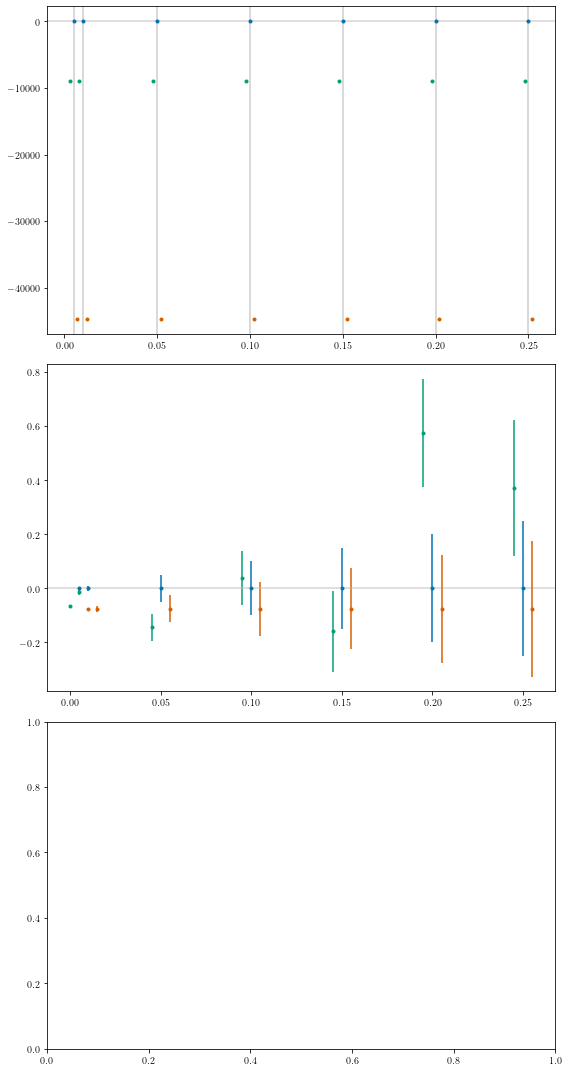

In [403]:
fig, ax = plt.subplots(3,1, figsize=(8,15))

for i in range(len(noises)):
    P_ij = spectra_sf[1][1][k_indices]
    P_jk = spectra_sf[1][4][k_indices]
    P_ik = spectra_sf[1][2][k_indices]

    P_ii_Beane = (P_ij * P_ik) / P_jk
    P_ii_samples = analysis.add_P(MCMCs_sf[0][0], k_indices, (0,0))
    
    ind = MCMCs_sf[0][1][0:-1:100].argmax()
    
#    ax[0].axvline(noises[i], alpha=.2, color='black')
    ax[0].axhline(0, alpha=.2, color='lightgray')
    
    ax[0].errorbar(noises[i],   P_ii_Beane - spectra_sf[1][0][k_indices],
                   yerr=noises[i], color=colors[0], marker='.')

    ax[0].errorbar(noises[i] - .002, Beanes_sf[i][0][k_indices] - spectra_sf[1][0][k_indices],
           ls='', marker='.', yerr=noises[i], color=colors[1])
    ax[0].errorbar(noises[i] + .002, P_ii_samples[ind][-1] - spectra_sf[1][0][k_indices],
           ls='', marker='.', yerr=noises[i], color=colors[2])
    
for i in range(len(noises)):
    P_ii_samples = analysis.add_P(MCMCs_pl[0][0], k_indices, (0,0))
    ind = MCMCs_pl[0][1][0:-1:100].argmax()
    
    ax[0].axvline(noises[i], alpha=.2, color='black')
    ax[1].axhline(0, alpha=.2, color='lightgray')
    
    ax[1].errorbar(noises[i], frac_diff(biases_pl[0]**2 * P_m[k_indices], spectra_pl[1][0][k_indices]),
                   yerr=noises[i], color=colors[0], marker='.')

    ax[1].errorbar(noises[i] - .005, frac_diff(Beanes_pl[i][0][k_indices], spectra_pl[1][0][k_indices]),
           ls='', marker='.', yerr=noises[i], color=colors[1])
    ax[1].errorbar(noises[i] + .005, frac_diff(P_ii_samples[ind][-1], spectra_pl[1][0][k_indices]),
           ls='', marker='.', yerr=noises[i], color=colors[2])
    
fig.tight_layout()


#### Superfake - Beane et al.

In [582]:
Beane_sf_op = fitting.Beane_et_al(spectra_sf_op, n_sf_op[0], n_sf_op[1], n_sf_op[2], N_modes, k_indices)
Beane_sf_con = fitting.Beane_et_al(spectra_sf_con, n_sf_con[0], n_sf_con[1], n_sf_con[2], N_modes, k_indices)
Beane_sf_pess = fitting.Beane_et_al(spectra_sf_pess, n_sf_pess[0], n_sf_pess[1], n_sf_pess[2], N_modes, k_indices)

/Users/lisaleemcb/Documents/Physics/Research/deprism/fitting.py:345: RuntimeWarning: invalid value encountered in true_divide
  P_ii = P_ij * P_ik / P_jk
/Users/lisaleemcb/Documents/Physics/Research/deprism/analysis.py:214: RuntimeWarning: invalid value encountered in true_divide
  - (P_ij * P_ik**2 / P_jk**3) * (P_jj_tot * P_ik + P_ij * P_jk) \


In [ ]:
plt.loglog(k[1:-1], spectra_sf[1][0][1:-1])

plt.errorbar(k[1:], Beane_sf_op[0][1:], yerr=np.sqrt(Beane_sf_op[1]))
plt.errorbar(k[1:], Beane_sf_con[0][1:], yerr=np.sqrt(Beane_sf_con[1]))
plt.errorbar(k[1:], Beane_sf_pess[0][1:], yerr=np.sqrt(Beane_sf_pess[1]))
plt.xscale('log')
plt.yscale('log')

#### Superfake - LSE

In [583]:
LSE_sf_op = fitting.LSE_results(k_indices, data_sf_op, N_sf_op)
LSE_sf_con = fitting.LSE_results(k_indices, data_sf_con, N_sf_con)
LSE_sf_pess = fitting.LSE_results(k_indices, data_sf_pess, N_sf_pess)

### Checking errors on P_m

In [ ]:
lnP_m_sigma = np.sqrt(np.diag(LSE_errors_op)[-1])
lnP_m_sigma

### MCMC's

#### Gaussian prior

In [584]:
MCMC_sf = fitting.MCMC_results(params_sf, k_indices, data_sf, model, N_op, nsteps=1e5)

PARAMS:  {'b_i': 478.231182600188, 'b_j': 308.5745030378501, 'b_k': 436.965467568963, 'P_m': array([0.00000000e+00, 9.91432762e+01, 5.70728734e+01, 7.40156501e+01,
       3.18019094e+01, 1.60424968e+01, 9.89934945e+00, 5.40108399e+00,
       2.97116482e+00, 1.58045389e+00, 8.38070921e-01, 4.42899755e-01,
       2.32886610e-01, 1.18974580e-01, 5.99164584e-02, 2.97635196e-02,
       1.42383400e-02, 5.77166379e-03, 1.63821461e-03, 0.00000000e+00])}
DATA:  [1460846.49874586 1334792.6622021  2068672.12646103]
NOISE:  [12168684.35250482 10958803.6599605  25775806.64681266]
running mcmc with the following settings:
fitting data from k:  [6]
prior is:  gaussian
prior width is:  0.25
positivity prior is:  False
pdf is:  gaussian
nsteps:  100000.0
no backend initialized


In [564]:
LSE_sf_op

(array([478.2311826 , 308.54584728, 437.04010445,   9.89870706]),
 array([14294.06650068,  9232.76585908, 13075.10687015,  1183.9490998 ]))

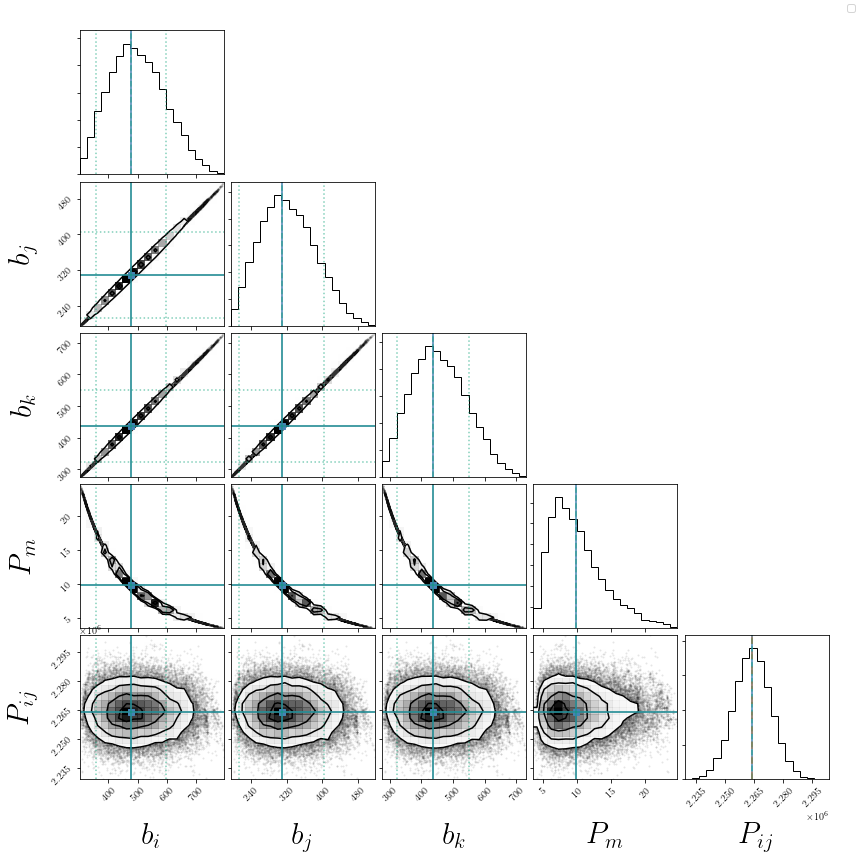

In [585]:
analysis.plot_corner('sf_lowestnoise.pdf', MCMC_sf, LSE_sf_op, Beane_sf_op, params_sf,
                     spectra_sf[1][0], k_indices)

In [ ]:
MCMC_sf_op = fitting.MCMC_results(params_sf, k_indices, data_sf, model, N_sf_op)
# MCMC_con = fitting.MCMC_results(params_sf, k_indices, data_sf_con, model, N_con)
#MCMC_pess = fitting.MCMC_results(params_sf, k_indices, data_sf_pess, model, N_pess)

In [ ]:
MCMC_sf_con = fitting.MCMC_results(params_sf, k_indices, data_sf_con, model, N_sf_con)

In [ ]:
MCMC_sf_pess = fitting.MCMC_results(params_sf, k_indices, data_sf, model, N_sf_pess)

In [ ]:
np.save('noise_comp', MCMC_sf_op=MCMC_sf_op, MCMC_sf)

In [594]:
np.savez('sf_results', data_sf_op=data_sf_op, data_sf_con=data_sf_con, data_sf_pess=data_sf_pess,
                     Beane_sf_op=Beane_sf_op, Beane_sf_con=Beane_sf_con, Beane_sf_pess=Beane_sf_pess,
                     LSE_sf_op=LSE_sf_op, LSE_sf_con=LSE_sf_con, LSE_sf_pess=LSE_sf_pess, 
                     MCMC_sf_op=MCMC_sf_op, MCMC_sf_con=MCMC_con, MCMC_sf_pess=MCMC_pess)

NameError: name 'Beane_sf_con' is not defined

In [588]:
sf_results = np.load('sf_results.npz', allow_pickle=True)

In [589]:
pl_results = np.load('pl_results.npz', allow_pickle=True)

In [590]:
bt_results = np.load('bt_results.npz', allow_pickle=True)

In [591]:
analysis.plot_corner('sf_op.pdf', MCMC_sf_op, LSE_sf_op, Beane_sf_op, params_sf, spectra_sf[1][0], k_indices)

NameError: name 'MCMC_sf_op' is not defined

In [593]:
analysis.plot_corner('sf_con.pdf', sf_results['MCMC_con'], sf_results['LSE_sf_con'], sf_results['Beane_sf_con'],
                     params_sf, spectra_sf[1][0], k_indices)

KeyError: 'MCMC_con is not a file in the archive'

In [ ]:
analysis.plot_corner('sf_pess.pdf', MCMC_pess, LSE_sf_con, Beane_sf_con, params_sf, spectra_sf[1][0], k_indices)

In [ ]:
sf_results.files

In [ ]:
spectra_sf[1][0][k_indices], sf_results['Beane_sf_op'][0][k_indices]

In [ ]:
LSE_params, pvals

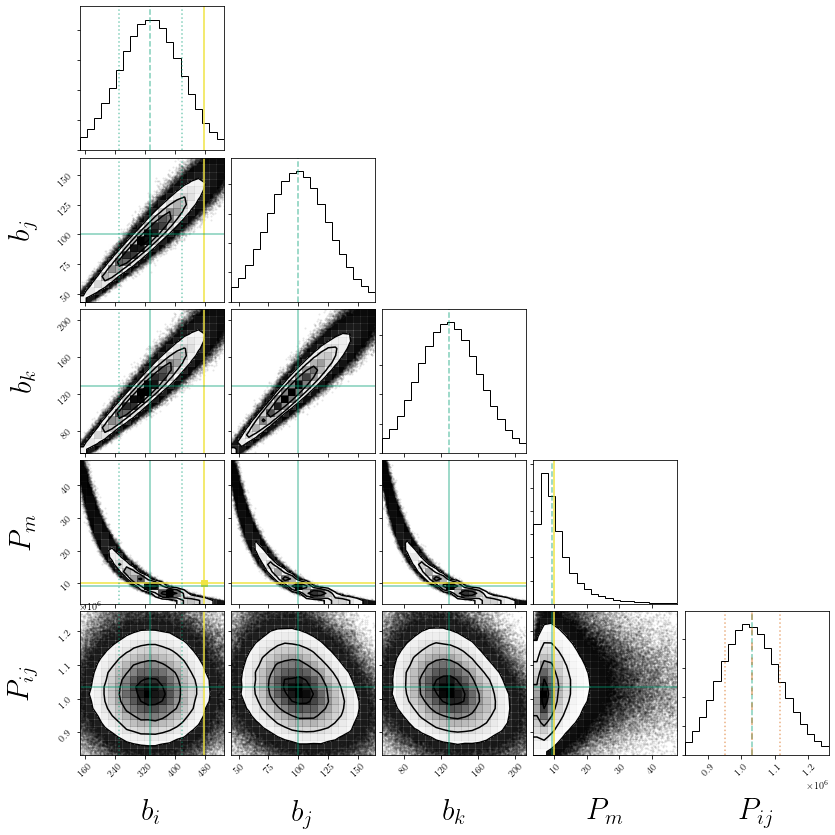

In [568]:
pvals = utils.get_pvals(params_sf, k_indices)
ndim = len(pvals)

# MCMC stuff
samples = sf_results['MCMC_sf_op'][0]
samples_00 = analysis.add_P(samples, [1], (0,0))

# LSE stuff
LSE_params, LSE_var = sf_results['LSE_sf_op']

LSE_params, LSE_var = utils.add_P_ii([LSE_params, LSE_var])

# Beane et al stuff
Beane_params, Beane_var = sf_results['Beane_sf_op']

# figure initialization
plt.style.use('seaborn-colorblind')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

figure = corner.corner(samples_00,
                           truths=[*pvals, *spectra_sf[1][0][k_indices]],
                           labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ij}$'], truth_color=colors[4],
                           label_kwargs={'fontsize': 30}, range=[.98,.98,.98,.98,.98])

axes = np.array(figure.axes).reshape((ndim+1, ndim+1))

# Loop over the diagonal
for i in range(ndim+1):
    ax = axes[i, i]
    ax.axvline(LSE_params[i], color=colors[1], alpha=.5, ls='--')
    ax.axvline(LSE_params[i] - np.sqrt(LSE_var[i]), color=colors[1], ls=':', alpha=.5)
    ax.axvline(LSE_params[i] + np.sqrt(LSE_var[i]), color=colors[1], ls=':', alpha=.5)

# Loop over the histograms
for yi in range(ndim+1):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(LSE_params[xi], color=colors[1], alpha=.5)
        ax.axvline(LSE_params[xi] - np.sqrt(LSE_var[xi]), color=colors[1], ls=':', alpha=.5)
        ax.axvline(LSE_params[xi] + np.sqrt(LSE_var[xi]), color=colors[1], ls=':', alpha=.5)
        #ax.axvline(value2[xi], color="r")
        ax.axhline(LSE_params[yi], color=colors[1], alpha=.5)
        ax.axhline(LSE_params[yi] - np.sqrt(LSE_var[yi]), color=colors[1], ls=':', alpha=.5)
        ax.axhline(LSE_params[yi] + np.sqrt(LSE_var[yi]), color=colors[1], ls=':', alpha=.5)
        #ax.axhline(value2[yi], color="r")
        ax.plot(LSE_params[xi], LSE_params[yi], colors[1])
       # ax.plot(value2[xi], value2[yi], "sr")

line2 = axes[-1,-1].axvline(Beane_params[k_indices], color=colors[2], ls='--', alpha=.5, dashes=(5, 5))
axes[-1,-1].axvline(Beane_params[k_indices] + np.sqrt(Beane_var[k_indices]),
                                                            color=colors[2], ls=':', alpha=.5)
axes[-1,-1].axvline(Beane_params[k_indices] - np.sqrt(Beane_var[k_indices]),
                                                            color=colors[2], ls=':', alpha=.5)

fig.legend()

In [565]:
pvals = utils.get_pvals(params_pl, k_indices)
ndim = len(pvals)

# MCMC stuff
samples = pl_results['MCMC_pl_op'][0]
samples_00 = analysis.add_P(samples, [1], (0,0))

# LSE stuff
LSE_params, LSE_var = pl_results['LSE_pl_op']

LSE_params, LSE_var = utils.add_P_ii([LSE_params, LSE_var])

# Beane et al stuff
Beane_params, Beane_var = pl_results['Beane_pl_op']

# figure initialization
plt.style.use('seaborn-colorblind')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

figure = corner.corner(samples_00,
                           truths=[*pvals, *spectra_pl[1][0][k_indices]],
                           labels=[r'$b_{21\mathrm{cm}}$', r'$b_{\mathrm{CII}}$', r'$b_{\mathrm{OIII}}$', r'$P_m$', r'$P_{21\mathrm{cm}}$'], truth_color=colors[3],
                           label_kwargs={'fontsize': 30}, range=[.98,.98,.98,.98,.98])

axes = np.array(figure.axes).reshape((ndim+1, ndim+1))

# Loop over the diagonal
for i in range(ndim+1):
    ax = axes[i, i]
    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.axvline(LSE_params[i], color=colors[1], alpha=.5, ls='--')
    ax.axvline(LSE_params[i] - np.sqrt(LSE_var[i]), color=colors[1], ls=':', alpha=.5)
    ax.axvline(LSE_params[i] + np.sqrt(LSE_var[i]), color=colors[1], ls=':', alpha=.5)

# Loop over the histograms
for yi in range(ndim+1):
    for xi in range(yi):
        ax = axes[yi, xi]
        
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axvline(LSE_params[xi], color=colors[1], alpha=.5)
        ax.axvline(LSE_params[xi] - np.sqrt(LSE_var[xi]), color=colors[1], ls=':', alpha=.5)
        ax.axvline(LSE_params[xi] + np.sqrt(LSE_var[xi]), color=colors[1], ls=':', alpha=.5)
        #ax.axvline(value2[xi], color="r")
        ax.axhline(LSE_params[yi], color=colors[1], alpha=.5)
        ax.axhline(LSE_params[yi] - np.sqrt(LSE_var[yi]), color=colors[1], ls=':', alpha=.5)
        ax.axhline(LSE_params[yi] + np.sqrt(LSE_var[yi]), color=colors[1], ls=':', alpha=.5)
        #ax.axhline(value2[yi], color="r")
        ax.plot(LSE_params[xi], LSE_params[yi], colors[1])
       # ax.plot(value2[xi], value2[yi], "sr")

line2 = axes[-1,-1].axvline(Beane_params[k_indices], color=colors[2], ls='--', alpha=.5, dashes=(5, 5))
axes[-1,-1].axvline(Beane_params[k_indices] + np.sqrt(Beane_var[k_indices]),
                                                            color=colors[2], ls=':', alpha=.5)
axes[-1,-1].axvline(Beane_params[k_indices] - np.sqrt(Beane_var[k_indices]),
                                                            color=colors[2], ls=':', alpha=.5)

figure.tight_layout()
figure.legend()
figure.savefig('workshop_pl_op.pdf')

NameError: name 'pl_results' is not defined

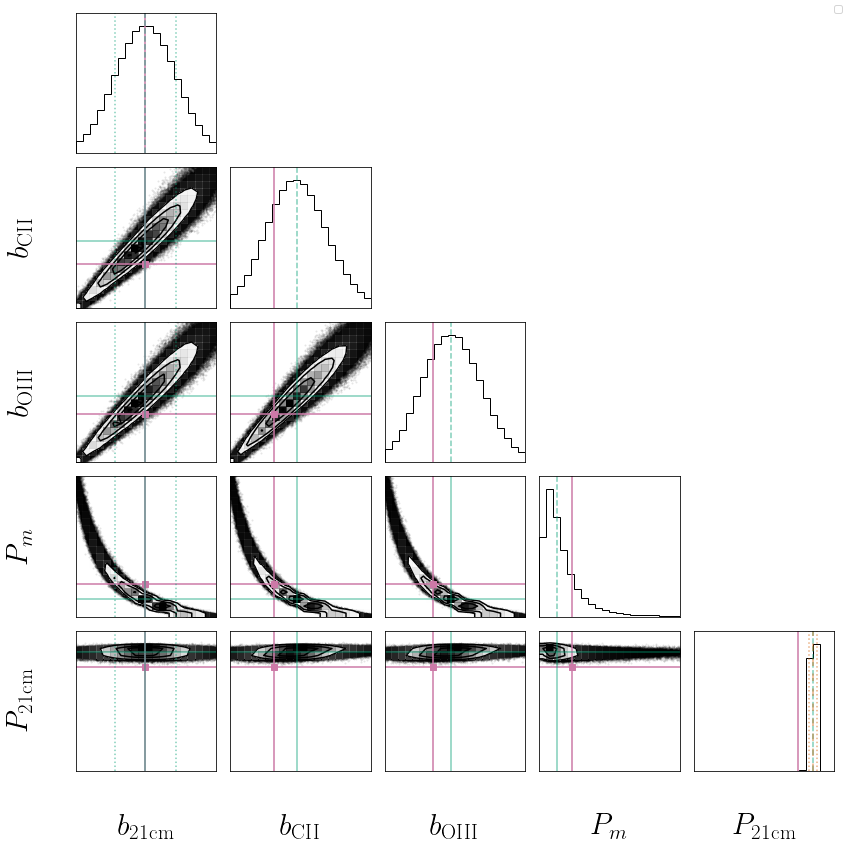

In [138]:
pvals = utils.get_pvals(params_bt, k_indices)
ndim = len(pvals)

# MCMC stuff
samples = bt_results['MCMC_bt_op'][0]
samples_00 = analysis.add_P(samples, [1], (0,0))

# LSE stuff
LSE_params, LSE_var = bt_results['LSE_bt_op']

LSE_params, LSE_var = utils.add_P_ii([LSE_params, LSE_var])

# Beane et al stuff
Beane_params, Beane_var = bt_results['Beane_bt_op']

# figure initialization
plt.style.use('seaborn-colorblind')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

figure = corner.corner(samples_00,
                           truths=[*pvals, *spectra_bt[1][0][k_indices]],
                           labels=[r'$b_{21\mathrm{cm}}$', r'$b_{\mathrm{CII}}$', r'$b_{\mathrm{OIII}}$', r'$P_m$', r'$P_{21\mathrm{cm}}$'], truth_color=colors[3],
                           label_kwargs={'fontsize': 30}, range=[.98,.98,.98,.98,(32369820.401937447, 1649524.8669625085)])

axes = np.array(figure.axes).reshape((ndim+1, ndim+1))

# Loop over the diagonal
for i in range(ndim+1):
    ax = axes[i, i]
    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.axvline(LSE_params[i], color=colors[1], alpha=.5, ls='--')
    ax.axvline(LSE_params[i] - np.sqrt(LSE_var[i]), color=colors[1], ls=':', alpha=.5)
    ax.axvline(LSE_params[i] + np.sqrt(LSE_var[i]), color=colors[1], ls=':', alpha=.5)

# Loop over the histograms
for yi in range(ndim+1):
    for xi in range(yi):
        ax = axes[yi, xi]
        
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axvline(LSE_params[xi], color=colors[1], alpha=.5)
        ax.axvline(LSE_params[xi] - np.sqrt(LSE_var[xi]), color=colors[1], ls=':', alpha=.5)
        ax.axvline(LSE_params[xi] + np.sqrt(LSE_var[xi]), color=colors[1], ls=':', alpha=.5)
        #ax.axvline(value2[xi], color="r")
        ax.axhline(LSE_params[yi], color=colors[1], alpha=.5)
        ax.axhline(LSE_params[yi] - np.sqrt(LSE_var[yi]), color=colors[1], ls=':', alpha=.5)
        ax.axhline(LSE_params[yi] + np.sqrt(LSE_var[yi]), color=colors[1], ls=':', alpha=.5)
        #ax.axhline(value2[yi], color="r")
        ax.plot(LSE_params[xi], LSE_params[yi], colors[1])
       # ax.plot(value2[xi], value2[yi], "sr")

line2 = axes[-1,-1].axvline(Beane_params[k_indices], color=colors[2], ls='--', alpha=.5, dashes=(5, 5))
axes[-1,-1].axvline(Beane_params[k_indices] + np.sqrt(Beane_var[k_indices]),
                                                            color=colors[2], ls=':', alpha=.5)
axes[-1,-1].axvline(Beane_params[k_indices] - np.sqrt(Beane_var[k_indices]),
                                                            color=colors[2], ls=':', alpha=.5)

figure.tight_layout()
figure.legend()
figure.savefig('workshop_bt_op.pdf')

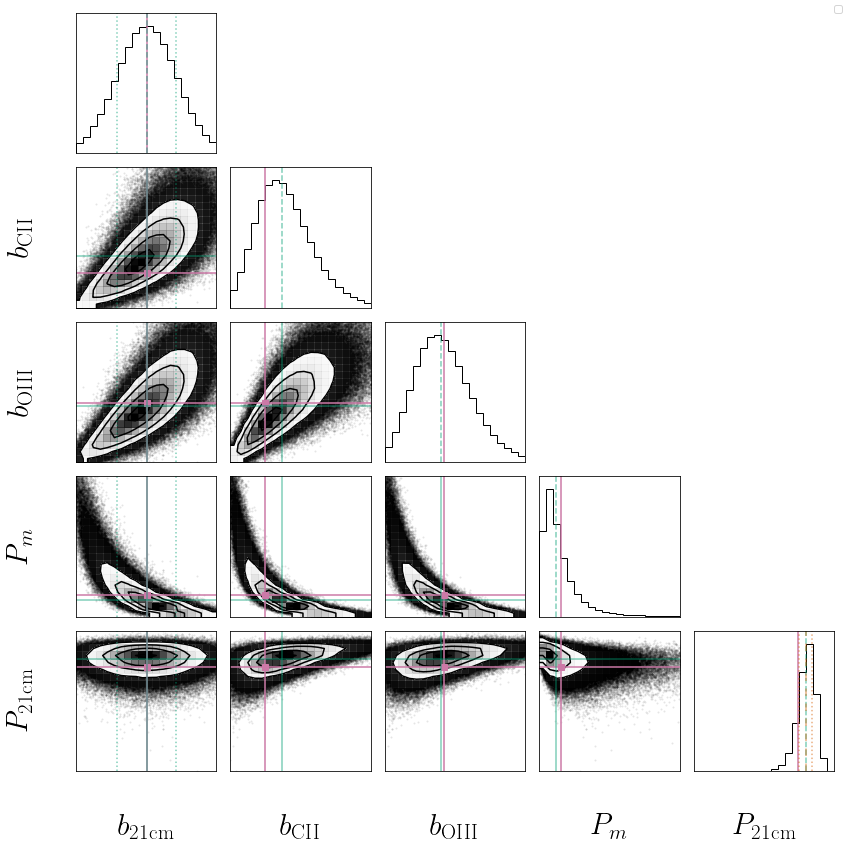

In [139]:
pvals = utils.get_pvals(params_bt, k_indices)
ndim = len(pvals)

# MCMC stuff
samples = bt_results['MCMC_bt_pess'][0]
samples_00 = analysis.add_P(samples, [1], (0,0))

# LSE stuff
LSE_params, LSE_var = bt_results['LSE_bt_pess']

LSE_params, LSE_var = utils.add_P_ii([LSE_params, LSE_var])

# Beane et al stuff
Beane_params, Beane_var = bt_results['Beane_bt_pess']

# figure initialization
plt.style.use('seaborn-colorblind')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

figure = corner.corner(samples_00,
                           truths=[*pvals, *spectra_bt[1][0][k_indices]],
                           labels=[r'$b_{21\mathrm{cm}}$', r'$b_{\mathrm{CII}}$', r'$b_{\mathrm{OIII}}$', r'$P_m$', r'$P_{21\mathrm{cm}}$'], truth_color=colors[3],
                           label_kwargs={'fontsize': 30}, range=[.98,.98,.98,.98,(32369820.401937447, 1649524.8669625085)])

axes = np.array(figure.axes).reshape((ndim+1, ndim+1))

# Loop over the diagonal
for i in range(ndim+1):
    ax = axes[i, i]
    
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.axvline(LSE_params[i], color=colors[1], alpha=.5, ls='--')
    ax.axvline(LSE_params[i] - np.sqrt(LSE_var[i]), color=colors[1], ls=':', alpha=.5)
    ax.axvline(LSE_params[i] + np.sqrt(LSE_var[i]), color=colors[1], ls=':', alpha=.5)

# Loop over the histograms
for yi in range(ndim+1):
    for xi in range(yi):
        ax = axes[yi, xi]
        
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axvline(LSE_params[xi], color=colors[1], alpha=.5)
        ax.axvline(LSE_params[xi] - np.sqrt(LSE_var[xi]), color=colors[1], ls=':', alpha=.5)
        ax.axvline(LSE_params[xi] + np.sqrt(LSE_var[xi]), color=colors[1], ls=':', alpha=.5)
        #ax.axvline(value2[xi], color="r")
        ax.axhline(LSE_params[yi], color=colors[1], alpha=.5)
        ax.axhline(LSE_params[yi] - np.sqrt(LSE_var[yi]), color=colors[1], ls=':', alpha=.5)
        ax.axhline(LSE_params[yi] + np.sqrt(LSE_var[yi]), color=colors[1], ls=':', alpha=.5)
        #ax.axhline(value2[yi], color="r")
        ax.plot(LSE_params[xi], LSE_params[yi], colors[1])
       # ax.plot(value2[xi], value2[yi], "sr")

line2 = axes[-1,-1].axvline(Beane_params[k_indices], color=colors[2], ls='--', alpha=.5, dashes=(5, 5))
axes[-1,-1].axvline(Beane_params[k_indices] + np.sqrt(Beane_var[k_indices]),
                                                            color=colors[2], ls=':', alpha=.5)
axes[-1,-1].axvline(Beane_params[k_indices] - np.sqrt(Beane_var[k_indices]),
                                                            color=colors[2], ls=':', alpha=.5)

figure.tight_layout()
figure.legend()
figure.savefig('workshop_bt_pess.pdf')

In [135]:
samples_00[:,-1].max(), samples_00[:,-1].min()

(32369820.401937447, 1649524.8669625085)

In [137]:
samples_00[:,-1].max(), samples_00[:,-1].min()

(9256607.298774749, 4088477.6341790273)

In [ ]:
plt.loglog(spectra_pl[0], (spectra_pl[0]**3 / (2 * np.pi**2)) * spectra_pl[1][0])
plt.axvline(k[6])
plt.axhline(2264031.35001365)

In [ ]:
plt.loglog(spectra_pl[0], spectra_pl[1][0])
plt.axvline(k[6])
plt.axhline(2264031.35001365)

In [ ]:
(spectra_pl[0][6]**3 / (2 * np.pi**2)) * spectra_pl[1][0][6]

In [ ]:
import pocomc as pc

# Define the dimensionality of our problem.
ndim = 10

# Define our 10-D Rosenbrock log-likelihood.
def log_likelihood(x):
    return -np.sum(10.0*(x[:,::2]**2.0 - x[:,1::2])**2.0 \
            + (x[:,::2] - 1.0)**2.0, axis=1)

# Define our uniform prior.
def log_prior(x):
    if np.any(x < -10.0) or np.any(x > 10.0):
        return -np.inf
    else:
        return 0.0

In [ ]:
# Number of particles to use
nparticles = 1000

# Initialise sampler
sampler = pc.Sampler(n_particles,
                     n_dim,
                     log_likelihood=log_likelihood,
                     log_prior=log_prior,
                     vectorize_likelihood=True,
                     bounds=(-10.0, 10.0))

In [ ]:
# Initialise particles' positions using samples from the prior (this is very important, other initialisation will not work).
prior_samples = np.random.uniform(low=-10.0, high=10.0, size=(nparticles, ndim))

# Start sampling
sampler.run(prior_samples)

# We can add more samples at the end
sampler.add_samples(1000)

# Get results
results = sampler.results

In [ ]:
#mcmc_all_k = []

#for i, val in enumerate(k):
#    mcmc = fitting.recover_params_mcmc(k, k_indices, spectra[1], model_cross, P_m,
#                                    variances, priors='gaussian', priors_width=.1)
#    
#    mcmc_all_k.append(mcmc)

### Simulated power law data and fractional noise error

In [247]:
biases_pl = utils.extract_bias(k_indices, spectra_pl[1], P_m)
p_vals_pl = np.asarray([*biases_pl, P_m], dtype=object)

params_pl = dict(zip(p_names, p_vals_pl))
ndim = utils.choose_params(params_pl, k_indices).size

spectra_pl_op, std_pl_op = analysis.noisey_spectra(spectra_pl[1], frac_error=frac_op)
spectra_pl_con, std_pl_con = analysis.noisey_spectra(spectra_pl[1], frac_error=frac_con)
spectra_pl_pess, std_pl_pess = analysis.noisey_spectra(spectra_pl[1], frac_error=frac_pess)

data_pl = utils.fetch_data(k_indices, spectra_pl[1],
                           b_0=params_pl['b_i'])
data_pl_op = utils.fetch_data(k_indices, spectra_pl_op,
                           b_0=params_pl['b_i'])
data_pl_con = utils.fetch_data(k_indices, spectra_pl_con,
                           b_0=params_pl['b_i'])
data_pl_pess = utils.fetch_data(k_indices, spectra_pl_pess,
                           b_0=params_pl['b_i'])

model_auto = models.ScalarBias(k=spectra_pl[0], params=params_pl)
model = models.ScalarBias_crossonly(k=spectra_pl[0], params=params_pl)

N_op = analysis.estimate_errors(data_pl, frac_error=frac_op)
# N_con = analysis.estimate_errors(data_pl, frac_error=frac_con)
# N_pess = analysis.estimate_errors(data_pl, frac_error=frac_pess)

# CAREFUL! First is var, second is std
N_pl_op, n_pl_op = analysis.get_noise(k_indices, std_pl_op, params_pl['b_i'])
N_pl_con, n_pl_con = analysis.get_noise(k_indices, std_pl_con, params_pl['b_i'])
N_pl_pess, n_pl_pess = analysis.get_noise(k_indices, std_pl_pess, params_pl['b_i'])

#N = analysis.create_noise_matrix(k_indices, variances)

#### Power Law - Beane et al

In [ ]:
Beane_pl_op = fitting.Beane_et_al(spectra_pl_op, n_pl_op[0], n_pl_op[1], n_pl_op[2], N_modes, k_indices)
Beane_pl_con = fitting.Beane_et_al(spectra_pl_con, n_pl_con[0], n_pl_con[1], n_pl_con[2], N_modes, k_indices)
Beane_pl_pess = fitting.Beane_et_al(spectra_pl_pess, n_pl_pess[0], n_pl_pess[1], n_pl_pess[2], N_modes, k_indices)

In [ ]:
plt.loglog(k[1:-1], k[1:-1]**3 / (4 * np.pi**2) * spectra_pl[1][0][1:-1])

plt.errorbar(k[1:], k[1:]**3 / (4 * np.pi**2) * Beane_pl_op[0][1:], yerr=np.sqrt(Beane_pl_op[1]))
plt.errorbar(k[1:], k[1:]**3 / (4 * np.pi**2) * Beane_pl_con[0][1:], yerr=np.sqrt(Beane_pl_con[1]))
plt.errorbar(k[1:], k[1:]**3 / (4 * np.pi**2) * Beane_pl_pess[0][1:], yerr=np.sqrt(Beane_pl_pess[1]))
plt.yscale('log')

#### Power Law - LSE

In [ ]:
LSE_pl_op = fitting.LSE_results(k_indices, data_pl_op, N_pl_op)
LSE_pl_con = fitting.LSE_results(k_indices, data_pl_con, N_pl_con)
LSE_pl_pess = fitting.LSE_results(k_indices, data_pl_pess, N_pl_pess)

#### Power Law - MCMC - Gaussian priors

In [ ]:
MCMC_pl_op = fitting.MCMC_results(params_pl, k_indices, data_pl, model, N_pl_op)

In [ ]:
MCMC_pl_con = fitting.MCMC_results(params_pl, k_indices, data_pl_con, model, N_pl_con)

In [ ]:
MCMC_pl_pess = fitting.MCMC_results(params_pl, k_indices, data_pl_pess, model, N_pl_pess)

### Power Law Results

In [ ]:
np.savez('pl_results', data_pl_op=data_pl_op, data_pl_con=data_pl_con, data_pl_pess=data_pl_pess,
                     Beane_pl_op=Beane_pl_op, Beane_pl_con=Beane_pl_con, Beane_pl_pess=Beane_pl_pess,
                     LSE_pl_op=LSE_pl_op, LSE_pl_con=LSE_pl_con, LSE_pl_pess=LSE_pl_pess, 
                     MCMC_pl_op=MCMC_op, MCMC_pl_con=MCMC_con, MCMC_pl_pess=MCMC_pess)

In [ ]:
analysis.plot_corner('pl_op.pdf', MCMC_pl_op, LSE_pl_op, Beane_pl_op, params_pl, spectra_pl[1][0], k_indices)

In [ ]:
analysis.plot_corner('pl_con.pdf', MCMC_pl_con, LSE_pl_con, Beane_pl_con, params_pl, spectra_pl[1][0], k_indices)

In [ ]:
analysis.plot_corner('pl_pess.pdf', MCMC_pl_pess, LSE_pl_pess, Beane_pl_pess, params_pl, spectra_pl[1][0],
                     k_indices)

### Simulated brightness temperature data and fractional noise error

In [129]:
biases_bt = utils.extract_bias(k_indices, spectra_bt[1], P_m)
p_vals_bt = np.asarray([*biases_bt, P_m], dtype=object)

params_bt = dict(zip(p_names, p_vals_bt))
ndim = utils.choose_params(params_bt, k_indices).size

spectra_bt_op, std_bt_op = analysis.noisey_spectra(spectra_bt[1], frac_error=frac_op)
spectra_bt_con, std_bt_con = analysis.noisey_spectra(spectra_bt[1], frac_error=frac_con)
spectra_bt_pess, std_bt_pess = analysis.noisey_spectra(spectra_bt[1], frac_error=frac_pess)

data_bt = utils.fetch_data(k_indices, spectra_bt[1],
                           b_0=params_bt['b_i'])
data_bt_op = utils.fetch_data(k_indices, spectra_bt_op,
                           b_0=params_bt['b_i'])
data_bt_con = utils.fetch_data(k_indices, spectra_bt_con,
                           b_0=params_bt['b_i'])
data_bt_pess = utils.fetch_data(k_indices, spectra_bt_pess,
                           b_0=params_bt['b_i'])

model_auto = models.ScalarBias(k=spectra_bt[0], params=params_bt)
model = models.ScalarBias_crossonly(k=spectra_bt[0], params=params_bt)

N_op = analysis.estimate_errors(data_bt, frac_error=frac_op)
# N_con = analysis.estimate_errors(data_bt, frac_error=frac_con)
# N_pess = analysis.estimate_errors(data_bt, frac_error=frac_pess)

# CAREFUL! First is var, second is std
N_bt_op, n_bt_op = analysis.get_noise(k_indices, std_bt_op, params_bt['b_i'])
N_bt_con, n_bt_con = analysis.get_noise(k_indices, std_bt_con, params_bt['b_i'])
N_bt_pess, n_bt_pess = analysis.get_noise(k_indices, std_bt_pess, params_bt['b_i'])

#N = analysis.create_noise_matrix(k_indices, variances)

#### Brightness Temperature - Beane et al

In [ ]:
Beane_bt_op = fitting.Beane_et_al(spectra_bt_op, n_bt_op[0], n_bt_op[1], n_bt_op[2], N_modes, k_indices)
Beane_bt_con = fitting.Beane_et_al(spectra_bt_con, n_bt_con[0], n_bt_con[1], n_bt_con[2], N_modes, k_indices)
Beane_bt_pess = fitting.Beane_et_al(spectra_bt_pess, n_bt_pess[0], n_bt_pess[1], n_bt_pess[2], N_modes, k_indices)

In [ ]:
plt.loglog(k[1:-1], spectra_bt[1][0][1:-1])

plt.errorbar(k[1:], Beane_bt_op[0][1:], yerr=np.sqrt(Beane_bt_op[1]))
plt.errorbar(k[1:], Beane_bt_con[0][1:], yerr=np.sqrt(Beane_bt_con[1]))
plt.errorbar(k[1:], Beane_bt_pess[0][1:], yerr=np.sqrt(Beane_bt_pess[1]))
plt.yscale('log')

#### Brightness Temperature - LSE

In [ ]:
LSE_bt_op = fitting.LSE_results(k_indices, data_bt_op, N_bt_op)
LSE_bt_con = fitting.LSE_results(k_indices, data_bt_con, N_bt_con)
LSE_bt_pess = fitting.LSE_results(k_indices, data_bt_pess, N_bt_pess)

#### Brightness Temperature - MCMC - Gaussian priors

In [ ]:
MCMC_bt_op = fitting.MCMC_results(params_bt, k_indices, data_bt_op, model, N_bt_op)

In [ ]:
MCMC_bt_con = fitting.MCMC_results(params_bt, k_indices, data_bt_con, model, N_bt_con)

In [ ]:
MCMC_bt_pess = fitting.MCMC_results(params_bt, k_indices, data_bt_pess, model, N_bt_pess)

### Brightness Temperature Results

In [ ]:
np.savez('bt_results', data_bt_op=data_bt_op, data_bt_con=data_bt_con, data_bt_pess=data_bt_pess,
                     Beane_bt_op=Beane_bt_op, Beane_bt_con=Beane_bt_con, Beane_bt_pess=Beane_bt_pess,
                     LSE_bt_op=LSE_bt_op, LSE_bt_con=LSE_bt_con, LSE_bt_pess=LSE_bt_pess, 
                     MCMC_bt_op=MCMC_op, MCMC_bt_con=MCMC_con, MCMC_bt_pess=MCMC_pess)

In [ ]:
analysis.plot_corner('bt_op.pdf', MCMC_bt_op, LSE_bt_op, Beane_bt_op, params_bt, spectra_bt[1][0], k_indices)

In [ ]:
analysis.plot_corner('bt_con.pdf', MCMC_bt_con, LSE_bt_con, Beane_bt_con, params_bt, spectra_bt[1][0], k_indices)

In [ ]:
analysis.plot_corner('bt_pess.pdf', MCMC_bt_pess, LSE_bt_pess, Beane_bt_pess, params_bt, spectra_bt[1][0],
                     k_indices)

### Fisher analysis

#### Reparameterization

In [ ]:
def diagonalize(M, S):
    S_inv = np.linalg.inv(S)
    
    return np.matmul(S_inv, np.matmul(M, S))

def transform_theta(theta, truths, Fisher, S_inv):
    diff = theta - truths
    diff = np.matmul(S_inv, diff)
    
    theta_prime = np.matmul(np.sqrt(Fisher), diff)

    return theta_prime

def transform_samples(theta, truths, Fisher, S_inv):
    diff = np.asarray(theta) - np.asarray(truths)
    diff = np.matmul(S_inv, diff.reshape(nsteps * nwalkers,4,1))
    
    theta_prime = np.matmul(np.sqrt(Fisher), diff)

    return theta_prime.reshape(nsteps * nwalkers, 4)

def untransform_theta(theta_prime, truths, Fisher, S):
    theta_temp = np.matmul(np.linalg.inv(np.sqrt(Fisher)), theta_prime)
    theta_temp = np.matmul(S, theta_temp)

    theta = theta_temp + truths

    return theta

def untransform_samples(theta_prime, truths, Fisher, S):
    num = theta_prime.shape[1]
    theta_temp = np.matmul(np.linalg.inv(np.sqrt(Fisher)), theta_prime.reshape(nsteps * nwalkers,4,1))
    theta_temp = np.matmul(S, theta_temp)

    theta = theta_temp.reshape(nsteps * nwalkers,4) + truths

    return theta
                           
def log_prob_Fisher(guess, truth, Fisher):
    
    diff = (np.asarray(guess) - np.asarray(truth))

    return -.5 * np.dot(diff.T, np.dot(Fisher,diff))
    
def transform_lnprob_Fisher(guess, truth, Fisher):    
    scaling = np.linalg.inv(np.sqrt(Fisher))
    guess_transformed = np.matmul(scaling, guess)
    guess_transformed += truth
    
    diff = (np.asarray(guess_transformed) - np.asarray(truth))

    return log_prob_Fisher(guess_transformed, truth, Fisher)

def transform_lnprob(guess, pvals, params, Fisher, S, k_indices, data, model, noise):   
    guess = untransform_theta(guess, pvals, Fisher, S)
    
    return fitting.log_prob(guess, params, k_indices, data, model, noise)

In [ ]:
runs = [noise0, noise1, noise2, noise3, noise4, noise5]

In [ ]:
p_n = 1 

noise_levels = np.array([.01, .05, .1, .25, .35, .5])

medians = np.zeros_like(noise_levels,)
means = np.zeros_like(noise_levels)
max_lps = np.zeros_like(noise_levels)

medians_trans = np.zeros_like(noise_levels,)
means_trans = np.zeros_like(noise_levels)
max_lps_trans = np.zeros_like(noise_levels)

all_samples = [runs[i][0][0][:,p_n] for i in range(len(noise_levels))]

In [ ]:
for i in range(6):
    medians[i] = np.median(runs[i][0][0][:,p_n])
    means[i] = np.mean(runs[i][0][0][:,p_n])
    arg_ind = np.argmax(runs[i][1][0])
    max_lps[i] = (runs[i][0][0][arg_ind,p_n])
    
    medians_trans[i] = np.median(runs[i][0][1][:,p_n])
    means_trans[i] = np.mean(runs[i][0][1][:,p_n])
    arg_ind = np.argmax(runs[i][1][1])
    max_lps_trans[i] = (runs[i][0][1][arg_ind,p_n])

In [ ]:
medians, pvals, means, max_lps

In [ ]:
all_samples[0:-2]

In [ ]:
figure = corner.corner(samples1, truths=pvals,
                           labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'],
                           label_kwargs={'fontsize': 30},
                          range=[.68,.68,.68,.68])

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
cmap = matplotlib.cm.get_cmap('hsv')

In [ ]:
def recover_P21(mcmc_list):
    P_21 = np.zeros(len(mcmc_list))
    var_21 = np.zeros(len(mcmc_list))
    b_i = np.zeros(len(mcmc_list))
    P_m = np.zeros(len(mcmc_list))

    for i in range(len(mcmc_list)):
        samples = mcmc_list[i][0][0]

        samples_b_i = samples[:,0]
        samples_P_m = samples[:,3]

        P_21_samples = samples_b_i**2 * samples_P_m

        P_21[i] = np.median(P_21_samples)
        var_21[i] = np.var(P_21_samples)
        b_i[i] = np.median(samples_b_i)
        P_m[i] = np.median(samples_P_m)
        
    return P_21, var_21

def recover_P21_LSE(LSE_list):
    P_21 = np.zeros(len(LSE_list))
    var_21 = np.zeros(len(LSE_list))
    var_b_i = np.zeros(len(LSE_list))
    var_P_m = np.zeros(len(LSE_list))
    b_i = np.zeros(len(LSE_list))
    P_m = np.zeros(len(LSE_list))
    
    for i in range(len(LSE_list)):
        var_b_i[i] = np.exp(2 * LSE_list[i][0][0]) * LSE_list[i][1][0,0]
        var_P_m[i] = (np.exp(LSE_list[i][0][3]) * np.sqrt(LSE_list[i][1][3,3]))**2

        b_i[i] = np.exp(LSE_list[i][0][0])
        P_m[i] = np.exp(LSE_list[i][0][3])
    
    P_21 = b_i**2 * P_m
    var_21 = (var_b_i / b_i**2 + var_P_m / P_m**2) # * P_21
    
    return P_21, var_21

In [ ]:
rainbow = ['red', 'hotpink', 'orange', 'yellow', 'chartreuse', 'green', 'deepskyblue', 'blue',
              'darkviolet', 'violet']
fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], spectra[1][0][1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=None, label='True', color='black', lw=3)

ax.errorbar(k[1:-1], P_21_05_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_05_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 5\% noise', lw=2, color=rainbow[0])

ax.errorbar(k[1:-1], P_21_10_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_10_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 10\% noise', lw=2, color=rainbow[1])

ax.errorbar(k[1:-1], P_21_15_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_15_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 15\% noise', lw=2, color=rainbow[2])

ax.errorbar(k[1:-1], P_21_20_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_20_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 20\% noise', lw=2, color=rainbow[3])

ax.errorbar(k[1:-1], P_21_25_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_25_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 25\% noise', lw=2, color=rainbow[4])

ax.errorbar(k[1:-1], P_21_30_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_30_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[5])

ax.errorbar(k[1:-1], P_21_35_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_35_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[6])

ax.errorbar(k[1:-1], P_21_40_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_40_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[7])

ax.errorbar(k[1:-1], P_21_45_sf * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_45_sf) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[8])

ax.errorbar(k[1:-1], P_21_50 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_50) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 50\% noise', lw=2, color=rainbow[9])

#ax.errorbar(k[1:-1], P_21_calc * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_calc) * k[1:-1]**3 / (2 * np.pi**2),
#           label=r'MCMC calculated noise', lw=2, color=rainbow[4])

ax.errorbar(k[1:-1], P_21_Beane_superfake[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_Beane[:-1]) * k[1:-1]**3 / (2 * np.pi**2),
           label='Beane et al.', color='black', ls=':')

#ax.errorbar(k[1:-1], b_i_LSE**2 * P_m_LSE * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
 #          label='LSE reconstructed', ls='-')

#ax.errorbar(k[1:-1], b_i_LSE_auto**2 * P_m_LSE_auto * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE_auto) * k[1:-1]**3 / (2 * np.pi**2),
#           label='LSE reconstructed auto', ls='-')

ax.legend()

ax.set_xlim(k[1], k[10])
#ax.set_ylim(5e4, 1e6)

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
rainbow = ['red', 'hotpink', 'orange', 'yellow', 'chartreuse', 'green', 'deepskyblue', 'blue',
              'darkviolet', 'violet']

fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], spectra[1][0][1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=None, label='True', color='black', lw=3)

ax.errorbar(k[1:-1], P_21_05_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_05_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 5\% noise', lw=2, color=rainbow[0])

ax.errorbar(k[1:-1], P_21_10_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_10_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 10\% noise', lw=2, color=rainbow[1])

ax.errorbar(k[1:-1], P_21_15_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_15_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 15\% noise', lw=2, color=rainbow[2])

ax.errorbar(k[1:-1], P_21_20_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_20_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 20\% noise', lw=2, color=rainbow[3])

ax.errorbar(k[1:-1], P_21_25_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_25_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 25\% noise', lw=2, color=rainbow[4])

ax.errorbar(k[1:-1], P_21_30_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_30_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[5])

ax.errorbar(k[1:-1], P_21_35_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_35_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[6])

ax.errorbar(k[1:-1], P_21_40_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_40_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[7])

ax.errorbar(k[1:-1], P_21_45_sf_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_45_sf_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[8])

ax.errorbar(k[1:-1], P_21_50 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_50) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 50\% noise', lw=2, color=rainbow[9])

#ax.errorbar(k[1:-1], P_21_calc * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_calc) * k[1:-1]**3 / (2 * np.pi**2),
#           label=r'MCMC calculated noise', lw=2, color=rainbow[4])

ax.errorbar(k[1:-1], P_21_Beane_superfake[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_Beane[:-1]) * k[1:-1]**3 / (2 * np.pi**2),
           label='Beane et al.', color='black', ls=':')

#ax.errorbar(k[1:-1], b_i_LSE**2 * P_m_LSE * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
 #          label='LSE reconstructed', ls='-')

#ax.errorbar(k[1:-1], b_i_LSE_auto**2 * P_m_LSE_auto * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE_auto) * k[1:-1]**3 / (2 * np.pi**2),
#           label='LSE reconstructed auto', ls='-')

ax.legend()

ax.set_xlim(k[1], k[10])
#ax.set_ylim(5e4, 1e6)

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
def plot_lklhd(which_p, p_range, ind, model=model_cross):
    biases_sf = utils.extract_bias([ind], spectra_superfake[1], P_m)
    p_names = np.asarray(['b_i','b_j', 'b_k', 'P_m'])
    p_vals = np.asarray([*biases_sf, P_m], dtype=object)

    p_truths = dict(zip(p_names, p_vals))

    lklhd = np.zeros_like(p_range)
    p_test = cp.deepcopy(p_truths)
    
    if which_p is not 'P_m':
        for i, p in enumerate(p_range):
            p_test[which_p] = p
            #print(p_test)
            data = model.pspec([ind], params=p_truths)
          #  print('data:  ', data)
          #  print('model: ', model.pspec([ind], params=p_test))

            lklhd[i] = fitting.log_likelihood(p_test, [ind], data,
                                        model, N[1:-1,1:-1], pdf='gaussian')
            
    if which_p is 'P_m':
        for i, p in enumerate(p_range):
            p_test[which_p][[ind]] = p
            data = model.pspec([ind], params=p_truths)

            lklhd[i] = fitting.log_likelihood(p_test, [ind], data,
                                        model, N[1:-1,1:-1], pdf='gaussian')
        
    return lklhd

def plot_lnprob(which_p, p_range, ind, model=model_cross):
    biases_sf = utils.extract_bias([ind], spectra_superfake[1], P_m)
    p_names = np.asarray(['b_i','b_j', 'b_k', 'P_m'])
    p_vals = np.asarray([*biases_sf, P_m], dtype=object)

    p_truths = dict(zip(p_names, p_vals))
    guesses = [p_truths['b_i'], p_truths['b_j'], p_truths['b_k'], p_truths['P_m'][ind]]
    lnprob = np.zeros_like(p_range)

    for i, p in enumerate(p_range):
        guesses[which_p] = p

        param_guesses = copy.deepcopy(p_truths)

        for j, (names, vals) in enumerate(p_truths.items()):
            if names != 'P_m':
                param_guesses[names] = guesses[j]

            if names == 'P_m':
                P_m_params = guesses[j:]
                for l, k in enumerate([ind]):
                    param_guesses['P_m'][k] = P_m_params[l]
                        
        data = model.pspec([ind], params=p_truths)
        #print(param_guesses)
        #print('data:  ', data)
        #print('model: ', model.pspec([ind], params=param_guesses))

        lnprob[i] = fitting.log_probability(guesses, p_truths, [ind], data,
                                    model, N[1:-1,1:-1], pdf='gaussian')

    return lnprob

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(10,12))

ax = ax.flatten()

ind = 1
biases_sf = utils.extract_bias([ind], spectra_superfake[1], P_m)
p_names = np.asarray(['b_i','b_j', 'b_k', 'P_m'])
p_vals = np.asarray([*biases_sf, P_m], dtype=object)

p_truths = dict(zip(p_names, p_vals))

samples = mcmc_all_k_sf[ind - 1][0][0]

i_range = np.linspace(samples[:,0].min(), samples[:,0].max())
j_range = np.linspace(samples[:,1].min(), samples[:,1].max())
k_range = np.linspace(samples[:,2].min(), samples[:,2].max())
P_m_range = np.linspace(samples[:,3].min(), samples[:,3].max())

lkhd_i = plot_lklhd('b_i', i_range, ind)
lkhd_j = plot_lklhd('b_j', j_range, ind)
lkhd_k = plot_lklhd('b_k', k_range, ind)
lkhd_P_m = plot_lklhd('P_m', P_m_range, ind)

lnprob_i = plot_lnprob(0, i_range, ind)
lnprob_j = plot_lnprob(1, j_range, ind)
lnprob_k = plot_lnprob(2, k_range, ind)
lnprob_P_m = plot_lnprob(3, P_m_range, ind)

#ax[0].plot(i_range, lkhd_i)
#ax[1].plot(j_range, lkhd_j)
#ax[2].plot(k_range, lkhd_k)
#ax[3].plot(P_m_range, lkhd_P_m)
#ax[4].plot(j_range, lkhd_j)
#ax[5].plot(k_range, lkhd_k)

ax[0].plot(i_range, lnprob_i)
ax[1].plot(j_range, lnprob_j)
ax[2].plot(k_range, lnprob_k)
ax[3].plot(P_m_range, lnprob_P_m)
ax[4].plot(j_range, lnprob_j)
ax[5].plot(k_range, lnprob_k)

ax[0].axvline(p_truths['b_i'], color='black')
ax[1].axvline(p_truths['b_j'], color='black', label='Truths')
ax[2].axvline(p_truths['b_k'], color='black')
ax[3].axvline(p_truths['P_m'][ind], color='black')
ax[4].axvline(p_truths['b_j'], color='black')
ax[5].axvline(p_truths['b_k'], color='black')

ax[0].axvline(mcmc_samples[mcmc_lnprob.argmax(),0], color='gold')
ax[1].axvline(mcmc_samples[mcmc_lnprob.argmax(),1], color='gold', label='maximum likelihood')
ax[2].axvline(mcmc_samples[mcmc_lnprob.argmax(),2], color='gold')
ax[3].axvline(mcmc_samples[mcmc_lnprob.argmax(),3], color='gold')
ax[4].axvline(mcmc_samples[mcmc_lnprob.argmax(),1], color='gold')
ax[5].axvline(mcmc_samples[mcmc_lnprob.argmax(),2], color='gold')

ax[0].axvline(np.median(mcmc_samples[:,0]), color='red', alpha=.5)
ax[1].axvline(np.median(mcmc_samples[:,1]), color='red', alpha=.5, label='median')
ax[2].axvline(np.median(mcmc_samples[:,2]), color='red', alpha=.5)
ax[3].axvline(np.median(mcmc_samples[:,3]), color='red', alpha=.5)
ax[4].axvline(np.median(mcmc_samples[:,1]), color='red', alpha=.5)
ax[5].axvline(np.median(mcmc_samples[:,2]), color='red', alpha=.5)

ax[0].axvline(np.mean(mcmc_samples[:,0]), color='blue', alpha=.5)
ax[1].axvline(np.mean(mcmc_samples[:,1]), color='blue', alpha=.5, label='mean')
ax[2].axvline(np.mean(mcmc_samples[:,2]), color='blue', alpha=.5)
ax[3].axvline(np.mean(mcmc_samples[:,3]), color='blue', alpha=.5)
ax[4].axvline(np.mean(mcmc_samples[:,1]), color='blue', alpha=.5)
ax[5].axvline(np.mean(mcmc_samples[:,2]), color='blue', alpha=.5)


ax[4].set_xlim(p_truths['b_j'] - 3 * p_truths['b_j'], p_truths['b_j'] + 1200 * p_truths['b_j'])
ax[5].set_xlim(p_truths['b_k'] - 3 * p_truths['b_k'], p_truths['b_k'] + 200 * p_truths['b_k'])

ax[1].legend()              
              
fig.tight_layout()

In [ ]:
biases_sf[1] / np.median(mcmc_samples[:,1])

In [ ]:
MLE_params = mcmc_all_k_sf[0]

In [ ]:
mcmc_samples = mcmc_all_k_sf[0][0][0]
mcmc_lnprob = mcmc_all_k_sf[0][0][1].flatten()

In [ ]:
mcmc_samples.shape

In [ ]:
mcmc_samples[mcmc_lnprob.argmax(),:]

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(10,12))

ax = ax.flatten()

ind = 1
biases_sf = utils.extract_bias([ind], spectra_superfake[1], P_m)
p_names = np.asarray(['b_i','b_j', 'b_k', 'P_m'])
p_vals = np.asarray([*biases_sf, P_m], dtype=object)

p_truths = dict(zip(p_names, p_vals))

samples = mcmc_all_k_sf[ind - 1][0][0]

i_range = np.linspace(samples[:,0].min(), samples[:,0].max())
j_range = np.linspace(samples[:,1].min(), samples[:,1].max())
k_range = np.linspace(samples[:,2].min(), samples[:,2].max())
P_m_range = np.linspace(samples[:,3].min(), samples[:,3].max())

lkhd_i = plot_lklhd('b_i', i_range, ind)
lkhd_j = plot_lklhd('b_j', j_range, ind)
lkhd_k = plot_lklhd('b_k', k_range, ind)
lkhd_P_m = plot_lklhd('P_m', P_m_range, ind)

lnprob_i = plot_lnprob(0, i_range, ind)
lnprob_j = plot_lnprob(1, j_range, ind)
lnprob_k = plot_lnprob(2, k_range, ind)
lnprob_P_m = plot_lnprob(3, P_m_range, ind)

ax[0].plot(i_range, lkhd_i)
ax[1].plot(j_range, lkhd_j)
ax[2].plot(k_range, lkhd_k)
ax[3].plot(P_m_range, lkhd_P_m)
ax[4].plot(j_range, lkhd_j)
ax[5].plot(k_range, lkhd_k)

#ax[0].plot(i_range, lkhd2_i)
#ax[1].plot(j_range, lkhd2_j)
#ax[2].plot(k_range, lkhd2_k)
#ax[3].plot(P_m_range, lkhd2_P_m)

ax[0].plot(i_range, lnprob_i)
ax[1].plot(j_range, lnprob_j)
ax[2].plot(k_range, lnprob_k)
ax[3].plot(P_m_range, lnprob_P_m)
ax[4].plot(j_range, lnprob_j)
ax[5].plot(k_range, lnprob_k)

#ax[0].plot(i_range_pess, lkhd_i_pess)
#ax[1].plot(j_range_pess, lkhd_j_pess)
#ax[2].plot(k_range_pess, lkhd_k_pess)
#ax[3].plot(P_m_range_pess, lkhd_P_m_pess)
#ax[4].plot(j_range_pess, lkhd_j_pess)
#ax[5].plot(k_range_pess, lkhd_k_pess)

ax[0].plot(i_range_pess, lnprob_i_pess, alpha=.2)
ax[1].plot(j_range_pess, lnprob_j_pess, alpha=.2)
ax[2].plot(k_range_pess, lnprob_k_pess, alpha=.2)
ax[3].plot(P_m_range_pess, lnprob_P_m_pess, alpha=.2)
ax[4].plot(j_range_pess, lnprob_j_pess, alpha=.2)
ax[5].plot(k_range_pess, lnprob_k_pess, alpha=.2)

ax[0].axvline(p_truths['b_i'], color='black')
ax[1].axvline(p_truths['b_j'], color='black')
ax[2].axvline(p_truths['b_k'], color='black')
ax[3].axvline(p_truths['P_m'][ind], color='black')
ax[4].axvline(p_truths['b_j'], color='black')
ax[5].axvline(p_truths['b_k'], color='black')

ax[4].set_xlim(p_truths['b_j'] - .25 * p_truths['b_j'], p_truths['b_j'] + .25 * p_truths['b_j'])
ax[5].set_xlim(p_truths['b_k'] - .25 * p_truths['b_k'], p_truths['b_k'] + .25 * p_truths['b_k'])

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(10,12))

ax = ax.flatten()

ind = 1
biases_sf = utils.extract_bias([ind], spectra_superfake[1], P_m)
p_names = np.asarray(['b_i','b_j', 'b_k', 'P_m'])
p_vals = np.asarray([*biases_sf, P_m], dtype=object)

p_truths = dict(zip(p_names, p_vals))

samples = mcmc_all_k_sf_pess[ind - 1][0][0]

i_range_pess = np.linspace(samples[:,0].min(), samples[:,0].max())
j_range_pess = np.linspace(samples[:,1].min(), samples[:,1].max())
k_range_pess = np.linspace(samples[:,2].min(), samples[:,2].max())
P_m_range_pess = np.linspace(samples[:,3].min(), samples[:,3].max())

lkhd_i_pess = plot_lklhd('b_i', i_range, ind)
lkhd_j_pess = plot_lklhd('b_j', j_range, ind)
lkhd_k_pess = plot_lklhd('b_k', k_range, ind)
lkhd_P_m_pess = plot_lklhd('P_m', P_m_range, ind)

lnprob_i_pess = plot_lnprob(0, i_range, ind)
lnprob_j_pess = plot_lnprob(1, j_range, ind)
lnprob_k_pess = plot_lnprob(2, k_range, ind)
lnprob_P_m_pess = plot_lnprob(3, P_m_range, ind)

ax[0].plot(i_range_pess, lkhd_i_pess)
ax[1].plot(j_range_pess, lkhd_j_pess)
ax[2].plot(k_range_pess, lkhd_k_pess)
ax[3].plot(P_m_range_pess, lkhd_P_m_pess)
ax[4].plot(j_range_pess, lkhd_j_pess)
ax[5].plot(k_range_pess, lkhd_k_pess)

#ax[0].plot(i_range, lkhd2_i)
#ax[1].plot(j_range, lkhd2_j)
#ax[2].plot(k_range, lkhd2_k)
#ax[3].plot(P_m_range, lkhd2_P_m)

ax[0].plot(i_range_pess, lnprob_i_pess)
ax[1].plot(j_range_pess, lnprob_j_pess)
ax[2].plot(k_range_pess, lnprob_k_pess)
ax[3].plot(P_m_range_pess, lnprob_P_m_pess)
ax[4].plot(j_range_pess, lnprob_j_pess)
ax[5].plot(k_range_pess, lnprob_k_pess)

ax[0].axvline(p_truths['b_i'], color='black')
ax[1].axvline(p_truths['b_j'], color='black')
ax[2].axvline(p_truths['b_k'], color='black')
ax[3].axvline(p_truths['P_m'][ind], color='black')
ax[4].axvline(p_truths['b_j'], color='black')
ax[5].axvline(p_truths['b_k'], color='black')

ax[4].set_xlim(p_truths['b_j'] - .25 * p_truths['b_j'], p_truths['b_j'] + .25 * p_truths['b_j'])
ax[5].set_xlim(p_truths['b_k'] - .25 * p_truths['b_k'], p_truths['b_k'] + .25 * p_truths['b_k'])

fig.tight_layout()

In [ ]:
P_m_range

In [ ]:
P_21_mcmc, var_21_mcmc = recover_P21(mcmc_all_k_sf)
P_21_mcmc_pess, var_21_mcmc_pess = recover_P21(mcmc_all_k_sf_pess)
P_21_LSE, var_21_LSE = recover_P21_LSE(LSE_all_k_sf)

rainbow = ['red', 'hotpink', 'orange', 'yellow', 'chartreuse', 'green', 'deepskyblue', 'blue',
              'darkviolet', 'violet']

fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], spectra_superfake[1][0][1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=None, label='True', color='black', lw=3)

ax.errorbar(k[1:-1], P_21_mcmc * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC', lw=2)

ax.errorbar(k[1:-1], P_21_LSE * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE', lw=2)

ax.errorbar(k[1:-1], P_21_mcmc_pess * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc_pess) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC no positivity prior', lw=2)

ax.legend()

ax.set_xlim(k[1], k[10])
ax.set_ylim(5e4, 1e6)

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
rainbow = ['red', 'hotpink', 'orange', 'yellow', 'chartreuse', 'green', 'deepskyblue', 'blue',
              'darkviolet', 'violet']
fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], spectra[1][0][1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=None, label='True', color='black', lw=3)

ax.errorbar(k[1:-1], P_21_05_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_05_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 5\% noise', lw=2, color=rainbow[0])

ax.errorbar(k[1:-1], P_21_10_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_10_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 10\% noise', lw=2, color=rainbow[1])

ax.errorbar(k[1:-1], P_21_15_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_15_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 15\% noise', lw=2, color=rainbow[2])

ax.errorbar(k[1:-1], P_21_20_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_20_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 20\% noise', lw=2, color=rainbow[3])

ax.errorbar(k[1:-1], P_21_25_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_25_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 25\% noise', lw=2, color=rainbow[4])

ax.errorbar(k[1:-1], P_21_30_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_30_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 35\% noise', lw=2, color=rainbow[5])

ax.errorbar(k[1:-1], P_21_35_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_35_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 35\% noise', lw=2, color=rainbow[6])

ax.errorbar(k[1:-1], P_21_40_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_40_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 35\% noise', lw=2, color=rainbow[7])

ax.errorbar(k[1:-1], P_21_45_sf_LSE_noise * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_45_sf_LSE_noise) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 35\% noise', lw=2, color=rainbow[8])

ax.errorbar(k[1:-1], P_21_50 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_50) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'LSE 50\% noise', lw=2, color=rainbow[9])

#ax.errorbar(k[1:-1], P_21_calc * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_calc) * k[1:-1]**3 / (2 * np.pi**2),
#           label=r'LSE calculated noise', lw=2, color=rainbow[4])

ax.errorbar(k[1:-1], P_21_Beane_superfake[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_Beane[:-1]) * k[1:-1]**3 / (2 * np.pi**2),
           label='Beane et al.', color='black', ls=':')

#ax.errorbar(k[1:-1], b_i_LSE**2 * P_m_LSE * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
 #          label='LSE reconstructed', ls='-')

#ax.errorbar(k[1:-1], b_i_LSE_auto**2 * P_m_LSE_auto * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE_auto) * k[1:-1]**3 / (2 * np.pi**2),
#           label='LSE reconstructed auto', ls='-')

ax.legend()

ax.set_xlim(k[1], k[10])
#ax.set_ylim(5e4, 1e6)

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
rainbow = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], spectra[1][0][1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21cm_21cm[:-1].value) * k[1:-1]**3 / (2 * np.pi**2),
           label='True', color='black', lw=3)

ax.errorbar(k[1:-1], P_21_05 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_05) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 5\% noise', lw=2, color=rainbow[0])

ax.errorbar(k[1:-1], P_21_10 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_10) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 10\% noise', lw=2, color=rainbow[1])

ax.errorbar(k[1:-1], P_21_25 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_25) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 25\% noise', lw=2, color=rainbow[2])

ax.errorbar(k[1:-1], P_21_35 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_35) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 35\% noise', lw=2, color=rainbow[3])

ax.errorbar(k[1:-1], P_21_50 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_50) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC 50\% noise', lw=2, color=rainbow[5])

ax.errorbar(k[1:-1], P_21_calc * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_calc) * k[1:-1]**3 / (2 * np.pi**2),
           label=r'MCMC calculated noise', lw=2, color=rainbow[4])

ax.errorbar(k[1:-1], P_21_Beane * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_Beane[:-1]) * k[1:-1]**3 / (2 * np.pi**2),
           label='Beane et al.', color='black', ls=':')

#ax.errorbar(k[1:-1], b_i_LSE**2 * P_m_LSE * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
 #          label='LSE reconstructed', ls='-')

#ax.errorbar(k[1:-1], b_i_LSE_auto**2 * P_m_LSE_auto * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE_auto) * k[1:-1]**3 / (2 * np.pi**2),
#           label='LSE reconstructed auto', ls='-')

ax.legend()

ax.set_xlim(k[1], k[10])
ax.set_ylim(1e3, 1e6)

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], P_21cm_21cm.value[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21cm_21cm[:-1].value) * k[1:-1]**3 / (2 * np.pi**2),
           label='True')

ax.errorbar(k[1:-1], P_21_10 * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc) * k[1:-1]**3 / (2 * np.pi**2),
           label='MCMC reconstructed median', lw=2)

ax.errorbar(k[1:-1], P_21_mcmc_mean * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc) * k[1:-1]**3 / (2 * np.pi**2),
           label='MCMC reconstructed mean', lw=2)

ax.errorbar(k[1:-1], P_21_mcmc_auto * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc_auto) * k[1:-1]**3 / (2 * np.pi**2),
           label='MCMC auto reconstructed', lw=2)

ax.errorbar(k[1:-1], P_21cm_CII.value[1:-1] * P_21cm_OIII.value[1:-1] / P_CII_OIII.value[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_Beane[:-1]) * k[1:-1]**3 / (2 * np.pi**2),
           label='Beane et al.')

ax.errorbar(k[1:-1], b_i_LSE**2 * P_m_LSE * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
           label='LSE reconstructed', ls='-')

ax.errorbar(k[1:-1], b_i_LSE_auto**2 * P_m_LSE_auto * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_LSE_auto) * k[1:-1]**3 / (2 * np.pi**2),
           label='LSE reconstructed auto', ls='-')

ax.legend()

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
fig, ax = plt.subplots()

ax.plot(k[1:-1], b_0, marker='.')
ax.plot(k[1:-1], b_i_mcmc)
ax.plot(k[1:-1], b_i_LSE)

ax.fill_between(k[1:-1], b_0 + b_0 * .1 , b_0 - b_0 * .1, alpha=.1, facecolor=colors[0])
ax.fill_between(k[1:-1], b_0 + b_0 * .2 , b_0 + b_0 * .1, alpha=.1, facecolor=colors[1])
ax.fill_between(k[1:-1], b_0 - b_0 * .2 , b_0 - b_0 * .1, alpha=.1, facecolor=colors[1])

ax.set_xscale('log')

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(k[1:-1], frac_diff(P_21cm_21cm.value[1:-1]),
           label='True')

ax.plot(k[1:-1], frac_diff(b_0**2 * P_m[1:-1]),
           label='True from Crosscorrelations')

ax.plot(k[1:-1], frac_diff(P_21_mcmc),
           label='MCMC reconstructed')

ax.plot(k[1:-1], frac_diff(P_21_Beane),
           label='Beane et al.')

ax.plot(k[1:-1], frac_diff(b_i_mcmc**2 * P_m_mcmc),
           label='MCMC params')


ax.set_ylim(-1e-2, 2)

ax.legend()

In [ ]:
P_21_Beane / P_21cm_21cm.value[1:-1]

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], P_21cm_21cm.value[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21cm_21cm[:-1].value) * k[1:-1]**3 / (2 * np.pi**2),
           label='True')

ax.errorbar(k[1:-1], P_21_mcmc_median * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc) * k[1:-1]**3 / (2 * np.pi**2),
           label='MCMC reconstructed median', lw=2)

ax.errorbar(k[1:-1], P_21_mcmc_mean * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc) * k[1:-1]**3 / (2 * np.pi**2),
           label='MCMC reconstructed mean', lw=5, ls=':')

ax.errorbar(k[1:-1], P_21_mcmc_auto * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_mcmc_auto) * k[1:-1]**3 / (2 * np.pi**2),
           label='MCMC auto reconstructed', lw=2)

ax.errorbar(k[1:-1], P_21cm_CII.value[1:-1] * P_21cm_OIII.value[1:-1] / P_CII_OIII.value[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_Beane[:-1]) * k[1:-1]**3 / (2 * np.pi**2),
           label='Beane et al.', lw=3.0)

ax.errorbar(k[1:-1], b_i_LSE**2 * P_m_LSE * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
           label='LSE reconstructed', ls=':', color='purple')

ax.errorbar(k[1:-1], b_i_LSE_auto**2 * P_m_LSE_auto * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_LSE_auto) * k[1:-1]**3 / (2 * np.pi**2),
           label='LSE reconstructed auto', ls=':', color='red')

ax.legend()

ax.set_xlim(k[1], 1.0)
ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(k[1:-1], P_21cm_21cm.value[1:-1] * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21cm_21cm[:-1].value) * k[1:-1]**3 / (2 * np.pi**2),
           label='True')

ax.errorbar(k[1:-1], b_i_LSE**2 * P_m_LSE * k[1:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21_LSE) * k[1:-1]**3 / (2 * np.pi**2),
           label='LSE reconstructed', ls='-')

#ax.errorbar(k[1:-1], b_i_LSE_auto**2 * P_m_LSE_auto * k[1:-1]**3 / (2 * np.pi**2),
#            yerr=np.sqrt(var_21_LSE_auto) * k[1:-1]**3 / (2 * np.pi**2),
#           label='LSE reconstructed auto', ls='-')

ax.legend()

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
which_k = 2
k_ind = [which_k + 1]
ndim_corner = ndim + 6

samples = mcmc_all_k[which_k][0][0]
samples_00 = analysis.add_P(samples, k_ind, (0,0))
samples_11 = analysis.add_P(samples_00, k_ind, (1,1))
samples_22 = analysis.add_P(samples_11, k_ind, (2,2))
samples_01 = analysis.add_P(samples_22, k_ind, (0,1))
samples_12 = analysis.add_P(samples_01, k_ind, (1,2))
samples_02 = analysis.add_P(samples_12, k_ind, (0,2))

corner_gaussian = corner.corner(samples_02,
            truths=[*utils.choose_params(mcmc_all_k[which_k][1], k_ind), *spectra[1][0][k_ind],
                   *spectra[1][3][k_ind], *spectra[1][5][k_ind],
                   *spectra[1][1][k_ind], spectra[1][4][k_ind],
                   spectra[1][2][k_ind]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$',
                   r'$P_{ij}$', r'$P_{jk}$', r'$P_{ik}$'],
            label_kwargs={'fontsize':48}, truth_color='salmon')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(7,10):
    ax = axes[i, i]
    print(samples_02[:,i].var())
    ax.axvline(np.median(samples_02[:,i]), color='darkgreen')
    ax.axvline(np.median(samples_02[:,i]) - np.sqrt(samples_02[:,i].var()), color="lightgreen")
    ax.axvline(np.median(samples_02[:,i]) + np.sqrt(samples_02[:,i].var()), color="lightgreen")

### Error comparison with Beane et al.

In [ ]:
var_Beane = analysis.var_Pii_Beane_et_al(spectra[1], np.sqrt(var_21cm_21cm.value),
                        np.sqrt(var_CII_CII.value), np.sqrt(var_OIII_OIII.value), N_modes)

In [ ]:
var_21_LSE / P_21_LSE

In [ ]:
np.sqrt(var_21cm_21cm)[k_indices] * np.sqrt(var_CII_CII)[k_indices], var_21cm_CII[k_indices]

In [ ]:
fig, ax = plt.subplots()

ax.errorbar(k[:-1], P_21cm_CII.value[:-1] * P_21cm_OIII.value[:-1] / P_CII_OIII.value[:-1] * k[:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_Beane) * k[:-1]**3 / (2 * np.pi**2))

ax.errorbar(k[:-1], P_21cm_21cm.value[:-1] * k[:-1]**3 / (2 * np.pi**2),
            yerr=np.sqrt(var_21cm_21cm.value) * k[:-1]**3 / (2 * np.pi**2))

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
corner_results = corner.corner(mcmc_results[0][0],
                            truths=utils.choose_params(model_params, k_indices),
                            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'], 
                            label_kwargs={'fontsize':48}, truth_color='royalblue')

In [ ]:
ndim_corner = ndim + 3

samples = mcmc_results[0][0]
samples_00 = analysis.add_P(samples, k_indices, (0,0))
samples_11 = analysis.add_P(samples_00, k_indices, (1,1))
samples_22 = analysis.add_P(samples_11, k_indices, (2,2))

corner_gaussian = corner.corner(samples_22,
            truths=[*utils.choose_params(mcmc_results[1], k_indices), spectra[1][0][k_indices],
                   spectra[1][3][k_indices], spectra[1][5][k_indices]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$'],
            label_kwargs={'fontsize':48}, truth_color='royalblue')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
  #  ax.axvline(np.median(samples[:,i]), color='darkgreen')
  #  ax.axvline(np.median(samples[:,i]) - np.sqrt(samples[:,i].var()), color="lightgreen")
  #  ax.axvline(np.median(samples[:,i]) + np.sqrt(samples[:,i].var()), color="lightgreen")


In [ ]:
ndim_corner = ndim + 6

samples = mcmc_results[0][0]
samples_00 = analysis.add_P(samples, k_indices, (0,0))
samples_11 = analysis.add_P(samples_00, k_indices, (1,1))
samples_22 = analysis.add_P(samples_11, k_indices, (2,2))
samples_01 = analysis.add_P(samples_22, k_indices, (0,1))
samples_12 = analysis.add_P(samples_01, k_indices, (1,2))
samples_02 = analysis.add_P(samples_12, k_indices, (0,2))

corner_gaussian = corner.corner(samples_02,
            truths=[*utils.choose_params(mcmc_results[1], k_indices), *spectra[1][0][k_indices],
                   *spectra[1][3][k_indices], *spectra[1][5][k_indices],
                   *spectra[1][1][k_indices], spectra[1][4][k_indices],
                   spectra[1][2][k_indices]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$',
                   r'$P_{ij}$', r'$P_{jk}$', r'$P_{ik}$'],
            label_kwargs={'fontsize':48}, truth_color='royalblue')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
  #  ax.axvline(np.median(samples[:,i]), color='darkgreen')
  #  ax.axvline(np.median(samples[:,i]) - np.sqrt(samples[:,i].var()), color="lightgreen")
  #  ax.axvline(np.median(samples[:,i]) + np.sqrt(samples[:,i].var()), color="lightgreen")


In [ ]:
corner_cross = corner.corner(mcmc_results_cross[0][0],
                            truths=utils.choose_params(model_params, k_indices),
                            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'], 
                            label_kwargs={'fontsize':48}, truth_color='royalblue')

In [ ]:
corner_cross_old = corner.corner(mcmc_results_cross_old[0][0],
                            truths=utils.choose_params(model_params_old, k_indices),
                            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$'], 
                            label_kwargs={'fontsize':48}, truth_color='salmon')

In [ ]:
ndim_corner = ndim + 3

samples = mcmc_results_cross[0][0]
samples_00 = analysis.add_P(samples, k_indices, (0,0))
samples_11 = analysis.add_P(samples_00, k_indices, (1,1))
samples_22 = analysis.add_P(samples_11, k_indices, (2,2))

corner_gaussian = corner.corner(samples_22,
            truths=[*utils.choose_params(mcmc_results_cross[1], k_indices), spectra[1][0][k_indices],
                   spectra[1][3][k_indices], spectra[1][5][k_indices]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$'],
            label_kwargs={'fontsize':48}, truth_color='royalblue')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim_corner):
    ax = axes[i, i]
   # ax.axvline(np.median(samples_22[:,i]), color='darkgreen')
   # ax.axvline(np.median(samples_22[:,i]) - np.sqrt(samples_22[:,i].var()), color="lightgreen")
   # ax.axvline(np.median(samples_22[:,i]) + np.sqrt(samples_22[:,i].var()), color="lightgreen")


In [ ]:
ndim_corner = ndim + 3

samples = mcmc_results_cross_old[0][0]
samples_00 = analysis.add_P(samples, k_indices, (0,0))
samples_11 = analysis.add_P(samples_00, k_indices, (1,1))
samples_22 = analysis.add_P(samples_11, k_indices, (2,2))

corner_gaussian = corner.corner(samples_22,
            truths=[*utils.choose_params(mcmc_results_cross_old[1], k_indices), spectra_old[1][0][k_indices],
                   spectra_old[1][3][k_indices], spectra_old[1][5][k_indices]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$'],
            label_kwargs={'fontsize':48}, truth_color='salmon')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim_corner):
    ax = axes[i, i]
 #   ax.axvline(np.median(samples_22[:,i]), color='darkgreen')
 #   ax.axvline(np.median(samples_22[:,i]) - np.sqrt(samples_22[:,i].var()), color="lightgreen")
 #   ax.axvline(np.median(samples_22[:,i]) + np.sqrt(samples_22[:,i].var()), color="lightgreen")


In [ ]:
ndim_corner = ndim + 6

samples = mcmc_results_cross_old[0][0]
samples_00 = analysis.add_P(samples, k_indices, (0,0))
samples_11 = analysis.add_P(samples_00, k_indices, (1,1))
samples_22 = analysis.add_P(samples_11, k_indices, (2,2))
samples_01 = analysis.add_P(samples_22, k_indices, (0,1))
samples_12 = analysis.add_P(samples_01, k_indices, (1,2))
samples_02 = analysis.add_P(samples_12, k_indices, (0,2))

corner_gaussian = corner.corner(samples_02,
            truths=[*utils.choose_params(mcmc_results_cross_old[1], k_indices), *spectra_old[1][0][k_indices],
                   *spectra_old[1][3][k_indices], *spectra_old[1][5][k_indices],
                   *spectra_old[1][1][k_indices], spectra_old[1][4][k_indices],
                   spectra_old[1][2][k_indices]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$',
                   r'$P_{ij}$', r'$P_{jk}$', r'$P_{ik}$'],
            label_kwargs={'fontsize':48}, truth_color='salmon')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
#    ax.axvline(np.median(samples[:,i]), color='darkgreen')
#    ax.axvline(np.median(samples[:,i]) - np.sqrt(samples[:,i].var()), color="lightgreen")
#    ax.axvline(np.median(samples[:,i]) + np.sqrt(samples[:,i].var()), color="lightgreen")


In [ ]:
ndim_corner = ndim + 6

samples = mcmc_results_cross[0][0]
samples_00 = analysis.add_P(samples, k_indices, (0,0))
samples_11 = analysis.add_P(samples_00, k_indices, (1,1))
samples_22 = analysis.add_P(samples_11, k_indices, (2,2))
samples_01 = analysis.add_P(samples_22, k_indices, (0,1))
samples_12 = analysis.add_P(samples_01, k_indices, (1,2))
samples_02 = analysis.add_P(samples_12, k_indices, (0,2))

corner_gaussian = corner.corner(samples_02,
            truths=[*utils.choose_params(mcmc_results_cross[1], k_indices), *spectra[1][0][k_indices],
                   *spectra[1][3][k_indices], *spectra[1][5][k_indices],
                   *spectra[1][1][k_indices], spectra[1][4][k_indices],
                   spectra[1][2][k_indices]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$',
                   r'$P_{ij}$', r'$P_{jk}$', r'$P_{ik}$'],
            label_kwargs={'fontsize':48}, truth_color='royalblue')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
#    ax.axvline(np.median(samples[:,i]), color='darkgreen')
#    ax.axvline(np.median(samples[:,i]) - np.sqrt(samples[:,i].var()), color="lightgreen")
#    ax.axvline(np.median(samples[:,i]) + np.sqrt(samples[:,i].var()), color="lightgreen")


In [ ]:
P_21[k_indices]

In [ ]:
spectra_old[1][0]

In [ ]:
indices

In [ ]:
P_ii, P_ij, P_ik, P_jj, P_jk, P_kk = spectra[1]

P_ii = P_ii[:-1]
P_jj = P_jj[:-1]
P_kk = P_kk[:-1]
P_ij = P_ij[:-1]
P_jk = P_jk[:-1]
P_ik = P_ik[:-1]

P_ii_tot = P_ii #+ (P_21 * .1)[k_indices]
P_jj_tot = P_jj #+ np.sqrt(var_CII_CII.value)
P_kk_tot = P_kk #+ np.sqrt(var_CII_OIII.value)

var_P_ii = (P_ij / P_ik)**2 * (P_ik**2 + P_ii_tot * P_kk_tot) \
    + (P_ik / P_ij)**2 * (P_ij**2 + P_ii_tot * P_jj_tot) \
    + (P_ij * P_ik / P_jk**2)**2 * (P_jk**2 + P_jj_tot * P_kk_tot) \
    + (P_ij * P_ik / P_jk**2) * (P_ii_tot * P_jk + P_ij * P_ik) \
    - (P_ij**2 * P_ik / P_jk**3) * (P_kk_tot * P_ik + P_ik * P_jk) \
    - (P_ij * P_ik**2 / P_jk**3) * (P_jj_tot * P_ik + P_ij * P_jk) \


In [ ]:
plt.errorbar(k[:-1], P_ii, yerr=np.sqrt(var_P_ii / N_modes))
plt.xscale('log')
plt.yscale('log')

plt.axvline(.1, color='k')

In [ ]:
np.sqrt(var_P_ii) / Beane_P_21

In [ ]:
np.sqrt(var_Beane) / P_21cm_21cm.value[:-1]

In [ ]:
P_21_old = spectra_old[1][0]
P_jj_old = spectra_old[1][3]
P_kk_old = spectra_old[1][5]
P_ij_old = spectra_old[1][1]
P_ik_old = spectra_old[1][2]
P_jk_old = spectra_old[1][4]

In [ ]:
(P_21[1:-1] / (b_i**2 * density_pspec_log[1:-1]))

In [ ]:
(P_jj[1:-1] / (b_j**2 * density_pspec_log[1:-1]))

In [ ]:
(P_jj/ (b_j**2 * density_pspec_log))[k_indices]

In [ ]:
(P_kk[1:-1] / (b_k**2 * density_pspec_log[1:-1]))[k_indices]

In [ ]:
(P_ij[1:-1] / (b_j * b_i * density_pspec_log[1:-1]))[k_indices]

In [ ]:
(P_ik[1:-1] / (b_k * b_i * density_pspec_log[1:-1]))[k_indices]

In [ ]:
(P_jk[1:-1] / (b_k * b_j * density_pspec_log[1:-1]))[k_indices]

In [ ]:
1 / k_log[9:12]

check with original box to make sure it is consistent

In [ ]:
P_21_21 = analysis.calc_pspec(r_vec, t21_field, n_bins=20)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

Beane_et_al_estimator = (P_ij * P_ik) / P_jk
Beane_et_al_estimator_old = (P_ij_old * P_ik_old) / P_jk_old

ax[0].loglog(k, P_21, ls='--', color='black')
ax[0].loglog(k, Beane_et_al_estimator)
ax[0].loglog(k, Beane_et_al_estimator_old)
ax[0].loglog(k, Beane_et_al_estimator * ff**2)

ax[1].semilogx(k, (P_21 - P_21) / P_21, ls='--', color='black')
ax[1].plot(k, (P_21 - Beane_et_al_estimator) / P_21, label='zreion model')
ax[1].plot(k, (P_21 - Beane_et_al_estimator_old) / P_21, label='halo-luminosity relation model')
ax[1].plot(k, (P_21 - Beane_et_al_estimator * ff**2) / P_21, label=r'zreion model $\times \pi / 2$')

ax[1].set_ylim(-2, 1)

ax[1].legend(fontsize=12)

ax[0].set_xlabel(r'$k $', fontsize=16)
ax[0].set_ylabel(r'$P (k) $', fontsize=16)

ax[1].set_xlabel(r'$k$', fontsize=16)
ax[1].set_ylabel(r'fractional error', fontsize=16)

In [ ]:
plt.figure(figsize=(8,8))

Beane_et_al_estimator = (P_ij_old * P_ik_old) / P_jk_old

plt.loglog(k, spectra[1][1])
plt.loglog(k, spectra_scaled[1][1])
#plt.loglog(k, check)

In [ ]:
ndim_corner = ndim + 3

samples = mcmc_results_cross_scaled[0][0]
samples_00 = analysis.add_P(samples, k_indices, (0,0))
samples_11 = analysis.add_P(samples_00, k_indices, (1,1))
samples_22 = analysis.add_P(samples_11, k_indices, (2,2))

corner_gaussian = corner.corner(samples_22,
            truths=[*utils.choose_params(mcmc_results_cross_scaled[1], k_indices), spectra_scaled[1][0][k_indices],
                   spectra_scaled[1][3][k_indices], spectra_scaled[1][5][k_indices]],
            labels=[r'$b_i$', r'$b_j$', r'$b_k$', r'$P_m$', r'$P_{ii}$', r'$P_{jj}$', r'$P_{kk}$'],
            label_kwargs={'fontsize':48}, truth_color='darkgreen')

axes = np.array(corner_gaussian.axes).reshape((ndim_corner, ndim_corner))

# Loop over the diagonal
for i in range(ndim_corner):
    ax = axes[i, i]
   # ax.axvline(np.median(samples_22[:,i]), color='darkgreen')
   # ax.axvline(np.median(samples_22[:,i]) - np.sqrt(samples_22[:,i].var()), color="lightgreen")
   # ax.axvline(np.median(samples_22[:,i]) + np.sqrt(samples_22[:,i].var()), color="lightgreen")


### Beane et al errors

In [ ]:
Beane_delta_k = 0.03
Beane_delta_z = .25
Beane_S_A = 100 * u.deg**2

Beane_L2_perp = (Planck15.comoving_distance(redshift)**2 \
            * (Beane_S_A)).to(u.Mpc**2, equivalencies=u.dimensionless_angles())
Beane_L_para = Planck15.comoving_distance(redshift + Beane_delta_z) - Planck15.comoving_distance(redshift)

Beane_V_fund = (2 * np.pi)**3 / (Beane_L2_perp * Beane_L_para)
Beane_V = Beane_L2_perp * Beane_L_para

In [ ]:
np.sqrt(Beane_L2_perp), Beane_L_para

In [ ]:
 1 / Beane_V_fund, Beane_V

In [ ]:
Beane_b_i = 17
Beane_b_j = 3 * 5e2
Beane_b_k = 5 * 2e3

In [ ]:
Beane_P_CII = (3 * 5e2)**2 * P_m[:-1]
Beane_P_OIII = (5 * 2e3)**2 * P_m[:-1]
Beane_P_21 = 17**2 * P_m[:-1]

In [ ]:
Beane_N_m = (4 * np.pi * k**2 * Beane_delta_k) / Beane_V_fund
Beane_N_m2 = calc_N_modes(k, Beane_V, align='left')

In [ ]:
P_ii, P_ij, P_ik, P_jj, P_jk, P_kk = spectra[1]

P_ii = P_ii[:-1]
P_jj = P_jj[:-1]
P_kk = P_kk[:-1]
P_ij = Beane_b_i * Beane_b_j * P_m[:-1] # P_ij[:-1]
P_jk = Beane_b_j * Beane_b_k * P_m[:-1] # P_jk[:-1]
P_ik = Beane_b_i * Beane_b_k * P_m[:-1] # P_ik[:-1]

P_ii_tot = Beane_P_21 + Beane_P_21 * .1  # P_ii #+ (P_21 * .1)[k_indices]
P_jj_tot = Beane_P_CII + 1.6e9 # P_jj #+ np.sqrt(var_CII_CII.value)
P_kk_tot = Beane_P_OIII + 1.6e9 # P_kk #+ np.sqrt(var_CII_OIII.value)

var_P_ii = (P_ij / P_ik)**2 * (P_ik**2 + P_ii_tot * P_kk_tot) \
    + (P_ik / P_ij)**2 * (P_ij**2 + P_ii_tot * P_jj_tot) \
    + (P_ij * P_ik / P_jk**2)**2 * (P_jk**2 + P_jj_tot * P_kk_tot) \
    + (P_ij * P_ik / P_jk**2) * (P_ii_tot * P_jk + P_ij * P_ik) \
    - (P_ij**2 * P_ik / P_jk**3) * (P_kk_tot * P_ik + P_ik * P_jk) \
    - (P_ij * P_ik**2 / P_jk**3) * (P_jj_tot * P_ik + P_ij * P_jk) \


In [ ]:
k = k_log 

plt.loglog(k[:-1], Beane_P_21, label='Pii')
plt.loglog(k[:-1], Beane_P_CII, label='Pjj')
plt.loglog(k[:-1], Beane_P_OIII, label='Pkk')

plt.loglog(k[:-1], P_ij, label='Pij')
plt.loglog(k[:-1], P_jk, label='Pjk')
plt.loglog(k[:-1], P_ik, label='Pik')

plt.legend()

In [ ]:
Beane_N_m, Beane_N_m2

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].errorbar(k[:-1], Beane_P_21,
             yerr=np.sqrt(var_P_ii / Beane_N_m[-1].value))

ax[1].errorbar(k[:-1], Beane_P_21 * k[:-1]**3 / (2 * np.pi**2),
             yerr=np.sqrt(var_P_ii / Beane_N_m2[-1]) * k[:-1]**3 / (2 * np.pi**2))

ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[0].set_yscale('log')
ax[1].set_yscale('log')


plt.ylim(1e-1, 1e3)

plt.xscale('log')
plt.yscale('log')

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].errorbar(k[:-1], Beane_P_21 * k[:-1]**3 / (2 * np.pi**2),
             yerr=np.sqrt(var_P_ii / Beane_N_m[-1].value) * k[:-1]**3 / (2 * np.pi**2))

ax[1].errorbar(k[:-1], Beane_P_21 * k[:-1]**3 / (2 * np.pi**2),
             yerr=np.sqrt(var_P_ii / Beane_N_m2[-1]) * k[:-1]**3 / (2 * np.pi**2))

ax[0].set_ylim(1e-1, 1e3)
ax[1].set_ylim(1e-1, 1e3)

ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[0].set_yscale('log')
ax[1].set_yscale('log')


plt.ylim(1e-1, 1e3)

plt.xscale('log')
plt.yscale('log')

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].errorbar(k_log[:-1], Beane_P_21 * k_log[:-1]**3 / (2 * np.pi**2),
             yerr=np.sqrt(var_P_ii / Beane_N_m[-1].value) * k_log[:-1]**3 / (2 * np.pi**2))

ax[1].errorbar(k_log[:-1], Beane_P_21 * k_log[:-1]**3 / (2 * np.pi**2),
             yerr=np.sqrt(var_P_ii / Beane_N_m2[-1]) * k_log[:-1]**3 / (2 * np.pi**2))

ax[0].set_ylim(1e-1, 1e3)
ax[1].set_ylim(1e-1, 1e3)

ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

### Checking k-bin independence of the power spectrum

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

for n in [5, 20, 50, 100, 500]:
    k, pspec, pspec_dimless = analysis.calc_pspec(r_vec, [delta],
                                                        n_bins=n, bin_scale='log')
    
    p_k_pb, bins_pb = get_power(delta, box_size,
                                    bins=k, bin_ave=False,
                                    vol_normalised_power=True)
    
    ax[0].loglog(k, pspec, marker='.')
    ax[1].loglog(bins_pb[:-1], p_k_pb, marker='.', ls=':')

In [ ]:
p_k_pb, bins_pb = get_power(delta, box_size,
                                    bins=k, bin_ave=False,
                                    vol_normalised_power=True)

In [ ]:
for i, n in enumerate([5, 20, 50, 100, 500]):
    plt.loglog(n_check[i][0], n_check[]

In [ ]:
# bin_edges, pspec, bins

fig, ax = plt.subplots(2,2, figsize=(12,6))

ax = ax.flatten()

for i in range(4):
    ax[i].hist(n_check[0][2][i], bins=25)

In [ ]:
fig, ax = plt.subplots(5,4, figsize=(20,10))

ax = ax.flatten()

for i in range(1,19):
    ax[i].hist(n_check[1][2][i], bins=25)

In [ ]:
plt.hist(n_check[0][2][0])

In [ ]:
n_check[0][2][3]

In [ ]:
n_check[0][0]

## Least Square Estimators

In [ ]:
test_LSE = fitting.recover_params_LSE(k, k_indices, spectra[1], model, P_m, variances)

In [ ]:
test_LSE[1]

In [ ]:
np.exp(test_LSE[0])[0:3] / biases

In [ ]:
np.log(biases)

$\sigma_f = \sqrt{\left( \frac{\partial f}{\partial x} \right)^2 \sigma_x^2}$

with $f(x) = e^x$ and $x=\ln{P_m}$, yielding,

$\sigma_{P_m} = \sqrt{\left( \frac{\partial }{\partial(\ln{P_m})}\left[ e^{\ln{P_m}} \right] \right)^2 \sigma_{\ln{P_m}}^2} $

$= \sqrt{\left(e^{\ln{P_m}}\right)^2 \sigma_{\ln{P_m}}^2}$
$= \sqrt{P^2_m \sigma_{\ln{P_m}}^2}$

$\sigma_{P_m} = P_m \sigma_{\ln{P_m}}$

and also,


$\sigma_f = \sqrt{\left( \frac{\partial f}{\partial x} \right)^2 \sigma_x^2}$

with $b_i = e^{\eta_i}$, yielding,

$\sigma_{b_i} = \sqrt{\left( \frac{\partial }{\partial(\eta_i)}\left[ e^{\eta_i} \right] \right)^2 \sigma_{\eta_i}^2} $

$= \sqrt{\left(e^{\eta_i}\right)^2 \sigma_{\eta_i}^2}$
$\sigma_{b_i} = \sqrt{e^{2 \eta_i} \sigma_{\eta_i}^2}$

$\sigma_{b_i} = \sqrt{e^{\eta_i} \sigma_{\eta_i}^2}$